In [2]:
from Network import FeedForwardNetwork
from NN_deri_Lorenz import train_lorenz, obtain_lorenz_data
from NN_deri_two_compart import train_twocompart, obtain_twocompart_data
from NN_deri_nonlinear import train_nonlinear,obtain_nonlinear_data
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import derivative
from lorenz import create_data_lorenz
from non_linear import create_data_nonlinear
from two_compartment import create_data_twocompart
from Derivative_Data_Lorenz import obtain_train_data_Lorenz
from Derivative_Data_NonLinear import obtain_train_data_NonLinear
from Derivative_Data_Two_Compart import obtain_train_data_Two_compart


from Gaussian_process_der import GP, GP_derivative,rbf,rbf_fd,rbf_pd
from sklearn.datasets import make_regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


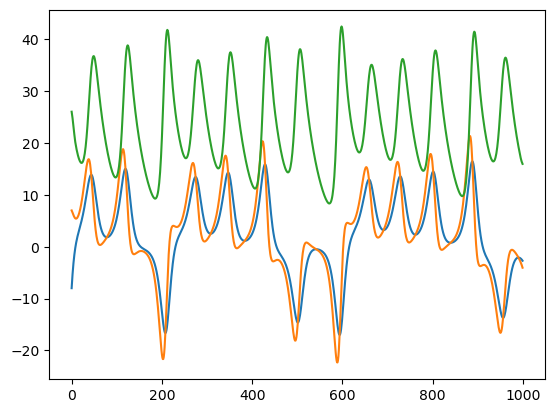

In [3]:
from scipy import signal
Y[:,2] = signal.savgol_filter(Y[:,2],  17, 2, mode= 'nearest')
Y[:,1] = signal.savgol_filter(Y[:,1],  3, 2, mode= 'nearest')
Y[:,0] = signal.savgol_filter(Y[:,0], 3, 2, mode= 'nearest')
plt.plot(Y[:,0])
plt.plot(Y[:,1])
plt.plot(Y[:,2])

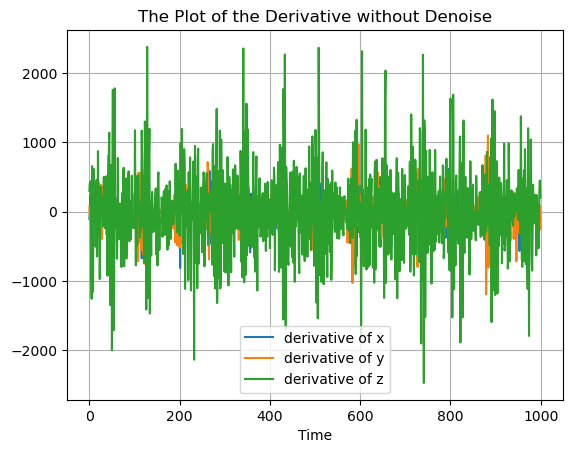

In [49]:
T, Y = create_data_twocompart(p=0.25)

Y[:,0] = signal.savgol_filter(Y[:,0], 99, 2, mode= 'nearest')
Y[:,1] = signal.savgol_filter(Y[:,1], 99, 2, mode= 'nearest')

result_1 = derivative.dxdt(Y[:,0], T, kind="spline", s=1.e-2)
result_2 = derivative.dxdt(Y[:,1], T, kind="spline", s=1.e-2)
plt.plot(result_1,label= "derivative of T")
plt.plot(result_2,label= "z")
plt.title('The Plot of the Derivative After Denoise')
plt.xlabel('Time')

plt.legend()
plt.grid()

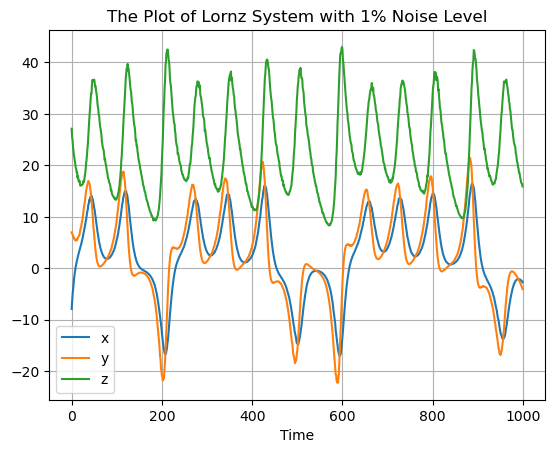

In [31]:
T, Y = create_data_lorenz(p=0.01)
plt.plot(Y[:,0],label= "x")
plt.plot(Y[:,1],label= "y")
plt.plot(Y[:,2],label= "z")
plt.title('The Plot of Lornz System with 1% Noise Level')
plt.xlabel('Time')

plt.legend()
plt.grid()

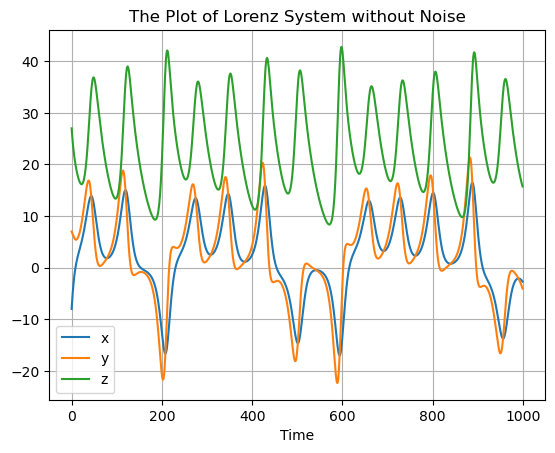

In [32]:
T, Y = create_data_lorenz(p=0.00)
plt.plot(Y[:,0],label= "x")
plt.plot(Y[:,1],label= "y")
plt.plot(Y[:,2],label= "z")
plt.title('The Plot of Lorenz System without Noise')
plt.xlabel('Time')

plt.legend()
plt.grid()

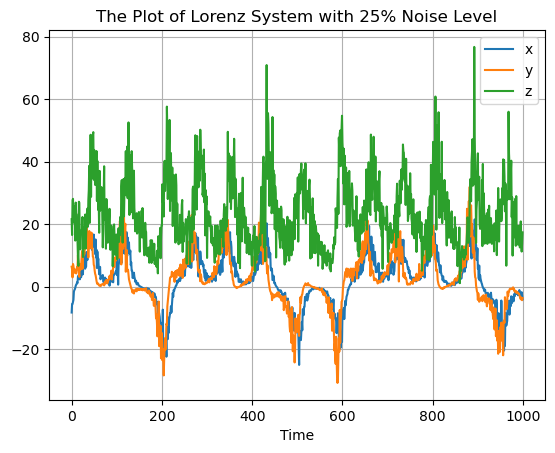

In [33]:
T, Y = create_data_lorenz(p=0.25)
plt.plot(Y[:,0],label= "x")
plt.plot(Y[:,1],label= "y")
plt.plot(Y[:,2],label= "z")
plt.title('The Plot of Lorenz System with 25% Noise Level')
plt.xlabel('Time')

plt.legend()
plt.grid()

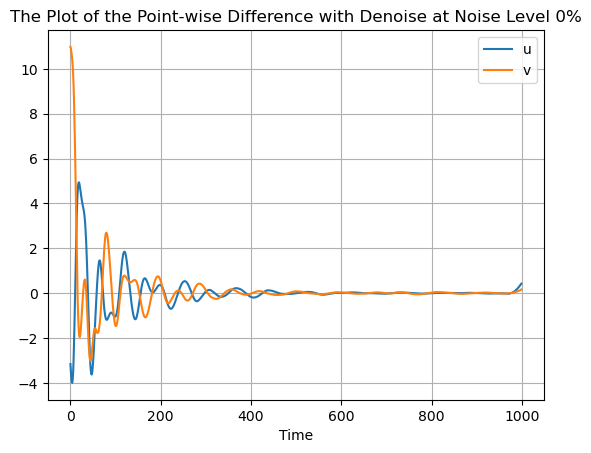

In [139]:
from scipy import signal
T, Y = create_data_nonlinear(p=0.00)
T, Y_T = create_data_nonlinear(p=0.00)
np.random.seed(1)
Y[:,0] = signal.savgol_filter(Y[:,0], 99, 2, mode= 'nearest')
Y[:,1] = signal.savgol_filter(Y[:,1], 99, 2, mode= 'nearest')
# Y[:,2] = signal.savgol_filter(Y[:,2], 17, 2, mode= 'nearest')

result_1_T = derivative.dxdt(Y_T[:,0], T,k=2, kind="finite_difference")
result_2_T = derivative.dxdt(Y_T[:,1], T,k=2, kind="finite_difference")
# result_3_T = derivative.dxdt(Y_T[:,2], T,k=2, kind="finite_difference")

result_1 = derivative.dxdt(Y[:,0], T, kind="spline", s=1.e-2)
result_2 = derivative.dxdt(Y[:,1], T, kind="spline", s=1.e-2)
# result_3 = derivative.dxdt(Y[:,2], T, kind="spline", s=1.e-2)

# result_1 = derivative.dxdt(Y[:,0], T,k=2, kind="finite_difference")
# result_2 = derivative.dxdt(Y[:,1], T,k=2, kind="finite_difference")
# result_3 = derivative.dxdt(Y[:,2], T,k=2, kind="finite_difference")

plt.plot(result_1-result_1_T,label= "u")
plt.plot(result_2-result_2_T,label= "v")
# plt.plot(result_3-result_3_T,label= "z")

# plt.plot(result_1,label= "u")
# plt.plot(result_2,label= "v")
# plt.plot(result_3,label= "z")
plt.title('The Plot of the Point-wise Difference with Denoise at Noise Level 0%')
plt.xlabel('Time')

plt.legend()
plt.grid()

In [309]:
# Gaussian Process
import numpy as np
import numpy
class Kernel:
  def __init__(self):
    pass

  def __call__(self, x, y, theta: list=None):
    raise NotImplementedError()
class RBF(Kernel):
  def __call__(self, x, y, theta: list=None):
    """
    Given an input array x of size n and another input array y of 
    size m, compute the n by m kernel matrix whose (i, j)-th entry 
    is k(x_i, y_j).

    Args:
      x: (n,)
      y: (m,)
    
    Returns:
      k_mat: (n, m)
    """
    # unpack hyper-params
    self.theta1, self.theta2 = theta

    ### TODO ###
    k_mat = (self.theta1**2)*np.exp((-np.square(np.array([x]*(y.shape[0])).T - np.array([y]*(x.shape[0])))/(2*self.theta2)))
    ### END OF TODO ###

    return k_mat

rbf = RBF()

class RBF_full_diff(Kernel):
  def __call__(self, x, y, theta: list=None):
    """
    Given an input array x of size n and another input array y of 
    size m, compute the n by m kernel matrix whose (i, j)-th entry 
    is k(x_i, y_j).

    Args:
      x: (n,)
      y: (m,)
    
    Returns:
      k_mat: (n, m)
    """
    # unpack hyper-params
    self.theta1, self.theta2 = theta

    ### TODO ###
    k_mat = (self.theta1**2)*np.exp((-np.square(np.array([x]*(y.shape[0])).T - np.array([y]*(x.shape[0])))/(2*self.theta2)))*(-np.square(np.array([x]*(y.shape[0])).T -(self.theta1**2)*np.array([y]*(x.shape[0])))/(self.theta2**2))+ (self.theta1**2)*np.exp((-np.square(np.array([x]*(y.shape[0])).T - np.array([y]*(x.shape[0])))/(2*self.theta2)))
    ### END OF TODO ###

    return k_mat

class RBF_partial_diff(Kernel):
  def __call__(self, x, y, theta: list=None):
    """
    Given an input array x of size n and another input array y of 
    size m, compute the n by m kernel matrix whose (i, j)-th entry 
    is k(x_i, y_j).

    Args:
      x: (n,)
      y: (m,)
    
    Returns:
      k_mat: (n, m)
    """
    # unpack hyper-params
    self.theta1, self.theta2 = theta

    ### TODO ###
    k_mat = (self.theta1**2)*np.exp((-np.square(np.array([x]*(y.shape[0])).T - np.array([y]*(x.shape[0])))/(2*self.theta2)))*(-(np.array([x]*(y.shape[0])).T - np.array([y]*(x.shape[0])))/(self.theta2))
    ### END OF TODO ###

    return k_mat
rbf_fd = RBF_full_diff()
rbf_pd = RBF_partial_diff()
class GP_derivative:
  def __init__(self, kernel: callable, kernel_diff: callable):
    """
    Args:
      kernel:
      prior_mean:
    """
    self.k = kernel
    self.k_d = kernel_diff

  def predict(
      self, 
      x_star, 
      X: np.array=None, 
      y: np.array=None, 
      size: int=1,
      theta: list=None,
      sigma: float=0.,
    ):
    """
    Given observations (X, y) and test points x_star, fit a GP model
    and draw posterior samples for f(x_star) from the fitted model.

    Args:
      x_star: (n*,) array of feature values at which predictions
        for f(x_star) will be made.
      X: (n,) observed features.
      y: (n,) observed response variables.
      size: number of posterior samples drawn.
      theta: (n_hyperparams,) array of kernel hyper-parameters.

    Returns:
      y_star: (size, n*) array of posterior samples for f(y_star).
    """
    ### TODO ###
    # 1. compute 
    # - k(x*, X)
    # - k(X, x*)
    # - k(x*, x*)
    # - k(X, X) + sigma^2 I_n
    k_xs_x = rbf_pd(x_star, X, theta)
    k_x_xs = rbf_pd(X, x_star, theta)
    k_xs_xs = rbf_pd(x_star, x_star, theta)
    k_x_x = rbf(X, X, theta) + (sigma**2)*np.identity(rbf(X, X, theta).shape[1])
    cov_x_x = k_xs_xs - k_xs_x@np.linalg.inv(k_x_x)@rbf(X,x_star,theta)-rbf(x_star,X,theta)@np.linalg.inv(k_x_x)@k_x_xs

    ### TODO ###
    # 2. compute posterior means and covariance matrix
    posterior_mean = k_xs_x@np.linalg.inv(k_x_x)@y
    posterior_var = cov_x_x

    ### END OF TODO ###

    self.posterior_mean = posterior_mean
    self.posterior_var = posterior_var
  

    ### TODO ###
    # 3. draw posterior samples by using the posterior
    # mean and covariance matrix
    y_star = np.random.multivariate_normal(posterior_mean, posterior_var, size)
    
    ### END OF TODO ###

    return y_star
class GP:
  def __init__(self, kernel: callable, kernel_diff: callable):
    """
    Args:
      kernel:
      prior_mean:
    """
    self.k = kernel
    self.k_d = kernel_diff

  def predict(
      self, 
      x_star, 
      X: np.array=None, 
      y: np.array=None, 
      size: int=1,
      theta: list=None,
      sigma: float=0.,
    ):
    """
    Given observations (X, y) and test points x_star, fit a GP model
    and draw posterior samples for f(x_star) from the fitted model.

    Args:
      x_star: (n*,) array of feature values at which predictions
        for f(x_star) will be made.
      X: (n,) observed features.
      y: (n,) observed response variables.
      size: number of posterior samples drawn.
      theta: (n_hyperparams,) array of kernel hyper-parameters.

    Returns:
      y_star: (size, n*) array of posterior samples for f(y_star).
    """
 
    k_xs_x = rbf(x_star, X, theta)
    k_x_xs = rbf(X, x_star, theta)
    k_xs_xs = rbf(x_star, x_star, theta)
    k_x_x = rbf(X, X, theta) + (sigma**2)*np.identity(rbf(X, X, theta).shape[1])
    cov_x_x = k_xs_xs - k_xs_x@np.linalg.inv(k_x_x)@k_x_xs

    posterior_mean = k_xs_x@np.linalg.inv(k_x_x)@y
    posterior_var = cov_x_x

    self.posterior_mean = posterior_mean
    self.posterior_var = posterior_var

    y_star = np.random.multivariate_normal(posterior_mean, posterior_var, size)

    return y_star
  
  def loglikelihood(
      self, 
      x_star, 
      X: np.array=None, 
      y: np.array=None, 
      size: int=1,
      theta: list=None,
      sigma: float=0.,
    ):
    n = rbf(X, X, theta).shape[1]
    K = rbf(X, X, theta)+1.e-8*np.eye(n)
    alpha = np.linalg.inv(rbf(X, X, theta) + (sigma**2)*np.identity(rbf(X, X, theta).shape[1]))@y
    L= np.linalg.cholesky(K)
    return 0.5*y.T.dot(alpha) + np.sum(np.log(np.diag(L))) + 0.5*n*np.log(2*np.pi)
  

In [235]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
seed = 1
gp = GP(kernel=rbf,kernel_diff=rbf_pd)
# finds the hyperparameters for two_compart
T, Y = create_data_twocompart(p=0.01)
@use_named_args([Real(1e-7, 1e-1, name='theta_1'),
      Real(1e-7, 1e+1, name='theta_2'),
      Real(1e-7, 1e+1, name='sigma')])    
def evaluate_tc_model_1(**params):
  gp = GP(kernel=rbf,kernel_diff=rbf_pd)
  theta=[params["theta_1"],params["theta_2"]] 
  y_pred = gp.loglikelihood(
                x_star=np.linspace(0,10,1000),  # set to test points
                X = np.array(T),     # set to observed x
                y = np.array(Y[:,0]),       # set to observed y
                size=1,    # draw 100 posterior samples 
                theta=theta,
                sigma=params["sigma"]
              )
  negative_logli= y_pred
  return negative_logli
# Bayesian Optimisation
bounds = [(1e-7, 1.e-1), (1e-7, 1.e-1), (1e-7, 1.e-1)]
para_two_compart_n001_1 = gp_minimize(evaluate_tc_model_1, bounds, n_calls=50)
@use_named_args([Real(1e-7, 1e+1, name='theta_1'),
      Real(1e-7, 1e+1, name='theta_2'),
      Real(1e-7, 1e+1, name='sigma')]) 
def evaluate_tc_model_2(**params):
  gp = GP(kernel=rbf,kernel_diff=rbf_pd)
  theta=[params["theta_1"],params["theta_2"]] 
  y_pred = gp.loglikelihood(
                x_star=np.linspace(0,10,1000),  # set to test points
                X = np.array(T),     # set to observed x
                y = np.array(Y[:,1]),       # set to observed y
                size=1,    # draw 100 posterior samples 
                theta=theta,
                sigma=params["sigma"]
              )
  negative_logli= y_pred
  return negative_logli
bounds = [(1e-7, 1.e-1), (1e-7, 1.e-1), (1e-7, 1.e-1)]
para_two_compart_n001_2 = gp_minimize(evaluate_tc_model_2, bounds, n_calls=50)

In [343]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
np.random.seed(1)
gp = GP(kernel=rbf,kernel_diff=rbf_pd)
# finds the hyperparameters for two_compart
T, Y = create_data_twocompart(p=0.25)
@use_named_args([Real(1e-7, 1e+1, name='theta_1'),
      Real(1e-7, 1e+1, name='theta_2'),
      Real(1e-7, 1e+1, name='sigma')])    
def evaluate_tc_model_1(**params):
  gp = GP(kernel=rbf,kernel_diff=rbf_pd)
  theta=[params["theta_1"],params["theta_2"]] 
  y_pred = gp.loglikelihood(
                x_star=np.linspace(0,10,1000),  # set to test points
                X = np.array(T),     # set to observed x
                y = np.array(Y[:,0]),       # set to observed y
                size=1,    # draw 100 posterior samples 
                theta=theta,
                sigma=params["sigma"]
              )
  negative_logli= y_pred
  return negative_logli
# Bayesian Optimisation
bounds = [(1e-7, 1.), (1e-7, 1.), (1e-7, 1.)]
para_two_compart_n025_1 = gp_minimize(evaluate_tc_model_1, bounds, n_calls=100, random_state=0)
@use_named_args([Real(1e-7, 1e+1, name='theta_1'),
      Real(1e-7, 1e+1, name='theta_2'),
      Real(1e-7, 1e+1, name='sigma')]) 
def evaluate_tc_model_2(**params):
  gp = GP(kernel=rbf,kernel_diff=rbf_pd)
  theta=[params["theta_1"],params["theta_2"]] 
  y_pred = gp.loglikelihood(
                x_star=np.linspace(0,10,1000),  # set to test points
                X = np.array(T),     # set to observed x
                y = np.array(Y[:,1]),       # set to observed y
                size=1,    # draw 100 posterior samples 
                theta=theta,
                sigma=params["sigma"]
              )
  negative_logli= y_pred
  return negative_logli
bounds = [(1e-7, 1.), (1e-7, 1.), (1e-7, 1.)]
para_two_compart_n025_2 = gp_minimize(evaluate_tc_model_2, bounds, n_calls=100,random_state=0)

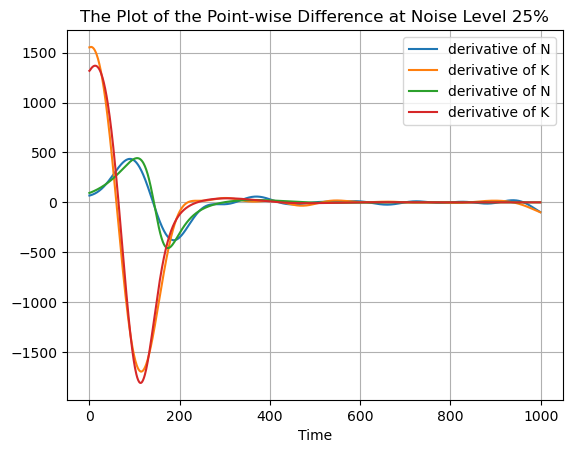

In [ ]:
T, Y = create_data_twocompart(p=0.25)
T, Y_T = create_data_twocompart(p=0.00)
toy_xp = np.arange(0,10,0.01)
gp = GP(kernel=rbf, kernel_diff=rbf_fd)
Y[:,0] = gp.predict(
x_star=toy_xp,  # set to test points
X = np.array(T),     # set to observed x
y = np.array(Y[:,0]),       # set to observed y
size=1,    # draw 100 posterior samples 
theta=[para_two_compart_n025_1.x[0],para_two_compart_n025_1.x[1]],
sigma=para_two_compart_n025_1.x[2]
)[0]
toy_xp = np.arange(0,10,0.01)
gp = GP(kernel=rbf, kernel_diff=rbf_fd)
Y[:,1] = gp.predict(
x_star=toy_xp,  # set to test points
X = np.array(T),     # set to observed x
y = np.array(Y[:,1]),       # set to observed y
size=1,    # draw 100 posterior samples 
theta=[para_two_compart_n025_2.x[0],para_two_compart_n025_2.x[1]],
sigma=para_two_compart_n025_2.x[2]
)[0]

result_1_T = derivative.dxdt(Y_T[:,0], T,k=2, kind="finite_difference")
result_2_T = derivative.dxdt(Y_T[:,1], T,k=2, kind="finite_difference")
result_1 = derivative.dxdt(Y[:,0], T,k=2, kind="finite_difference")
result_2 = derivative.dxdt(Y[:,1], T,k=2, kind="finite_difference")
# result_3 = derivative.dxdt(Y[:,2], T,k=2, kind="finite_difference")
plt.plot(result_1,label= "derivative of N")
plt.plot(result_2,label= "derivative of K")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Point-wise Difference at Noise Level 25%')
plt.xlabel('Time')
plt.plot(result_1_T,label= "derivative of N")
plt.plot(result_2_T,label= "derivative of K")
plt.legend()
plt.grid()

In [225]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
gp = GP(kernel=rbf,kernel_diff=rbf_pd)
# finds the hyperparameters for two_compart
T, Y = create_data_twocompart(p=0.00)
@use_named_args([Real(1e-7, 1e+1, name='theta_1'),
      Real(1e-7, 1e+1, name='theta_2'),
      Real(1e-7, 1e+1, name='sigma')])    
def evaluate_tc_model_1(**params):
  gp = GP(kernel=rbf,kernel_diff=rbf_pd)
  theta=[params["theta_1"],params["theta_2"]] 
  y_pred = gp.loglikelihood(
                x_star=np.linspace(0,10,1000),  # set to test points
                X = np.array(T),     # set to observed x
                y = np.array(Y[:,0]),       # set to observed y
                size=1,    # draw 100 posterior samples 
                theta=theta,
                sigma=params["sigma"]
              )
  negative_logli= y_pred
  return negative_logli
# Bayesian Optimisation
bounds = [(1e-7, 1.e+1), (1e-7, 1.e+1), (1e-7, 1.e+1)]
para_two_compart_1 = gp_minimize(evaluate_tc_model_1, bounds, n_calls=75)
@use_named_args([Real(1e-7, 1e+1, name='theta_1'),
      Real(1e-7, 1e+1, name='theta_2'),
      Real(1e-7, 1e+1, name='sigma')]) 
def evaluate_tc_model_2(**params):
  gp = GP(kernel=rbf,kernel_diff=rbf_pd)
  theta=[params["theta_1"],params["theta_2"]] 
  y_pred = gp.loglikelihood(
                x_star=np.linspace(0,10,1000),  # set to test points
                X = np.array(T),     # set to observed x
                y = np.array(Y[:,1]),       # set to observed y
                size=1,    # draw 100 posterior samples 
                theta=theta,
                sigma=params["sigma"]
              )
  negative_logli= y_pred
  return negative_logli
bounds = [(1e-7, 1.e+1), (1e-7, 1.e+1), (1e-7, 1.e+1)]
para_two_compart_2 = gp_minimize(evaluate_tc_model_2, bounds, n_calls=75)

KeyboardInterrupt: 

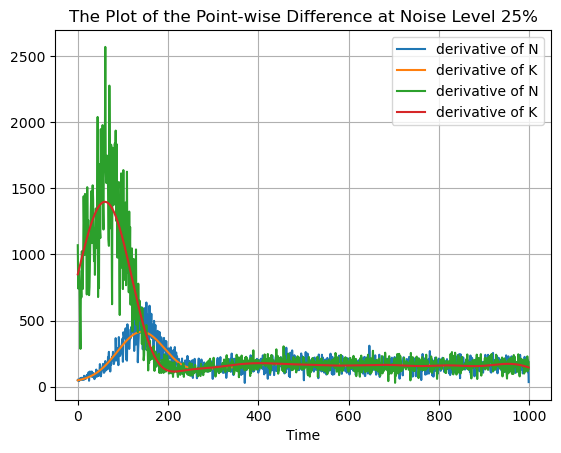

In [332]:
T, Y = create_data_twocompart(p=0.25)
T, Y_T = create_data_twocompart(p=0.25)
toy_xp = np.arange(0,10,0.01)
gp = GP(kernel=rbf, kernel_diff=rbf_fd)
Y[:,0] = gp.predict(
x_star=toy_xp,  # set to test points
X = np.array(T),     # set to observed x
y = np.array(Y[:,0]),       # set to observed y
size=1,    # draw 100 posterior samples 
theta=[para_two_compart_n025_1.x[0],para_two_compart_n025_1.x[1]],
sigma=para_two_compart_n025_1.x[2]
)[0]
toy_xp = np.arange(0,10,0.01)
gp = GP(kernel=rbf, kernel_diff=rbf_fd)
Y[:,1] = gp.predict(
x_star=toy_xp,  # set to test points
X = np.array(T),     # set to observed x
y = np.array(Y[:,1]),       # set to observed y
size=1,    # draw 100 posterior samples 
theta=[para_two_compart_n025_2.x[0],para_two_compart_n025_2.x[1]],
sigma=para_two_compart_n025_2.x[2]
)[0]
plt.plot(Y_T[:,0],label= "derivative of N")
plt.plot(Y[:,0],label= "derivative of K")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Point-wise Difference at Noise Level 25%')
plt.xlabel('Time')
plt.plot(Y_T[:,1],label= "derivative of N")
plt.plot(Y[:,1],label= "derivative of K")
plt.legend()
plt.grid()

In [5]:
fd_BR_CSS_000_tc_1 = [ 9.63313701e-02,  1.99891476e+00, -5.85454134e-08,
         -9.37200557e-09,  1.00092621e-06, -6.68108800e-08,
         -1.99979349e+00,  4.27438130e-06]
fd_BR_CSS_000_tc_2 = [-9.12751779e-04,  2.47696322e-09,  3.00048364e+00,
          4.78970856e-06, -2.93933658e-10, -4.64592953e-11,
         -6.86306228e-13, -1.00043328e-01]
fd_BR_CSS_000_nl_1 = [ 2.03367929e-06,  6.67836016e-05,  1.10315122e-07,
         -1.44755586e-05, -9.00433885e-07, -2.41846739e-06,
         -1.00057115e-01,  1.99999197e+00]
fd_BR_CSS_000_nl_2 = [-2.21468271e-05, -7.18231535e-04, -5.59329800e-05,
          4.71719708e-04, -2.53245505e-04, -5.09478389e-07,
         -1.99921144e+00, -9.99059694e-02]
fd_BR_CSS_000_lr_1 = [-4.79662816e-05, -9.99991728e+00,  9.99922853e+00,
          1.82186816e-02, -2.50226608e-02, -1.06739957e-03,
         -1.33629349e-04,  3.23812509e-03, -1.16316889e-06,
         -1.43000349e-08, -2.21513366e-06, -1.33641764e-06,
         -1.52141287e-04,  9.68747622e-04, -1.07929819e-04,
          6.01478198e-06,  5.45446919e-06]
fd_BR_CSS_000_lr_2 = [-1.06182595e-03,  2.79975458e+01, -1.00039384e+00,
          1.03331350e-02, -9.24851523e-03,  2.74226963e-05,
         -2.99591558e-04,  2.20310740e-06, -9.99881655e-01,
         -1.25102570e-05, -2.01811884e-06,  5.11117708e-11,
         -5.34882018e-05,  3.90064974e-04, -4.18616991e-05,
          2.18842492e-06,  2.06328708e-06]
fd_BR_CSS_000_lr_3 = [ 2.66775275e-01,  3.62329661e-05,  7.08981916e-05,
         -2.74617627e+00,  2.55444351e-02,  1.23149310e-03,
          5.08557753e-03,  9.93855950e-01,  1.86820398e-07,
         -7.16728599e-07,  1.31248093e-09, -8.80131411e-07,
         -1.85650889e-05, -8.01813778e-04,  8.99762581e-05,
         -5.19198409e-06, -3.34943851e-06]
fd_BR_CSS_001_tc_1 = [-5.17535444e-09,  1.86936293e+00,  9.39954009e-06,
         -2.40038953e-07,  1.98280476e-04, -5.35897613e-08,
         -1.94086051e+00,  4.85395347e-07]
fd_BR_CSS_001_tc_2 = [-2.91632317e+00,  2.17010638e-03,  3.14562428e+00,
          2.44444846e-03, -6.23730432e-07, -3.39852925e-11,
          5.60901100e-06, -1.20364639e-01]
fd_BR_CSS_001_nl_1 = [ 3.97031178e-06, -1.14827230e-02, -4.44910029e-02,
          5.26867480e-04,  3.78522439e-03,  1.91211229e-04,
         -1.15392907e-01,  2.01544352e+00]
fd_BR_CSS_001_nl_2 = [-4.89025168e-04, -5.92375693e-05,  2.63364535e-07,
          1.13978333e-03, -1.61860636e-05, -5.01619666e-06,
         -1.96204456e+00, -9.37406772e-02]
fd_BR_CSS_001_lr_1 = [-1.38967477e-05, -1.00206278e+01,  1.01087558e+01,
          1.60401719e-04,  1.02088326e-03, -2.98222036e-03,
          1.75389531e-04, -3.33184779e-12, -2.43324005e-10,
         -1.28162770e-03, -1.56066051e-04, -3.39351457e-07,
         -5.29917142e-11,  8.44123821e-06, -4.04842205e-07,
         -2.91555990e-07,  4.31023795e-11]
fd_BR_CSS_001_lr_2 = [-1.13576978e-02,  2.78664203e+01, -9.95478879e-01,
         -1.59371487e-05, -1.07090336e-05, -1.88529875e-04,
         -1.05029855e-09,  1.40142013e-07, -9.96652769e-01,
          4.57195579e-05, -1.38212848e-06, -2.88229477e-05,
          8.47799573e-09,  3.13045652e-06, -1.49617980e-10,
          6.84486851e-07, -1.91481910e-10]
fd_BR_CSS_001_lr_3 = [-2.75801479e-17, -3.68279846e-05, -4.07943468e-08,
         -2.69167122e+00, -1.19079286e-04,  1.89279830e-04,
         -1.13930090e-04,  9.97634783e-01,  3.67778129e-06,
         -6.51047154e-12, -4.85833907e-09, -3.28808670e-10,
         -5.21700157e-06,  2.02800582e-05, -8.16517701e-10,
         -3.17963307e-09,  7.28716690e-07]
fd_BR_CSS_025_tc_1 = [-4.04022646e+00, -1.82713270e+00,  3.43677326e-03,
          2.39140345e-03,  1.98943534e-09, -3.28322514e-05,
          5.35140920e-01,  3.52619624e-03]
fd_BR_CSS_025_tc_2 = [ 7.69371955e-01,  2.84303427e-01,  2.34025615e-03,
          1.96728910e-06,  1.21149618e-06, -1.06886142e-11,
         -6.94126475e-09, -1.45607954e-03]
fd_BR_CSS_025_nl_1 = [-1.68989677e-01,  3.28984694e-01,  7.42603934e-04,
          8.11288513e-14,  4.46215702e-02,  3.48365618e-04,
         -1.63574581e-03,  1.61159644e+00]
fd_BR_CSS_025_nl_2 = [ 2.19155165e-02, -1.30259333e-01,  8.86554259e-04,
          1.31301439e-06, -2.31306111e-10, -4.09104822e-03,
         -1.13747366e+00, -2.72674918e-01]
fd_BR_CSS_025_lr_1 = [-7.94101525e-03, -2.70420112e+00,  8.18901766e+00,
          1.10873287e-07, -5.41110305e-02,  5.19406445e-03,
         -3.63248600e-03, -5.40940076e-08, -1.31431787e-01,
          2.05883337e-06,  1.41447349e-03,  2.43622365e-05,
         -9.88507969e-08, -9.98290428e-05, -5.25688759e-05,
          1.29818954e-05, -2.39186556e-08]
fd_BR_CSS_025_lr_2 = [ 2.05963412e+00,  7.14896937e-08,  3.76139513e+00,
         -1.01191199e-06, -6.65255925e-06,  4.11281862e-04,
          2.03210506e-07,  8.83549050e-07, -1.95772957e-01,
         -6.32417473e-02, -2.37446601e-05,  6.27390223e-08,
          7.81567499e-08, -3.08357802e-06,  3.03495258e-05,
          1.85382370e-06,  1.57615275e-08]
fd_BR_CSS_025_lr_3 = [-2.06253091e-04,  2.06700876e-05, -7.36071292e-07,
         -5.07073948e-01,  2.92169021e-02,  3.15954568e-01,
          3.67194830e-06,  1.82674208e-04, -5.88587915e-02,
          6.70811994e-02,  5.38848115e-03, -6.93563256e-03,
          1.92798773e-16,  1.92635312e-04,  3.11062445e-04,
          7.91371433e-09, -5.49251622e-06]
fd_BR_DSS_025_tc_1 = [-0.34294445, 0 ,  0.02828649,  0,
         0, 0,  0,  0]
fd_BR_DSS_025_tc_1_Z = [1, 0, 1, 0, 0, 0, 0, 0]
fd_BR_DSS_025_tc_2 = [ 2.2347971 , -1.13834021, -0.11869497, -0.14086232,
          0.31878883,  0.42188009,  0.89400697,  0.47834192]
fd_BR_DSS_025_tc_2_Z = [1, 1, 1, 0, 0, 0, 1, 0]
fd_BR_DSS_025_nl_1 = [-0.56735095,  0.13743669, -0.17040461,  0.45028535,
          0.01034677, -0.11285495, -0.22905945,  1.39675996]
fd_BR_DSS_025_nl_1_Z = [1, 0, 1, 0, 0, 1, 1, 1]
fd_BR_DSS_025_nl_2 = [ 0.53662881, -1.08432625, -0.16421234, -0.55099585,
          0.29330281,  0.92582045, -0.77220249, -0.09418574]
fd_BR_DSS_025_nl_2_Z = [1, 0, 1, 0, 1, 1, 1, 1]
fd_BR_DSS_025_lr_1 = [-7.01787465e-01,  8.73349867e-01, -3.39118882e-02,
         -3.49018538e-01,  5.33092194e-02, -2.22815019e+00,
         -2.99006187e-01,  2.13679663e+00, -1.79377395e-01,
          2.09835806e-01, -4.76923764e-01, -7.29480287e-01,
         -2.54516442e+00, -1.52614277e-03, -8.42253272e-01,
         -2.60580381e+00, -7.10047819e-01]
fd_BR_DSS_025_lr_1_Z = [1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
fd_BR_DSS_025_lr_2 = [-3.98969714,  1.20694303,  2.76808644, -0.77225847,
         -0.06365933,  0.38097811,  1.12214907, -1.14013359,
         -0.21515685, -0.61960643, -2.10256318,  2.574581  ,
         -0.34190446, -1.19835387,  0.52203429,  0.79451258,
          0.02023364]
fd_BR_DSS_025_lr_2_Z = [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_DSS_025_lr_3 = [-0.72086897,  0.97556142, -0.8675157 , -0.18305043,
         -0.92620563,  0.03588119,  0.58600432,  0.6116045 ,
         -2.12479729, -0.63189512, -1.49458397,  0.94181529,
         -0.60402291, -7.60036955, -0.05097247, -1.28621908,
         -0.15013278]
fd_BR_DSS_025_lr_3_Z = [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_MDSS_025_tc_1 = [ 2.7016745 ,  0.72708708, -0.6097122 , -1.17942771,
         -1.21856854, -0.06442715, -0.816187  ,  0.40079217]
fd_BR_MDSS_025_tc_1_Z = [1, 0, 0, 0, 0, 0, 0, 0]
fd_BR_MDSS_025_tc_2 = [-3.39103903e-04,  8.32120208e-02,  4.88396229e-01,
          1.16586178e+00, -5.16596735e+00,  1.04183636e+00,
          1.12283209e-01, -1.79365535e+00]
fd_BR_MDSS_025_tc_2_Z = [1, 0, 0, 0, 0, 0, 0, 0]
fd_BR_MDSS_025_nl_1 = [-0.04420544,  0.12226166,  0.21361937, -0.44498833,
          0.13744684, -0.13853032, -0.23395132,  1.86090864]
fd_BR_MDSS_025_nl_1_Z = [0, 1, 1, 1, 1, 1, 0, 1]
fd_BR_MDSS_025_nl_2 = [ 0.0847798 , -0.50533437,  0.65121981, -0.05103254,
         -0.28314669, -0.83382551, -1.43778502, -0.26347634]
fd_BR_MDSS_025_nl_2_Z = [1, 0, 0, 1, 0, 0, 1, 0]
fd_BR_MDSS_025_lr_1 = [ 1.9924993 ,  0.25601921,  4.04626399,  0.17565724,
         -2.27274274,  0.09710517, -0.19861233, -1.7959369 ,
         -0.12533266,  0.17160142, -0.1920923 ,  1.30794812,
          0.63890585,  0.36736784,  0.16817184, -0.61444273,
         -0.39910403]
fd_BR_MDSS_025_lr_1_Z = [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_MDSS_025_lr_2 = [-0.96712443,  1.19916277,  4.27857068,  0.38652733,
         -1.10910127,  0.44634475,  1.55796631,  2.48767932,
         -0.27358313,  0.03147989,  0.11339136, -2.41681619,
          0.12903148, -1.25431713,  0.01026783,  0.00609451,
         -0.17107336]
fd_BR_MDSS_025_lr_2_Z = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_MDSS_025_lr_3 = [-0.22162421, -0.88926191, -0.25069398, -0.84764811,
          0.66968082,  1.32528204,  1.70234588, -0.03528001,
          0.28685031, -0.25537035, -0.58256885, -2.05235855,
          6.12057814, -0.08573592, -0.2140996 ,  0.29035956,
          0.3595483 ]
fd_BR_MDSS_025_lr_3_Z = [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_DSS_001_tc_1 = [ 0.21022589,  1.87532952,  0.40061605, -0.66935596,
         -0.59474979, -0.77910389, -1.90129522,  0.54878717]
fd_BR_DSS_001_tc_1_Z = [0, 1, 0, 0, 0, 0, 1, 0]
fd_BR_DSS_001_tc_2 = [-0.44241181,  0.17657841,  2.98002957, -1.23481227,
          0.45203695, -1.9721708 ,  0.04034633, -0.0995345 ]
fd_BR_DSS_001_tc_2_Z = [1, 0, 1, 0, 0, 0, 1, 1]
fd_BR_DSS_001_nl_1 = [-1.90016194e+00, -3.20093214e+00, -2.04035552e-01,
         -8.25434141e-01,  2.15109872e-01,  6.37595135e-01,
         -8.91394841e-02,  1.99967425e+00]
fd_BR_DSS_001_nl_1_Z = [0, 0, 0, 0, 0, 0, 1, 1]
fd_BR_DSS_001_nl_2 =  [-0.32799714, -0.74498123,  0.09179266,  0.36708096,
          0.20804843,  1.31008778, -2.02352032, -0.14047858]
fd_BR_DSS_001_nl_2_Z = [0, 0, 1, 0, 0, 0, 1, 1]
fd_BR_DSS_001_lr_1 = [ -2.19355161, -10.06037806,  10.08292187,  -0.09548737,
          -0.19909819,   0.73903601,   0.22181018,  -2.46777114,
          -0.3672778 ,   0.46708377,   1.54940408,   0.33946658,
           0.1189727 ,   1.33307325,  -0.34554376,   1.12322035,
           0.52049694]
fd_BR_DSS_001_lr_1_Z = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_DSS_001_lr_2 = [-4.55030209e-02,  2.75579036e+01, -8.49986098e-01,
          1.08566023e+00, -2.24243557e+00, -4.49744644e-01,
          2.78091376e+00, -2.14581907e-01, -9.91952421e-01,
          2.64835784e-01,  5.34326443e-01,  2.19714894e-02,
         -2.89348983e-02, -1.10151232e+00,  9.37422019e-01,
         -5.94216884e-01,  7.93002070e-01]
fd_BR_DSS_001_lr_2_Z = [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_DSS_001_lr_3 = [-0.03105114, -0.40398857, -0.79561779, -2.58584068,
         -1.34875622, -0.03094738,  2.48818522,  0.99734117,
          0.58029433, -1.7557629 ,  0.02461922,  0.20085629,
         -0.58101623, -0.63795822,  0.40976047,  0.29349774,
         -1.81359831]
fd_BR_DSS_001_lr_3_Z = [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_MDSS_001_tc_1 = [-0.02329055,  2.03657112, -1.99714148, -0.79445435,
          0.01700234, -0.57941536, -2.0172096 ,  0.41163572]
fd_BR_MDSS_001_tc_1_Z = [0, 1, 0, 0, 0, 0, 1, 0]
fd_BR_MDSS_001_tc_2 = [-0.34826922, -0.15565211,  2.91493072, -1.13070953,
         -1.57038315,  0.52953103,  3.17235582, -0.09608679]
fd_BR_MDSS_001_tc_2_Z = [0, 0, 1, 0, 0, 0, 0, 1]
fd_BR_MDSS_001_nl_1 = [-0.84512742, -0.44642086,  0.37155695, -4.31438021,
         -0.9263872 , -0.75141284, -0.04447505,  1.97634199]
fd_BR_MDSS_001_nl_1_Z = [0, 0, 0, 0, 0, 0, 1, 1]
fd_BR_MDSS_001_nl_2 = [ 2.21483648, -1.15759486, -1.24632565,  0.5333962 ,
          1.68907466,  0.70858076, -2.01834958, -0.10793253]
fd_BR_MDSS_001_nl_2_Z = [0, 0, 0, 0, 0, 0, 1, 1]
fd_BR_MDSS_001_lr_1 = [ 2.78733075e-01, -1.00154914e+01,  9.98167905e+00,
         -1.48811956e-01, -1.07902157e+00, -9.59600459e-01,
          8.03669515e-01, -1.44545683e-02, -7.30217657e-03,
         -2.97514152e-02, -1.78339935e-01, -9.08623838e-01,
          5.45114051e-01, -1.13571016e-01, -2.07457637e+00,
          1.49937296e+00,  3.57560259e-01]
fd_BR_MDSS_001_lr_1_Z = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_MDSS_001_lr_2 = [-1.09506705e-01,  2.74484620e+01, -9.00521682e-01,
         -5.02935279e-01, -3.10855447e-01, -1.78352149e-01,
         -3.09170894e+00,  1.68017338e+00, -9.83864910e-01,
          3.05232354e+00,  8.23150106e-01, -2.81119382e+00,
          1.33438373e-01, -5.50591084e-01, -1.96232928e-02,
          2.05641109e+00,  4.28198883e-01]
fd_BR_MDSS_001_lr_2_Z = [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_MDSS_001_lr_3 = [-1.01230601, -0.45283352,  0.12315299, -2.61945918,
          4.09165121, -0.5560231 ,  0.68904739,  0.99105684,
          4.19217195,  2.07465039, -0.26228121, -1.53611435,
          0.21932308,  0.43067209,  0.96906697, -4.41783076,
         -0.82319738]
fd_BR_MDSS_001_lr_3_Z = [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fd_BR_DSS_000_tc_1 = [ 0.269008  ,  2.00000929,  0.94851874, -0.13081822,
          0.71393715,  0.44327038, -2.00000702, -0.01322886]
fd_BR_DSS_000_tc_1_Z = [0, 1, 0, 0, 0, 0, 1, 0]
fd_BR_DSS_000_tc_2 = [-7.93004849e-02, -1.51416711e+00,  3.00045538e+00,
          3.98916570e-06,  1.10443086e+00,  1.07999476e+00,
          9.95041936e-01, -1.00037556e-01]
fd_BR_DSS_000_tc_2_Z = [0, 0, 1, 1, 0, 0, 0, 1]
fd_BR_DSS_000_nl_1 =[-0.70212286, -1.34018663,  0.3883637 ,  1.25349767,
          1.26205594,  1.51876152, -0.10002936,  1.99999765]
fd_BR_DSS_000_nl_1_Z = [0, 0, 0, 0, 0, 0, 1, 1]
fd_BR_DSS_000_nl_2 = [-2.29788640e+00, -2.97878298e-04, -2.43358856e+00,
          4.04658917e-04, -3.48724557e+00, -8.11473052e-01,
         -1.99954703e+00, -1.00022345e-01]
fd_BR_DSS_000_nl_2_Z = [0, 1, 0, 1, 0, 0, 1, 1]
fd_BR_DSS_000_lr_1 = [ 1.47348039e+00, -9.92739938e+00,  9.97324049e+00,
         -1.54380072e-01, -1.94925460e-03, -1.97128619e-03,
         -1.37043174e+00,  4.20997728e-03, -2.06088427e-03,
          4.88698411e-01,  1.24349256e-04, -2.41977153e-01,
         -7.38274683e-01, -1.90520584e-01,  5.80427290e+00,
         -1.63806175e-02,  1.30392124e+00]
fd_BR_DSS_000_lr_1_Z = [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
fd_BR_DSS_000_lr_2 = [ 2.01020087e-01,  2.80037270e+01, -1.00062742e+00,
         -1.86902428e-02, -7.69971887e-03, -1.38209248e-03,
         -1.77201071e-01,  6.87688867e-03, -1.00010138e+00,
         -1.09818336e+00, -1.96189879e+00, -1.44362310e+00,
          2.20763492e-05, -7.61090398e-01, -5.22079275e-01,
          3.64606509e-01,  4.09968682e-01]
fd_BR_DSS_000_lr_2_Z = [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]
fd_BR_DSS_000_lr_3 = [-2.19308113e-01, -1.93541985e-01,  1.12011592e+00,
         -2.65257343e+00,  2.53858594e+00,  5.34152397e-03,
          1.62770263e-01,  9.92257213e-01, -5.06404288e-01,
          5.79723680e-01, -3.90304578e-01,  6.27809394e-01,
         -7.50143812e-06,  5.33954429e-01,  1.60064949e-05,
         -3.71833504e-06,  3.36388432e-01]
fd_BR_DSS_000_lr_3_Z = [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
fd_BR_MDSS_000_tc_1 = [-0.52839969,  1.99999799,  2.03900043, -0.42562008,
          0.40090164,  2.76245182, -1.99999811,  1.36066848]
fd_BR_MDSS_000_tc_1_Z = [0, 1, 0, 0, 0, 0, 1, 0]
fd_BR_MDSS_000_tc_2 = [-3.78541851e-01,  4.67796623e-01,  3.00040633e+00,
          3.46315481e-06, -9.73652569e-01, -1.88278509e+00,
         -8.06640370e-01, -1.00033018e-01]
fd_BR_MDSS_000_tc_2_Z = [0, 0, 1, 1, 0, 0, 0, 1]
fd_BR_MDSS_000_nl_1 = [ 1.69929094, -0.31616375, -0.00824853, -0.07368401,
          0.8388545 ,  0.54855155, -0.10002951,  1.99998953]
fd_BR_MDSS_000_nl_1_Z = [0, 0, 0, 0, 0, 0, 1, 1]
fd_BR_MDSS_000_nl_2 = [ 1.69492140e-01, -6.46613367e-04,  3.67461842e-01,
         -1.93058223e+00,  1.97295516e+00,  6.28951929e-01,
         -1.99926412e+00, -9.99063288e-02]
fd_BR_MDSS_000_nl_2_Z = [0, 1, 0, 0, 0, 0, 1, 1]
fd_BR_MDSS_000_lr_1 = [-3.33557767e+00, -9.90767105e+00,  9.96242093e+00,
          3.24436106e-01, -3.78728641e+00, -1.18550379e-01,
         -2.96418806e-01,  1.91605166e+00, -2.74784383e-03,
         -1.00087487e+00,  2.04924190e-04,  2.41235315e-01,
          1.09985008e+00, -1.27516893e+00, -8.35764597e-01,
          4.24196782e+00, -1.12420372e+00]
fd_BR_MDSS_000_lr_1_Z = [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
fd_BR_MDSS_000_lr_2 = [-4.35383811e-01,  2.80728630e+01, -1.02101062e+00,
          3.29952565e-01, -8.23282178e-01, -3.79484832e-02,
          6.39833699e-02,  8.95106540e-01, -1.00245721e+00,
          2.09898383e+00,  2.01238171e-04, -2.99700084e-05,
          2.34190292e+00, -8.60861301e-01, -1.64177956e-01,
         -7.39599049e-03,  3.20064721e-01]
fd_BR_MDSS_000_lr_2_Z = [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
fd_BR_MDSS_000_lr_3 = [-3.34627136e+00,  1.37333910e+00, -3.38060369e-01,
         -2.68415174e+00,  2.23381358e-02, -1.26854258e+00,
         -1.82594753e+00,  9.99547350e-01,  1.04282573e+00,
         -2.96186497e+00, -1.78758243e+00, -3.04552104e-01,
          1.47880484e-04, -9.07086375e-04,  9.83059282e-05,
         -5.52741486e-06, -5.11132461e-06]
fd_BR_MDSS_000_lr_3_Z = [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
fd_deBR_DSS_000_tc_1 = [-5.14836227e-01,  1.09549807e+00, -2.69389679e-01,
         -7.64249510e-03,  7.47458592e-04, -2.90348117e-04,
         -1.67869785e+00,  6.78709703e-02]
fd_deBR_DSS_000_tc_1_Z = [1, 1, 1, 1, 1, 1, 1, 1]
fd_deBR_DSS_000_tc_2 = [ 1.37541821e-01,  3.10943705e+00,  2.69598419e+00,
          1.97047351e-02, -4.10286342e-03,  1.27441579e-03,
         -5.76964656e-01, -2.66475878e-01]
fd_deBR_DSS_000_tc_2_Z = [1, 1, 1, 1, 1, 1, 1, 1]
fd_deBR_DSS_000_nl_1 = [ 0.24371893,  0.04639236,  0.47271924, -0.2479909 ,
         -0.3135431 , -1.29991279, -0.17710347,  1.75209183]
fd_deBR_DSS_000_nl_1_Z = [1, 1, 1, 1, 1, 0, 1, 1]
fd_deBR_DSS_000_nl_2 = [-0.57922186, -0.80928209, -0.16143793,  0.15400882,
          0.72906122,  2.31544746, -1.33004373,  0.03794637]
fd_deBR_DSS_000_nl_2_Z = [0, 1, 1, 1, 0, 0, 1, 1]
fd_deBR_DSS_000_lr_1 = [ 6.30344969e-01, -1.00030173e+01,  1.00035829e+01,
         -9.09787665e-02, -1.81239993e-02, -8.15167734e-03,
          2.97940199e-03,  3.02446400e-02, -2.48612216e+00,
          4.19617797e-03, -1.40685146e-01, -7.36754357e-01,
          1.27451886e-01, -3.50464152e-04,  1.49655581e-05,
         -2.16382489e+00,  3.12276061e+00]
fd_deBR_DSS_000_lr_1_Z = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
fd_deBR_DSS_000_lr_2 = [-7.02815848e-02,  2.74178567e+01, -9.25955866e-01,
          2.01060715e-01,  6.55502338e-01,  4.42784549e-01,
         -2.90539401e-01, -4.61213771e-01, -9.73132603e-01,
         -8.06203661e-02, -3.82687980e-03,  1.04942650e-03,
         -1.80470362e+00,  3.36739419e-05,  4.72430755e-01,
         -6.82803406e-01,  2.58881133e-02]
fd_deBR_DSS_000_lr_2_Z = [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]
fd_deBR_DSS_000_lr_3 = [ 3.61042133e+00, -3.55811371e-01,  1.20561113e-01,
         -4.20398013e+00,  4.53684623e-01, -2.71670641e-02,
          1.42285810e-01,  9.65664835e-01,  8.32372143e-03,
         -2.05578721e+00,  1.63243914e+00,  4.39249781e-01,
         -3.65201933e-03, -1.35962327e-02,  1.01087601e-03,
         -1.79718285e+00,  3.77773288e-01]
fd_deBR_DSS_000_lr_3_Z = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
fd_deBR_MDSS_000_tc_1 = [-5.33783912e-02,  1.07549265e+00, -2.66756033e-01,
         -7.58164762e-03,  7.21758163e-04, -2.91773556e-04,
         -1.66141631e+00,  6.75882741e-02]
fd_deBR_MDSS_000_tc_1_Z = [0, 1, 1, 1, 1, 1, 1, 1]
fd_deBR_MDSS_000_tc_2 = [-1.89565926e+00, -3.89913346e-01,  2.03059155e+00,
         -8.21114026e-03,  2.22021634e-01,  4.45418657e-01,
         -4.37079955e-02, -2.15172031e-02]
fd_deBR_MDSS_000_tc_2_Z = [0, 0, 1, 1, 0, 0, 1, 1]
fd_deBR_MDSS_000_nl_1 = [ 0.22357673, -1.6432445 ,  0.58882625, -0.26816023,
         -0.30928492, -0.1218371 , -0.13759613,  1.73268297]
fd_deBR_MDSS_000_nl_1_Z = [1, 0, 1, 1, 1, 1, 1, 1]
fd_deBR_MDSS_000_nl_2 = [-2.6247315 , -0.83753639, -0.07900608,  0.1939925 ,
         -0.38055655,  2.41370675, -1.3094605 , -0.00287027]
fd_deBR_MDSS_000_nl_2_Z = [0, 1, 1, 1, 0, 0, 1, 0]
fd_deBR_MDSS_000_lr_1 =[-7.67448772e-01, -9.88064927e+00,  9.96159963e+00,
         -1.25227680e-01, -3.71319622e-01,  1.38749900e+00,
         -3.13360884e-01,  1.37624374e+00, -3.69305870e-03,
         -6.36286397e-01,  2.64127841e-04, -3.47537102e-05,
          1.13680897e-01,  3.94694645e-01, -1.63678430e+00,
          2.64604844e+00,  9.82551179e-01]
fd_deBR_MDSS_000_lr_1_Z = [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
fd_deBR_MDSS_000_lr_2 = [-4.91885165e-02,  2.74060647e+01, -9.25660892e-01,
         -2.77946004e-01,  3.12921886e-01, -1.36432159e-03,
          1.62782868e+00,  2.53949741e-03, -9.72656160e-01,
          5.18089567e-01, -3.84977835e-03,  1.05060856e-03,
         -1.05458529e-01,  2.10537291e-01,  2.90290857e-01,
         -9.89598080e-01,  1.04642306e-01]
fd_deBR_MDSS_000_lr_2_Z = [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0]
fd_deBR_MDSS_000_lr_3 = [ 1.54356429e+00, -9.25576422e-02, -6.26166031e-01,
         -3.94723525e+00,  4.40304757e-01, -2.49974273e-02,
          1.30909040e-01,  9.65757050e-01, -9.76367948e-01,
          4.16312132e-03, -1.21651895e+00,  3.53989659e-01,
         -3.45852328e-03, -1.33436258e-02,  9.92808938e-04,
         -1.50314647e+00,  3.75208402e-01]
fd_deBR_MDSS_000_lr_3_Z = [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
fd_deBR_DSS_001_tc_1 = [-7.97574679e-01,  1.03514730e+00, -2.74108407e-01,
         -7.92744717e-03,  7.83823687e-04, -3.07968711e-04,
         -1.65390830e+00,  7.06185191e-02]
fd_deBR_DSS_001_tc_1_Z = [0, 1, 1, 1, 1, 1, 1, 1]
fd_deBR_DSS_001_tc_2 = [-2.81143378,  0.07858093,  1.94895998, -0.00884469,
         -0.50022273, -0.53074534, -0.09607546, -0.01562858]
fd_deBR_DSS_001_tc_2_Z = [0, 1, 1, 1, 0, 0, 1, 1]
fd_deBR_DSS_001_nl_1 = [ 0.22457345,  0.32461402,  0.48400909, -0.23930774,
         -0.31303996, -0.10348284, -0.1334457 ,  1.81972238]
fd_deBR_DSS_001_nl_1_Z = [1, 0, 1, 1, 1, 1, 1, 1] 
fd_deBR_DSS_001_nl_2 = [-0.39242362, -0.80825557, -0.14710519,  0.15684563,
          0.3599307 , -0.35620875, -1.34569198,  0.03784419]
fd_deBR_DSS_001_nl_2_Z = [0, 1, 1, 1, 0, 0, 1, 1]
fd_deBR_DSS_001_lr_1 = [-2.19554170e+00, -9.98912510e+00,  1.00194824e+01,
          2.06373074e+00, -1.54742101e+00, -7.48681829e-02,
         -9.79965091e-01,  1.80410591e-01,  3.04540086e+00,
         -9.47342949e-02,  1.32691606e+00,  1.43317013e+00,
         -1.22874185e+00,  3.83176433e-01, -1.22767820e-01,
         -8.84918700e-01,  2.62226137e-01]
fd_deBR_DSS_001_lr_1_Z = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fd_deBR_DSS_001_lr_2 = [-9.60993303e-02,  2.75455663e+01, -8.29812088e-01,
         -3.70051143e-01, -1.27934953e+00,  6.63633288e-02,
          2.36369871e-01,  1.66136805e+00, -9.92396887e-01,
         -5.79734339e-02,  2.76552175e+00,  4.69938892e-01,
          4.85123284e-01,  1.60675724e+00, -4.09930783e-01,
         -7.73579837e-01, -1.03515740e+00]
fd_deBR_DSS_001_lr_2_Z = [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fd_deBR_DSS_001_lr_3 = [ 2.91471456e+00,  3.58040824e-02, -4.59780306e-02,
         -3.64788163e+00,  3.58034663e-01,  8.94892444e-02,
          1.37562595e-01,  6.40719318e-01,  1.03273574e+00,
          3.93816352e+00,  1.69537372e-01, -2.11367911e-01,
         -5.40974230e-03,  3.05187175e-01,  6.62289941e-01,
          6.94589177e-01,  5.05715194e-05]
fd_deBR_DSS_001_lr_3_Z = [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
fd_deBR_MDSS_001_tc_1 = [ 2.16855930e+00,  1.11231241e+00, -2.63559129e-01,
         -7.39153697e-03,  7.88317425e-04, -2.74848901e-04,
         -1.68387140e+00,  6.54917059e-02]
fd_deBR_MDSS_001_tc_1_Z = [0, 1, 1, 1, 1, 1, 1, 1]
fd_deBR_MDSS_001_tc_2 = [-5.45272540e-01,  7.99990291e-01,  1.87571932e+00,
         -1.12645965e-02,  1.26259513e-03,  1.18006040e+00,
         -2.33143936e-01, -1.09720856e+00]
fd_deBR_MDSS_001_tc_2_Z = [0, 0, 1, 1, 1, 0, 1, 0]
fd_deBR_MDSS_001_nl_1 = [ 0.28747873,  1.25273492,  0.55906813, -0.25789886,
         -0.4109337 , -5.84950527, -0.15613985,  1.72356457]
fd_deBR_MDSS_001_nl_1_Z = [1, 0, 1, 1, 1, 0, 1, 1]
fd_deBR_MDSS_001_nl_2 = [-2.35186916, -0.73940035, -0.11826955,  0.15362545,
         -0.5829279 , -1.80361032, -1.38197883,  2.73753269]
fd_deBR_MDSS_001_nl_2_Z = [0, 1, 1, 1, 0, 0, 1, 0]
fd_deBR_MDSS_001_lr_1 = [ -0.70792781, -10.02828456,   9.99692418,   0.55641617,
          -1.12206432,  -0.34296698,   1.59317242,   0.78434083,
           1.41674628,   0.21676918,   0.19324213,  -1.34868488,
           0.32021182,  -0.01365156,   0.94726492,  -0.80038628,
           0.06733272]
fd_deBR_MDSS_001_lr_1_Z = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fd_deBR_MDSS_001_lr_2 = [-8.85183121e-04,  2.80892933e+01, -9.05752076e-01,
          1.46485631e+00,  3.64389389e-01,  2.61722453e+00,
         -1.74398983e+00,  8.29435843e-01, -1.00795463e+00,
          1.93887018e+00, -2.98238649e+00,  2.49762146e+00,
          6.56820033e-02,  1.72592098e+00,  5.66707436e-02,
         -1.16450959e+00,  1.62300817e+00]
fd_deBR_MDSS_001_lr_2_Z = [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fd_deBR_MDSS_001_lr_3 = [ 6.14719519e-01, -4.20919794e-02, -8.49882052e-01,
         -3.93380837e+00,  3.60372480e-01,  6.03390235e-02,
          1.66913292e-01,  7.15366588e-01,  1.09256094e+00,
          8.28621387e-01, -3.30112908e-01,  1.21726435e-01,
         -6.74689550e-03, -3.53873586e+00, -3.09549761e-04,
         -1.36086166e-01,  7.25017030e-05]
fd_deBR_MDSS_001_lr_3_Z = [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
fd_deBR_DSS_025_tc_1 = [ 0.26992438,  1.54752705, -0.29231195, -0.00353574,
          0.57927383, -3.36594432, -1.63775146,  0.0313605 ]
fd_deBR_DSS_025_tc_1_Z = [1, 1, 1, 1, 0, 0, 1, 1]
fd_deBR_DSS_025_tc_2 = [ 2.92253287e-01,  1.45874741e-01,  1.83728891e+00,
         -1.04598371e-02, -3.99416158e+00,  2.76752972e+00,
         -2.46354290e-01,  3.42196938e-03]
fd_deBR_DSS_025_tc_2_Z = [1, 1, 1, 1, 0, 0, 1, 0]
fd_deBR_DSS_025_nl_1 = [ 0.42484862,  0.08740452,  0.54044281, -0.43024147,
         -0.50713758,  3.24983939, -0.24106533,  1.62180038]
fd_deBR_DSS_025_nl_1_Z = [1, 1, 1, 1, 1, 0, 1, 1]
fd_deBR_DSS_025_nl_2 = [-0.08142596, -1.07037514, -0.05515621,  0.35132148,
         -2.86423042, -0.15274002, -1.09322703, -0.3231072 ]
fd_deBR_DSS_025_nl_2_Z = [1, 1, 1, 1, 0, 1, 1, 0]
fd_deBR_DSS_025_lr_1 = [ 0.74904352, -1.21873734,  0.29373159,  0.30558515,
          0.61309554,  0.05522377, -0.96806641, -0.06804632,
         -0.27928414,  0.21286962,  0.00952404, -1.09003709,
         -3.06397961,  2.48895955, -0.37132568, -1.05146615,
         -0.00839243]
fd_deBR_DSS_025_lr_1_Z = [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
fd_deBR_DSS_025_lr_2 = [-0.0452961 ,  0.94129355,  4.54224506,  0.49178305,
          0.16667547,  0.12333373, -0.55491199,  1.69761372,
         -0.31403064,  1.09309602, -0.38186628,  0.09517697,
         -0.30492359,  0.65998614,  0.48105035, -0.84139227,
         -0.92126597]
fd_deBR_DSS_025_lr_2_Z = [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fd_deBR_DSS_025_lr_3 = [-5.57594914e-01,  2.56335887e-01, -3.17208153e-01,
         -1.97852916e+00, -1.41940678e+00, -4.23922970e-01,
          1.31400009e-02,  7.21180813e-01,  4.96669940e-01,
         -5.01036934e-01, -6.07298988e-03,  5.42032113e-04,
         -2.18280398e+00,  4.06260611e+00,  8.86890667e-01,
          3.60016118e-01, -6.69185900e-02]
fd_deBR_DSS_025_lr_3_Z = [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
fd_deBR_MDSS_025_tc_1 = [-3.98445525e-01,  1.22551882e+00, -1.73107074e+00,
         -2.53441145e+00, -1.67553040e-03, -1.50920447e-04,
         -1.27855280e+00,  1.15152112e-02]
fd_deBR_MDSS_025_tc_1_Z = [0, 1, 0, 0, 1, 1, 1, 1]
fd_deBR_MDSS_025_tc_2 = [ 7.59740106e-02,  1.15836796e-01,  3.34139714e+00,
         -1.03508058e+00,  2.71258104e-03,  2.91755144e-01,
         -3.53442115e-01, -1.14976381e-01]
fd_deBR_MDSS_025_tc_2_Z = [0, 1, 1, 0, 1, 0, 1, 1]
fd_deBR_MDSS_025_nl_1 = [ 0.29459603,  0.63846241,  0.46994423, -0.20674445,
         -0.54474179, -0.6915094 , -0.18058603,  1.89259858]
fd_deBR_MDSS_025_nl_1_Z = [1, 0, 1, 1, 1, 0, 1, 1]
fd_deBR_MDSS_025_nl_2 = [-0.13030304, -1.01310858, -0.11069327,  0.40182829,
          0.11314096, -0.24087172, -1.07789008,  0.20804965]
fd_deBR_MDSS_025_nl_2_Z = [1, 1, 1, 1, 0, 1, 1, 0]
fd_deBR_MDSS_025_lr_1 = [-2.77887495,  1.3004677 ,  6.68044059, -0.53082835,
          0.53633813,  2.9608666 ,  0.06963861, -0.38923154,
         -0.15488337, -3.22245002,  0.14805973, -1.39487339,
          0.61441985, -1.46455791, -2.03019686,  1.80383222,
         -0.7162657 ]
fd_deBR_MDSS_025_lr_1_Z = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fd_deBR_MDSS_025_lr_2 = [-4.85129034e+00,  8.26552519e+00,  1.58278916e+00,
          1.95462870e+00, -9.80028287e-01,  4.22970797e-02,
          1.86185358e-01,  4.44006886e-01, -4.48548779e-01,
         -8.99610733e-01, -2.88678771e+00,  5.71393562e-01,
          2.43499988e-01, -7.74901535e-02,  1.29363414e+00,
         -4.49785002e-01, -1.04683212e-01]
fd_deBR_MDSS_025_lr_2_Z =  [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fd_deBR_MDSS_025_lr_3 = [-0.64573624,  1.36850234, -1.55736671, -2.14685755,
          0.08017145, -0.87774287, -0.17236281,  0.75726679,
         -0.1912116 ,  0.64601917, -0.19630248,  2.3142775 ,
         -0.38313597,  0.80881458,  0.59522058,  1.31890512,
         -1.11808611]
fd_deBR_MDSS_025_lr_3_Z = [1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fd_deBR_CSS_025_tc_1 = [-2.77719762e-08,  2.43371451e+00, -3.09580378e-01,
         -3.28134644e-05, -1.79343377e-04,  2.10019196e-04,
         -2.18028773e+00, -1.47925049e-08]
fd_deBR_CSS_025_tc_2 = [-2.95054718e-08,  1.60601977e-03,  3.45020752e+00,
          7.24300891e-03, -2.69559492e-04, -5.55545383e-12,
          2.18156554e-08, -1.55508233e-01]
fd_deBR_CSS_025_nl_1 = [ 1.01213168e-01, -1.53014709e-03,  6.47589640e-01,
         -2.32016323e-05, -3.81802757e-01, -1.86769652e-01,
         -1.01523587e-01,  1.50833079e+00]
fd_deBR_CSS_025_nl_2 = [ 3.97906890e-04, -6.35368036e-01, -4.60427911e-02,
          1.21004006e-01,  8.53340092e-04, -1.15758008e-01,
         -1.55628547e+00, -1.68307875e-03]
fd_deBR_CSS_025_lr_1 = [ 7.02235406e-01, -6.23762211e+00,  5.98907493e+00,
         -4.44537281e-05,  4.56310104e-06,  1.01264963e-04,
          2.31655501e-05,  2.10745689e-04, -3.90625979e-04,
          7.92240523e-03,  4.50034211e-10,  7.26228198e-05,
          3.63075346e-08,  1.16568961e-05, -6.15231150e-08,
         -7.62927368e-06, -2.34460200e-07]
fd_deBR_CSS_025_lr_2 = [-6.27846002e-02,  2.40386574e+01, -3.91923601e-03,
         -1.57173168e-08, -2.27883375e-03,  5.54364525e-04,
          3.92716690e-06, -3.30623515e-01, -8.74173902e-01,
          5.45958434e-05,  2.17162258e-03, -2.22021001e-13,
         -8.17510066e-10,  7.44545777e-03, -3.17351501e-08,
         -8.80412907e-06,  7.22364678e-08]
fd_deBR_CSS_025_lr_3 = [ 8.00833137e-01,  1.02118340e+00,  1.27984515e-02,
         -4.38177690e+00,  1.59046559e-04,  6.30828343e-01,
          5.83910703e-02,  2.66699926e-01,  4.23896514e-03,
         -6.64919431e-07, -2.17600997e-03, -2.03405329e-03,
          8.75496984e-05, -2.08003000e-08,  2.66234790e-04,
         -5.86201245e-04, -2.84557728e-10]
fd_deBR_CSS_001_tc_1 = [-1.27164957e+01,  1.22910085e+00, -2.40034202e-01,
         -7.27792168e-03,  5.48793476e-04, -2.83300787e-04,
         -1.69098449e+00,  6.44586883e-02]
fd_deBR_CSS_001_tc_2 = [-5.03255860e+02,  7.36248436e+00,  3.33565967e+00,
          1.89244453e-02, -9.58771840e-03,  1.09260602e-03,
         -1.05721030e+00, -2.75758341e-01]
fd_deBR_CSS_001_nl_1 = [ 2.28305266e-01,  1.65723050e-11,  5.51453514e-01,
         -1.92568464e-01, -3.73635374e-01, -9.63280091e-02,
         -1.30349982e-01,  1.70080059e+00]
fd_deBR_CSS_001_nl_2 = [-2.32260000e-02, -7.84977544e-01, -1.27864882e-01,
          1.53062027e-01, -9.53787584e-06,  3.96330645e-03,
         -1.33826197e+00, -1.74375336e-05]
fd_deBR_CSS_001_lr_1 = [-2.27565294e-01, -1.00093818e+01,  1.00331958e+01,
          4.93481332e-03,  2.66942166e-04,  1.67097537e-03,
         -5.13442253e-05,  9.86091311e-08, -1.24116033e-06,
          2.62720289e-04, -8.88463804e-05, -3.02018005e-09,
          4.82079864e-06, -2.96197979e-06,  8.34396443e-13,
         -4.52824079e-06, -2.63292507e-14]
fd_deBR_CSS_001_lr_2 = [-3.92658544e-02,  2.82977504e+01, -1.07750182e+00,
         -9.06988647e-09, -8.21100911e-05,  4.18046990e-05,
          1.43185245e-06,  1.52618705e-04, -1.00816988e+00,
          2.63815228e-06, -4.19945965e-06,  5.52148013e-08,
          1.74984213e-10,  1.19678292e-11, -4.96110098e-08,
         -8.69813163e-09, -1.66612065e-07]
fd_deBR_CSS_001_lr_3 = [-3.87599875e-05,  2.90105715e-03,  1.07527763e-08,
         -3.70099860e+00,  3.58432477e-01,  7.10824734e-02,
          1.47795359e-01,  7.04718049e-01, -9.93777274e-10,
         -1.56815678e-06, -1.38145133e-06,  2.59693432e-06,
         -6.06783680e-03, -1.53433393e-03,  6.82260845e-07,
         -5.93805127e-11,  6.20755511e-05]
fd_deBR_CSS_000_tc_1 = [ 7.32334939e-02,  1.06520458e+00, -2.80519920e-01,
         -7.82902294e-03,  7.81226377e-04, -2.96562768e-04,
         -1.66973716e+00,  6.96474056e-02]
fd_deBR_CSS_000_tc_2 = [-5.31143544e+02,  8.01646819e+00,  3.45045320e+00,
          2.28804379e-02, -1.05943322e-02,  1.25562849e-03,
         -1.13913247e+00, -3.10263525e-01]
fd_deBR_CSS_000_nl_1 = [ 3.34423007e-01, -1.67336680e-04,  4.81291572e-01,
         -3.29786445e-01, -4.19883660e-01, -2.89851990e-02,
         -1.57972285e-01,  1.72758736e+00]
fd_deBR_CSS_000_nl_2 = [-1.31811536e-02, -7.56644195e-01, -2.19543032e-01,
          1.91990427e-01,  8.65827652e-07, -7.39093151e-08,
         -1.39739663e+00,  1.08103581e-01]
fd_deBR_CSS_000_lr_1 = [ 3.81507524e+00, -9.30981579e+00,  9.63782428e+00,
         -8.02019730e-03, -1.25445401e+00, -5.05943103e-01,
         -6.73582757e-02,  1.80084667e+00, -2.30876390e-02,
         -5.25524693e-03,  5.50199775e-03,  7.85270556e-05,
          4.54067046e-03, -1.82846427e-02,  2.90974777e-03,
         -1.67461709e-04, -4.41178954e-05]
fd_deBR_CSS_000_lr_2 = [-5.73986507e+00,  1.03421144e+01,  2.97768188e+00,
          6.40823154e-02, -1.25747939e+00, -5.69085606e-01,
          3.27689648e-02,  2.08865451e+00, -9.02886548e-01,
          4.36743208e-01,  2.85864454e-02, -6.22246108e-02,
          1.53717048e-08, -2.10862980e-02,  1.78132311e-03,
         -6.28095834e-04,  2.01786800e-08]
fd_deBR_CSS_000_lr_3 = [ 4.60886896e-01, -3.52320717e-03,  1.44502740e+00,
         -2.19011219e-02,  2.58295006e-01,  1.23710296e+00,
         -8.44934385e-01,  2.84111370e+00, -1.10879717e-02,
         -3.44216178e-02, -9.70701459e-03,  5.98086225e-03,
          4.68712931e-02, -1.30398008e-01,  7.06312086e-03,
         -8.02723481e-03, -6.57481951e-04]


In [4]:
spline_BR_CSS_000_tc_1 = [-1.87492657e-03,  1.99984776e+00,  1.35329826e-04,
         -2.45545944e-08, -6.87754983e-10, -8.61103578e-08,
         -1.99994101e+00, -7.54984682e-14]
spline_BR_CSS_000_tc_2 = [-2.57643497e-01,  3.20214874e-03,  2.99980016e+00,
          1.75909637e-06, -3.25454073e-06,  3.65929373e-07,
         -5.94037831e-04, -1.00023111e-01]
spline_BR_CSS_000_nl_1 = [ 9.79668905e-07,  3.73258530e-04, -1.72507932e-08,
          2.96343334e-03, -3.28746719e-06,  1.26161919e-07,
         -9.15930401e-02,  2.00018522e+00]
spline_BR_CSS_000_nl_2 = [ 7.02936660e-06, -1.23336029e-07,  2.51255655e-03,
         -3.11487253e-04,  5.30731268e-09,  6.16629084e-06,
         -1.99942310e+00, -9.99542495e-02]
spline_BR_CSS_000_lr_1 = [-3.00201211e-10, -9.99828968e+00,  9.99901447e+00,
         -1.00032761e-05, -2.83309880e-05,  1.14386667e-06,
          2.81338594e-06,  7.37076978e-06, -1.68106594e-07,
          6.40657355e-06, -3.30687543e-07, -1.15377548e-10,
          4.70939367e-09, -5.68498103e-08, -1.10234479e-11,
          2.73932410e-09,  1.32282756e-11]
spline_BR_CSS_000_lr_2 = [ 5.05448067e-04,  2.80123893e+01, -1.01563027e+00,
         -3.04877524e-05, -7.61789403e-08, -2.63943368e-06,
         -1.67196994e-05, -1.84474556e-05, -1.00036521e+00,
          5.46628230e-04, -5.94769682e-06,  1.46579631e-07,
         -8.87973773e-07, -2.28357026e-08,  6.80079762e-09,
         -5.43359895e-08,  3.66198457e-08]
spline_BR_CSS_000_lr_3 = [-4.04831548e-03,  2.52372937e-04, -1.33073236e-08,
         -2.66300849e+00,  3.72634183e-03,  5.17090212e-12,
          2.89609733e-08,  9.97437304e-01, -4.37707747e-07,
          2.72270243e-05,  9.97748093e-07, -1.18642583e-08,
         -3.45797750e-06,  2.68669305e-11, -4.49678545e-07,
          1.40726294e-09, -1.41891861e-07]
spline_BR_CSS_001_tc_1 = [-8.89071653e-02,  1.80345293e+00, -2.53647957e-07,
          3.94181716e-05,  3.58103064e-07, -4.17539739e-12,
         -1.52067441e+00,  2.45153789e-07]
spline_BR_CSS_001_tc_2 = [ 2.70774183e-09, -2.89702866e-03,  3.00209689e+00,
         -5.55645286e-05,  5.60693177e-12,  1.80083947e-05,
          1.97657022e-05, -1.00859538e-01]
spline_BR_CSS_001_nl_1 = [-1.39255509e-04,  1.34688489e-04,  2.95798083e-02,
          2.16355797e-02,  2.28431599e-03, -5.83429490e-07,
         -9.28417109e-02,  1.96643811e+00]
spline_BR_CSS_001_nl_2 = [ 2.63131725e-05,  5.37835971e-04, -4.09116868e-04,
         -2.44173416e-03, -4.07083510e-03,  9.48218962e-05,
         -2.00122382e+00, -1.10352519e-01]
spline_BR_CSS_001_lr_1 = [-9.24186583e-04, -1.00072053e+01,  1.00091382e+01,
          9.45000679e-11, -2.22910565e-06, -1.48180408e-06,
          1.21820253e-05,  9.14075437e-07, -4.35279086e-11,
         -8.24666584e-04,  5.53253648e-05, -9.50125010e-09,
         -7.37759188e-06, -1.10987321e-06, -7.95480174e-06,
          4.69089145e-07, -9.54121983e-10]
spline_BR_CSS_001_lr_2 = [-2.28425727e-03,  2.78661078e+01, -8.76794279e-01,
         -1.85763326e-06,  1.86693998e-03, -1.33489259e-07,
          4.82891579e-10,  2.84203672e-04, -9.91837835e-01,
         -8.28880687e-03, -9.83424641e-06, -6.62662576e-12,
          2.45848622e-10,  5.27714059e-08, -7.38271738e-08,
         -3.02656384e-08, -2.10500928e-07]
spline_BR_CSS_001_lr_3 = [-9.97643336e-02, -1.43684797e+00, -4.80704662e-10,
         -2.24874914e-01, -5.02248469e+00,  1.61504541e+01,
         -9.51840532e-02, -4.05437327e-03, -2.93886329e+00,
          1.81052682e-01,  6.10932347e-01, -8.01816525e-04,
          6.38939071e-03,  4.68941231e-05,  2.23996618e-03,
         -4.73355700e-02, -1.54820831e-06]
spline_BR_CSS_025_tc_1 = [-6.86306496e-02,  2.99451904e-02,  1.44309374e+00,
         -3.06671272e-09, -8.69946837e-07, -2.30061069e-04,
          1.94364494e-02, -6.56277149e-03]
spline_BR_CSS_025_tc_2 = [-1.67992060e-06, -9.65893877e-01, -2.74091164e+00,
          6.77279475e-03, -6.35462523e-05,  1.36379296e-08,
          3.99369442e-01, -1.39313480e-03]
spline_BR_CSS_025_nl_1 = [ 4.14171235e+00, -1.29233072e-03,  2.91825202e+00,
          2.90030634e-06, -4.40961446e-04, -2.73309310e-01,
          4.44102386e-01, -6.10216463e-02]
spline_BR_CSS_025_nl_2 = [ 5.41009235e-02,  7.24187209e-02,  1.51544197e-01,
          8.18648444e-07, -6.75926327e-03, -1.19324170e+00,
         -2.85761598e-01,  2.06230698e-01]
spline_BR_CSS_025_lr_1 = [-9.65800860e-03, -2.13508262e-01,  6.63800979e+00,
          1.49002710e-06, -1.30347095e-11,  1.03315210e-06,
          5.45240532e-05, -6.09817604e-03, -1.64390802e-01,
          2.64797814e-07,  1.54235067e-03, -4.14871943e-03,
         -3.81383636e-06, -1.87729651e-06,  4.10264761e-05,
         -8.80421343e-05, -1.16975060e-08]
spline_BR_CSS_025_lr_2 = [-6.16155749e-13, -3.42527474e+00, -5.90862870e-02,
          1.32231139e-05,  1.03892261e-07,  6.67910093e-05,
          4.08464157e-10,  4.79419050e-01, -1.61250882e-01,
          4.90380031e-01,  1.03129467e-02, -5.43058549e-06,
         -3.70732792e-05,  1.96233645e-06,  2.22550836e-04,
          5.50470645e-08, -1.30615818e-07]
spline_BR_CSS_025_lr_3 = [ 6.18711221e-05, -1.21158988e-04, -5.72045031e-02,
         -6.05143751e-02,  4.97318028e-02,  2.10781474e-01,
         -2.44567405e-05, -2.81184013e-06,  4.48115408e-07,
         -2.40113650e-04,  4.20811390e-03,  6.51794789e-10,
         -3.24991573e-04, -2.99010964e-05, -2.07232170e-13,
         -9.96981006e-08, -2.05501787e-05]
spline_BR_DSS_000_tc_1 = [-0.19540328,  1.99997761,  0.32683833,  9.54153905,
         -3.22258897, -0.65012787, -1.99998633,  0.8247466 ]
spline_BR_DSS_000_tc_1_Z = [0, 1, 0, 0, 0, 0, 1, 0]
spline_BR_DSS_000_tc_2 = [ 1.03183705e-01, -4.30010490e-01,  2.99992449e+00,
          1.24758282e+00, -2.41990584e-01, -2.51965263e+00,
         -4.97262797e-01, -9.99979332e-02]
spline_BR_DSS_000_tc_2_Z = [0, 0, 1, 0, 0, 0, 0, 1]
spline_BR_DSS_000_nl_1 =  [2.97393526e+00, -1.20338988e+00,  1.62154459e-01,
          4.88528402e-01, -2.33241484e-03,  1.62004595e-01,
         -9.83054819e-02,  1.99731686e+00]
spline_BR_DSS_000_nl_1_Z = [0, 0, 0, 0, 0, 0, 1, 1]
spline_BR_DSS_000_nl_2 = [-1.26927934, -0.44224925,  1.8407389 , -0.13336044,
         -1.3972141 , -0.55891135, -2.00042236, -0.10086267]
spline_BR_DSS_000_nl_2_Z = [0, 0, 0, 0, 0, 0, 1, 1]
spline_BR_DSS_000_lr_1 = [-0.68446779, -9.9998866 ,  9.99950381,  0.21065044,
          0.08318594,  2.09565929, -0.95833486, -6.67536206,
          0.05748757,  0.33049323,  0.85278255, -1.24626501,
         -1.48582486,  0.54614587, -2.69209052,  0.66618319,
          1.44588997]
spline_BR_DSS_000_lr_1_Z = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_DSS_000_lr_2 = [-1.65262111, 28.00508428, -1.00319732,  0.14063916,
         -0.47421401, -1.83889395, -0.1335374 , -1.3990126 ,
         -1.0001096 , -0.35899495, -0.25637335, -0.42340249,
          0.49746171, -0.27284994, -1.53480308, -3.75843115,
         -0.80467137]
spline_BR_DSS_000_lr_2_Z = [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_DSS_000_lr_3 = [ 2.75228854,  2.16347389,  1.61966844, -2.66692395,
         -2.52958787, -1.30874033,  0.21590009,  0.99993425,
          1.46007793, -0.67270106, -3.61577717,  2.32551421,
         -0.03391871,  3.21485824,  5.12529868, -0.14894606,
          2.14029833]
spline_BR_DSS_000_lr_3_Z = [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_MDSS_000_tc_1 = [-0.23080669,  2.00007076, -3.41607753, -1.30425193,
          1.08151068, -0.10688806, -2.00003206, -0.10692821]
spline_BR_MDSS_000_tc_1_Z = [0, 1, 0, 0, 0, 0, 1, 0]
spline_BR_MDSS_000_tc_2 = [ 8.93001485e-02,  1.39349461e+00,  2.99988904e+00,
         -4.08790797e-01,  9.99641428e-01,  3.18355670e-01,
         -2.07109850e-01, -9.99967256e-02]
spline_BR_MDSS_000_tc_2_Z = [0, 0, 1, 0, 0, 0, 0, 1]
spline_BR_MDSS_000_nl_1 = [ 0.09770897, -2.2346781 ,  0.42230882, -0.09287958,
          0.48658679, -2.83258282, -0.09047375,  1.99865188]
spline_BR_MDSS_000_nl_1_Z = [0, 0, 0, 0, 0, 0, 1, 1]
spline_BR_MDSS_000_nl_2 = [ 9.44846240e-04, -6.18217239e-01, -5.78121815e-02,
         -1.65490261e+00,  3.52263189e-01,  8.57238300e-01,
         -1.99935214e+00, -9.89092326e-02]
spline_BR_MDSS_000_nl_2_Z = [0, 0, 0, 0, 0, 0, 1, 1]
spline_BR_MDSS_000_lr_1 = [  0.42641779, -10.0007499 ,  10.00008409,   3.1121597 ,
          -0.85251019,  -3.34673734,  -0.40522799,  -0.91660206,
          -0.8778272 ,  -0.28461272,  -0.51530409,   0.22470157,
          -0.12168479,  -1.04914323,   0.3874623 ,   0.24775487,
          -0.06424956]
spline_BR_MDSS_000_lr_1_Z = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_MDSS_000_lr_2 = [ 2.51044625e+00,  2.80193425e+01, -1.00466915e+00,
         -2.44456257e+00,  6.64169345e-01,  1.37751967e+00,
         -6.80303151e-01, -2.55707985e+00, -1.00049453e+00,
          4.97047551e-02, -1.77969416e+00,  3.23450304e+00,
          4.63458464e-01, -2.64103907e-01, -3.32073594e+00,
         -1.03295938e+00, -2.59475434e+00]
spline_BR_MDSS_000_lr_2_Z  =[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_MDSS_000_lr_3 = [-2.24661419, -0.91548147,  0.25389329, -2.66681547,
          0.48835703, -0.08761709, -3.28589866,  1.00012007,
         -1.04316006,  1.39967706, -1.55470788,  0.18480944,
          1.35172071,  1.64608642,  0.01774792,  0.0034565 ,
          0.72019071]
spline_BR_MDSS_000_lr_3_Z = [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_DSS_001_tc_1 = [-0.23819258,  2.07108267, -0.99234221, -0.06351407,
         -0.92703034, -0.40991767, -2.02268728,  0.26261445]
spline_BR_DSS_001_tc_1_Z = [1, 1, 0, 0, 0, 0, 1, 0]
spline_BR_DSS_001_tc_2 = [ 0.58826671, -0.0667863 ,  3.15758953,  1.35579958,
         -0.14701406,  0.69730079, -0.49826613, -0.10353972]
spline_BR_DSS_001_tc_2_Z = [0, 0, 1, 0, 0, 0, 0, 1]
spline_BR_DSS_001_nl_1 = [ 0.47603698,  0.20175174, -0.32026462,  1.06097907,
         -1.80663017, -0.60302888, -0.26297987,  1.99551902]
spline_BR_DSS_001_nl_1_Z = [0, 1, 0, 0, 0, 0, 1, 1]
spline_BR_DSS_001_nl_2 = [ 0.1267916 , -1.06009529, -0.94597133,  0.50271124,
          0.2125138 ,  0.67502529, -1.98626208, -0.0953988 ]
spline_BR_DSS_001_nl_2_Z =  [0, 0, 0, 0, 0, 0, 1, 1]
spline_BR_DSS_001_lr_1 = [-3.07553240e+00, -9.98184381e+00,  9.95690929e+00,
         -1.95405720e-01,  1.03888610e+00,  4.56718171e-01,
          9.57062694e-01, -2.78909154e+00, -4.40314927e-01,
         -1.22471991e+00,  5.24467412e-01,  1.39795988e+00,
          1.15748959e+00, -1.21616482e+00,  3.93340175e-01,
         -1.49567034e+00,  2.42643692e+00]
spline_BR_DSS_001_lr_1_Z = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_DSS_001_lr_2 = [ 1.27745512e-01,  2.55198975e+01,  2.38154621e-01,
         -1.57855110e-01,  9.81935601e-01,  1.47692827e+00,
          4.97128154e-01,  1.06761379e+00, -9.47263677e-01,
         -2.77057153e+00,  3.85982485e+00, -7.57969023e-01,
         -1.76305083e+00, -3.80068749e-01,  3.82575155e-01,
          2.30062692e+00, -1.44251903e-01]
spline_BR_DSS_001_lr_2_Z = [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_DSS_001_lr_3 = [ 3.06031429e+00, -1.86971406e+00, -1.46293679e-01,
         -2.54309740e+00, -4.27593421e-02,  1.69918872e+00,
          3.41921293e-01,  1.02242661e+00,  5.33198037e-01,
          1.96945443e+00,  1.76836174e-01,  7.09510399e-01,
         -2.15713684e-01,  3.81565117e-01,  1.34284246e+00,
         -7.63331744e-01,  1.22950398e+00]
spline_BR_DSS_001_lr_3_Z = [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_MDSS_001_tc_1 = [-0.08215473,  2.06433425,  0.14531045, -0.87338604,
         -1.71298943, -2.0738613 , -2.0190753 ,  0.78487411]
spline_BR_MDSS_001_tc_1_Z = [0, 1, 0, 0, 0, 0, 1, 0]
spline_BR_MDSS_001_tc_2 = [-1.35968727,  2.60985449,  3.01851405, -0.48084981,
         -0.51960109, -0.07088228,  1.7367285 , -0.09915046]
spline_BR_MDSS_001_tc_2_Z = [1, 0, 1, 0, 0, 0, 0, 1]
spline_BR_MDSS_001_nl_1 = [ 0.08143812,  0.61867754, -0.23924255, -4.1547816 ,
          0.59833772,  0.91088084,  0.18064834,  2.70041996]
spline_BR_MDSS_001_nl_1_Z = [0, 1, 0, 1, 0, 0, 0, 0]
spline_BR_MDSS_001_nl_2 = [-0.03793526,  0.95923085,  0.90506486,  0.07802793,
         -0.69281214, -0.11616255, -2.00367677, -0.13021475]
spline_BR_MDSS_001_nl_2_Z = [1, 0, 0, 1, 0, 0, 1, 1]
spline_BR_MDSS_001_lr_1 = [ 1.80009526e-01, -1.00588501e+01,  1.00427750e+01,
         -3.25094268e-01,  9.88641617e-01, -1.18928553e+00,
         -4.92527436e-01, -2.32389372e+00, -5.46808798e-02,
          1.86770898e-01, -9.74143402e-01, -5.49754935e-01,
         -3.21553985e+00,  8.37098066e-03,  1.54095736e-01,
         -1.14623091e+00, -1.19988773e+00]
spline_BR_MDSS_001_lr_1_Z = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_MDSS_001_lr_2 = [ 0.38969001, 28.2293572 , -1.0230088 , -1.08560829,
         -0.26483697, -1.39453924,  0.04279925, -1.25601039,
         -1.00677416, -0.13176002,  2.12093409,  0.38932884,
          0.12326452, -2.00864298, -0.89685036,  0.12881003,
         -1.41966751]
spline_BR_MDSS_001_lr_2_Z = [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
spline_BR_MDSS_001_lr_3 = [-9.39655766e-01,  2.56915593e-01, -3.98634079e+00,
         -2.68432615e+00, -8.20829116e-05, -5.71986413e-02,
          4.40994227e-01,  1.00527214e+00, -9.46609939e-01,
         -2.24638907e+00, -5.61542588e-01,  6.94029013e-01,
         -1.49371464e+00,  9.22612635e-02,  2.61950991e-03,
         -1.73282702e+00, -4.92259891e-01]
spline_BR_MDSS_001_lr_3_Z = [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
spline_deBR_DSS_025_tc_1 = [-9.74750563e-02,  1.61937403e+00,  5.02867613e-01,
         -5.87190343e-02, -1.58237802e+00, -2.84995870e-04,
         -2.13681236e+00,  6.45954834e-02]
spline_deBR_DSS_025_tc_1_Z = [1, 1, 1, 0, 0, 1, 1, 0]
spline_deBR_DSS_025_tc_2 = [-1.72754859e+00, -1.77745371e-01,  2.81063876e+00,
         -2.28508473e+00, -1.93774761e+00,  1.46476558e+00,
          1.42150327e+00, -9.48473971e-02]
spline_deBR_DSS_025_tc_2_Z = [1, 0, 1, 0, 0, 0, 0, 1]
spline_deBR_DSS_025_nl_1 = [-1.17376087, -0.06822338,  0.66693188,  2.78912252,
          0.95438081, -0.04770359,  1.63464216,  1.62293947]
spline_deBR_DSS_025_nl_1_Z = [0, 1, 1, 0, 0, 1, 0, 1]
spline_deBR_DSS_025_nl_2 = [-0.22809046, -0.72050388, -0.16624238,  0.12096621,
         -0.67874746,  0.13845668, -1.52470075,  0.09275306]
spline_deBR_DSS_025_nl_2_Z = [0, 1, 1, 1, 0, 1, 1, 1]
spline_deBR_DSS_025_lr_1 = [-2.83813913e-01,  2.62499960e+00,  1.41119607e+00,
         -5.61995129e-01, -2.72882566e-01, -1.26980581e+00,
         -7.99836754e-01, -1.07240464e+00, -1.66038881e-01,
          8.34120820e-02,  2.51427316e+00, -2.68874515e-01,
          5.31883798e-01, -2.79061452e-04, -6.35789922e-01,
         -5.06752125e-02, -6.58677929e-02]
spline_deBR_DSS_025_lr_1_Z = [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
spline_deBR_DSS_025_lr_2 = [-0.01788321,  1.92286692,  2.64448319,  0.09557254,
         -3.08193156, -0.51252813, -2.95309954, -0.05392065,
         -0.29370404,  0.20143372,  0.1116158 ,  0.04918618,
         -0.2065424 ,  0.51665024, -0.38005235, -0.39328611,
          0.22978936]
spline_deBR_DSS_025_lr_2_Z = [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
spline_deBR_DSS_025_lr_3 = [ 1.57893266e-01,  1.73258079e-01, -5.14365481e-01,
         -2.76394352e+00,  4.00027767e-01,  4.25222603e-01,
          6.40618837e-02, -1.48278959e+00,  1.39337562e-01,
          4.94032990e-01, -7.89585982e-02, -3.89083024e-01,
         -2.94912079e+00,  2.25423843e-02, -1.21242195e-03,
         -6.01537156e-04,  5.87435661e-01]
spline_deBR_DSS_025_lr_3_Z = [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]
spline_deBR_MDSS_025_tc_1 = [ 2.49300625,  1.40559644, -0.33739903, -0.00394943,
          0.06900558,  0.63946835, -1.49202668,  0.03548436]
spline_deBR_MDSS_025_tc_1_Z = [0, 1, 1, 1, 0, 0, 1, 1]
spline_deBR_MDSS_025_tc_2 = [-0.32571907, -0.18683239,  4.11782836,  0.01131062,
         -2.07425127, -0.06818998,  0.0914382 , -0.19964773]
spline_deBR_MDSS_025_tc_2_Z = [1, 0, 1, 1, 0, 0, 0, 1]
spline_deBR_MDSS_025_nl_1 = [ 0.22015408, -0.06985559,  0.53161126, -0.24781506,
         -0.29538764,  1.83417925, -0.06957651,  1.6603059 ]
spline_deBR_MDSS_025_nl_1_Z = [1, 0, 1, 1, 1, 0, 1, 1]
spline_deBR_MDSS_025_nl_2 = [ 8.65796121e-01, -6.26190485e-01, -1.55431212e-01,
          1.49463619e-01, -2.30346246e+00,  4.12355991e-01,
         -1.61685183e+00,  1.74925247e+00]
spline_deBR_MDSS_025_nl_2_Z = [0, 1, 1, 1, 0, 0, 1, 0]
spline_deBR_MDSS_025_lr_1 = [ 7.56374053e-01, -6.62458985e-01,  3.21200800e+00,
          3.73627585e+00,  1.55891005e-01,  5.13085405e-01,
          7.10667576e-01,  1.29463019e+00, -2.12500013e-01,
          2.51584187e-01, -2.03685939e-01,  2.49639245e+00,
          6.25100661e-02,  2.84826555e+00, -1.35441910e+00,
         -2.93482553e-01, -5.23285404e-02]
spline_deBR_MDSS_025_lr_1_Z = [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
spline_deBR_MDSS_025_lr_2  = [-0.38414964,  5.42217914,  3.85544527, -0.02992774,
          0.38257101,  0.04028012, -0.20041193, -1.71306786,
         -0.45793571, -1.35512953,  1.00807969,  0.14112154,
         -4.31148586,  0.34491644, -0.14604611, -0.36032079,
         -0.20475301]
spline_deBR_MDSS_025_lr_2_Z = [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
spline_deBR_MDSS_025_lr_3 = [ 9.08472401e-01, -2.24021007e+00,  6.82201836e-01,
         -2.62002815e+00,  2.88782365e-01, -1.63614002e+00,
          2.09151726e+00,  7.90063168e-01, -1.51878580e+00,
         -4.67881404e-01, -7.43820994e-01,  7.72558455e-01,
         -2.76418347e+00,  7.99883601e-01, -1.00160266e-03,
         -1.01429785e+00,  1.27448442e+00]
spline_deBR_MDSS_025_lr_3_Z = [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
spline_deBR_CSS_001_tc_1 = [-1.43078777e+00,  1.11394434e+00, -2.88800196e-01,
         -7.84359199e-03,  8.52697499e-04, -2.80620051e-04,
         -1.69205675e+00,  6.90746995e-02]
spline_deBR_CSS_001_tc_2 = [-4.77576376e+02,  6.98431180e+00,  3.33126184e+00,
          1.91014223e-02, -9.54311771e-03,  1.06141805e-03,
         -9.09208811e-01, -2.74385919e-01]
spline_deBR_CSS_001_nl_1 = [ 3.16014327e-01,  3.64571428e-07,  5.50683058e-01,
         -2.91299903e-01, -3.36640412e-01,  5.72298377e-11,
         -1.72292231e-01,  1.74538809e+00]
spline_deBR_CSS_001_nl_2 = [-3.60443971e-02, -7.98699914e-01, -8.34822586e-02,
          1.86371266e-01, -1.45037177e-02,  4.85313640e-06,
         -1.30981525e+00,  2.39860704e-02]
spline_deBR_CSS_001_lr_1 = [ 2.79026120e-09, -9.99442044e+00,  9.98122289e+00,
          2.05718656e-08,  2.94356382e-03,  1.26718242e-08,
          1.71304351e-08,  1.68656355e-10,  2.53346483e-07,
         -5.06282433e-05, -7.25495949e-11,  1.19344278e-09,
         -2.40536688e-06,  1.08855312e-08,  4.87124822e-13,
         -6.56425176e-06,  2.69909067e-07]
spline_deBR_CSS_001_lr_2 =[-2.27085446e-01,  2.61151046e+01, -5.50695134e-01,
          9.69263285e-04, -3.85976039e-05, -2.60146240e-12,
         -2.54973643e-04, -1.70310645e-03, -9.37830948e-01,
          5.80833205e-04, -6.05164431e-03,  1.66056408e-03,
          3.08170938e-09, -5.10198993e-08,  2.61472642e-05,
          4.70500821e-06,  1.30528609e-08]
spline_deBR_CSS_001_lr_3 =  [ 8.74040865e+00, -4.02104174e-04, -9.57174029e-03,
         -5.60023254e+00,  4.45529335e-01,  8.13462973e-02,
          2.89733468e-01,  6.54182192e-01,  3.33228535e-05,
          7.61346801e-04,  9.54019707e-05,  3.24782990e-05,
         -1.03145685e-02, -2.32827025e-03, -2.04170983e-05,
          7.88282296e-09,  1.02845788e-04]
spline_deBR_CSS_000_tc_1 = [ 2.05629401e-06,  1.73537047e+00, -4.37440978e-05,
          6.82595848e-05,  2.42275734e-06,  8.84693329e-06,
         -1.75041065e+00,  5.86962617e-10]
spline_deBR_CSS_000_tc_2 = [-8.11595852e-01,  1.45853838e-03,  2.79870712e+00,
         -2.34793026e-07,  3.59925572e-04,  4.11054588e-06,
          4.13413239e-02, -9.63731582e-02]
spline_deBR_CSS_000_nl_1 = [ 9.96788322e-02, -2.68611218e-03,  5.26629812e-01,
         -1.62768053e-01, -1.09588716e-01, -5.27425025e-02,
         -1.00515458e-01,  1.80968906e+00]
spline_deBR_CSS_000_nl_2 = [ 6.92243294e-03, -8.96627417e-01, -1.03176502e-01,
          2.20699944e-01, -3.10079807e-04,  5.24429475e-02,
         -1.20782487e+00,  9.32397696e-03]
spline_deBR_CSS_000_lr_1 = [-2.39256490e+00, -3.62249941e+00,  3.97060467e+00,
          7.17163476e-03, -1.31753222e-02,  1.42961302e-02,
          1.78187971e-07, -2.44649754e-07, -1.32046243e-08,
         -3.67550920e-06,  1.35736517e-05, -3.23064099e-04,
          9.97909245e-05, -3.17284633e-06,  2.02658886e-06,
          1.78373597e-06, -6.49044939e-08]
spline_deBR_CSS_000_lr_2 = [ 1.31231487e-04,  1.66814587e+01, -1.10786193e-02,
          2.11202438e+00,  1.25913737e-02, -1.05378219e-04,
         -1.36243018e-01, -8.67607662e-02, -6.50926832e-01,
         -1.29831554e-03,  1.38827498e-08, -1.78458838e-05,
          1.10376761e-03, -2.08394346e-13, -1.06757993e-05,
         -5.75229710e-08,  2.65806800e-05]
spline_deBR_CSS_000_lr_3 = [ 1.52246143e-02, -1.97919128e+00, -7.51182647e-01,
         -2.39311956e+00,  2.76187754e-02,  2.51781841e-02,
         -2.12541610e-05,  1.04548925e+00, -4.09087325e-04,
          8.64774587e-02,  5.69472035e-05, -1.11574587e-05,
          2.04133646e-05,  3.80746695e-05, -4.20142158e-04,
         -1.84251033e-04,  2.14844041e-08]

In [120]:
def cz(l):
    l_1 = []
    for i in range(len(l)):
        if l[i] == 0.:
            l_1.append(0.)
        else:
            l_1.append(1.)
    return np.array(l_1)
twocompart_1_true = [0, 1, 0, 0, 0, 0, 1, 0]
two_compartment_1 = [0, 2, 0, 0, 0, 0, -2, 0]
twocompart_2_true = [0, 0, 1, 0, 0, 0, 0, 1]
two_compartment_2 = [0, 0, 3, 0, 0, 0, 0, -0.1]
nonlinear_1_true = [0, 0, 0, 0, 0, 0, 1, 1]
nonlinear_2_true = [0, 0, 0, 0, 0, 0, 1, 1]
nonlinear_1 = [0, 0, 0, 0, 0, 0, -0.1, 2]
nonlinear_2 = [0, 0, 0, 0, 0, 0, -2, -0.1]
lorenz_1 = [0, -10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
lorenz_1_true = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
lorenz_2 = [0, 28, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0]
lorenz_2_true = [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
lorenz_3_true = [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
lorenz_3 = [0, 0, 0, -8/3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fd_ls_000_tc_1 = np.array([ 0.00000000e+00,  1.79061035e+00, -2.93329244e-02 ,-1.60248883e-03,
  2.22772869e-04, -8.14268876e-05, -1.94995800e+00,  1.42609319e-02])
fd_ls_000_tc_2 = np.array([-0.00000000e+00, -0.00000000e+00,  2.93033555e+00, -6.86306638e-04,
  5.68981188e-05,  7.72242601e-06, -0.00000000e+00, -9.41695439e-02])
fd_ls_000_nl_1 = np.array([-0.   ,      -0.     ,     0.    ,     -0.  ,       -0.    ,      0.
 ,-0.09955865 , 1.99950217])
fd_ls_000_nl_2 = np.array([ 0.   ,      -0.    ,     -0.   ,       0.     ,     0.     ,     0.
 ,-1.99909252 ,-0.0994359 ])
fd_ls_000_lr_1 = np.array([ 0.00000000e+00, -9.88872956e+00,  9.95206702e+00,  1.33860830e-02,
 -2.34100250e-02,  5.15401626e-04 , 4.39961347e-04 , 0.00000000e+00,
 -3.53582479e-03 , 8.53767529e-04 , 1.89037470e-04 ,-3.39480035e-05,
 -1.70257976e-04  ,9.54077556e-04 ,-1.02178269e-04,  4.94995239e-06,
  5.53522010e-06])
fd_ls_000_lr_2 = np.array([-1.68952521e+00  ,2.72057066e+01, -6.96914348e-01 , 5.10039964e-01,
 -6.63803950e-02, -2.55941801e-02, -4.24976944e-02,  7.57277479e-02,
 -9.74147233e-01, -3.96788521e-03, -1.63126900e-03 , 2.64481265e-04,
  1.21841141e-03,  2.00349469e-04, -8.75360331e-05,  1.74539788e-05,
 -7.63433235e-06])
fd_ls_000_lr_3 = np.array([-0.00000000e+00,  2.51143625e-01, -1.17995839e-01, -2.80878743e+00,
  3.10984087e-02,  2.63434606e-02,  2.23874031e-02,  9.13230820e-01,
 -7.51092779e-03,  1.76649298e-03,  3.99790317e-04, -6.08219617e-05,
 -1.03822288e-03,  1.76063902e-03, -1.18361769e-04, -2.04806768e-06,
  1.36589810e-05])
fd_ls_001_tc_1 = np.array([0.0, 0.0, -0.23985434648849108, -0.014705841628307504, 0.0019944840030796706, -0.0007772137048791332, -1.4994222604270144, 0.13154335427001232])
fd_ls_001_tc_2 = np.array([0.0, 0.20347998721610508, 3.1304033912031204, 0.0031209501466683055, -0.0005892173783818483, 8.081796267018994e-05, 0.013638492809207705, -0.1259338006512878])
fd_ls_001_nl_1 = np.array([0.0032176433170696, -0.009460865844342786, 0.01786198447686157, 0.010007201324878858, -0.01984332067963698, 0.014816803531802111, -0.08516561069381255, 1.9850379705229109])
fd_ls_001_nl_2 = np.array([-0.0010750639205909889, -0.02004631665357128, -0.0, 0.0052887427193451944, 0.0, 0.0014551786917167278, -1.9843247280746492, -0.09657436552834175])
fd_ls_001_lr_1 = np.array([0.0, -9.656774831717371, 9.904797957784982, 0.06994823450550157, 0.012319653989214368, 0.001345908553585366, -0.010473706671814579, -0.0, -0.013137236273078223, 0.0002725894730833403, 0.0013466068995136098, -0.0002077431798017419, 0.0005454615378406673, -0.0008159270598248134, 0.000113148487467652, -8.026534309897317e-06, -9.555016952604087e-06])
fd_ls_001_lr_2 = np.array([-0.0, 26.308602968547167, -0.34065038260255925, -0.07384911274442385, -0.0, -0.07307199042617112, 0.00514451238198903, 0.1607180394102486, -0.9449892353706664, -0.010290177751075697, -0.00296912222843235, 0.0005934554212849618, 0.00014950224350280525, -0.004445393034223427, 0.00027633286431837133, 5.385132310218906e-05, -7.627864566718372e-06])
fd_ls_001_lr_3 = np.array([-0.0, 0.0, -0.047913722690292294, -2.162404345960803, -0.036113104816940064, 0.08524989124874403, -0.03917696182418761, 0.7260358827146538, 0.0041841429909041635, 0.0035805523427065705, -0.0013102227217239384, 7.061415479583541e-05, 0.00027115536945299015, 0.010287693719849084, -0.0008394442571875153, 3.664595391543639e-05, 1.692523802742179e-05])
fd_ls_025_tc_1 = np.array([0.0, -0.6358070405012025, -2.839697629267942, -0.045196040614453314, 0.011256649763621356, 0.00014163819632744877, -1.3211354492527432, 0.34752573601555214])
fd_ls_025_tc_2 = np.array([-0.0, 3.0285293135028724, 13.603133883670136, 0.13560266710561164, -0.018911624870827665, -0.0004891463219486444, 0.5317305129510785, -1.2060585738521614])
fd_ls_025_nl_1 = np.array([-0.0, 0.0, 1.204755167767054, 0.0, -0.1617393481989751, -0.10126478800105505, -0.06596792635619914, 0.5999472423283525])
fd_ls_025_nl_2 = np.array([-0.01401104473325664, -1.193799595773647, -0.0, 0.22192570031871145, -0.07293015848652694, 0.0, -0.6484764044938234, 0.0])
fd_ls_025_lr_1 = np.array([0.0, -0.0, 0.0, -0.0, -0.0, 0.06305651178070315, -0.0, -0.0, -0.2684033871879174, 0.24443890776638608, 0.00698590741214975, 0.0031428296048611306, -0.0007036370055231782, 0.0014402320376603608, -3.444263127007997e-05, -0.00032531804231278365, 1.833117420780219e-05])
fd_ls_025_lr_2 = np.array([-0.0, 1.8447254892408707, 5.759036850911338, -0.0, 0.0, 0.0, 0.07170556042583782, 0.21687928214601784, -0.2647486840555593, -0.01661739366119575, -0.010288989734750946, -0.0005843271409945482, -0.003140976922639169, -0.01453789253930143, 0.0006771434292257086, -9.664762886844721e-05, 3.2047671965767683e-05])
fd_ls_025_lr_3 = np.array([-0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.1109544998023431, 0.0, 0.0, 0.0, -0.010031140155491246, 0.001994172718682756, 0.0019601053869428412, 0.07187597303057704, -0.004024262222515094, -0.000494389741175078, -2.4000186644410374e-05])
fd_dels_000_tc_1 = np.array([0.0, 1.023527522348234, -0.2508858989369962, -0.007595661796398098, 0.0006900264299079279, -0.0003094103035277692, -1.6339067338030653, 0.06813945524484635])
fd_dels_000_tc_2 = np.array([0.0, 0.0, 1.9175151615176895, -0.00988440291516006, 0.0005376699630032062, 6.65916411318335e-06, -0.11072861244166946, -0.009049728075981082])
fd_dels_000_nl_1 = np.array([0.19736233053140903, 0.0, 0.5697886237870473, -0.20318366172209576, -0.30255304524935456, -0.049348574510121444, -0.13545629661447797, 1.7135375074723973])
fd_dels_000_nl_2 = np.array([0.0, -0.5600851328248293, -0.0, 0.0361975867968778, 0.0, -0.0, -1.417182206758042, -0.0])
fd_dels_000_lr_1 = np.array([0.0, -9.890763938069778, 9.951454763523621, 0.008027634257185058, -0.024276463873612618, -0.0, 0.000867893565984716, 0.003534446490526165, -0.0034072643453830287, 0.0009146464050480853, 0.00016419660674006224, -3.0251205684245378e-05, -0.00017497933337047182, 0.0008205895991934375, -8.489834259872714e-05, 2.9706839033859026e-06, 5.410545508190888e-06])
fd_dels_000_lr_2 = np.array([-2.1607126035427817, 26.568050219669697, -0.5942095964294588, 0.5420342363105871, -0.051680827579658535, -0.028134188561427204, -0.04184220618308603, 0.07887610693527211, -0.9456215095143934, -0.004885247733789114, -0.0054598438374622625, 0.0013244617097068513, 0.0011857816313283602, -0.00035600215207112133, -2.6128116643536394e-05, 1.430409689084374e-05, -8.63781674556178e-06])
fd_dels_000_lr_3 = np.array([-0.0, -0.0, -0.0, -2.358144834459714, 0.41828384008320574, 0.022774562621066596, -0.030984194153326258, 0.8442795350458503, -0.002108184171588627, 0.0006957796542623393, 0.00030944418218872605, 1.6167110024837216e-05, 0.001785807132895803, -0.009110284553140467, 0.0007233122240178076, -1.5018624191805906e-05, -5.164190672677916e-05])
fd_dels_001_tc_1 = np.array([0.0, 1.084373334023333, -0.21395445658433898, -0.006651211282082832, 0.0004851897883200956, -0.0002860287035305426, -1.6308994461644624, 0.060466384555567944])
fd_dels_001_tc_2 = np.array([0.0, 0.0, 2.015131256260278, -0.00909351469721565, 0.000594547563402343, -1.9752328131531974e-06, -0.12336400974903475, -0.01652637154391205])
fd_dels_001_nl_1 = np.array([0.19779913269182964, 0.0, 0.5754811255951597, -0.20199453610267934, -0.3047695008175614, -0.047577772782891305, -0.13244940212491607, 1.7103401591306882])
fd_dels_001_nl_2 = np.array([0.0, -0.5532899997748608, -0.0, 0.03888349896698753, 0.0, -0.0, -1.4232306663625591, -0.0])
fd_dels_001_lr_1 = np.array([-0.0, -8.27510915106266, 9.2890288971451, -0.0, 0.04962694392868863, 0.0023835472210902075, -0.004775036740157158, -0.013796756832191427, -0.05761441556878481, 0.012888037568201501, 0.0035176811120981124, -0.0006412308619337915, 0.00045566880651701707, -0.0013196288807242483, 0.00011794953209091598, -2.577304310946692e-06, -1.1504152346982752e-05])
fd_dels_001_lr_2 = np.array([0.0, 27.673088216766942, -0.8158008830060562, 0.17076261823471406, 0.024274097751424972, -0.03161391392249743, -0.02828397280595457, 0.06345165194611371, -0.9840111727452303, -0.0050649898593396305, -0.00254257310674088, 0.0006266545691008321, 0.0015167833099101143, -0.0027480169331887015, 0.0002516108616504242, 1.2446042209024694e-05, -2.6151765852264118e-05])
fd_dels_001_lr_3 = np.array([-0.0, -0.0, -0.0, -2.4084425099467, 0.3930963180416383, 0.091990559180466, -0.0, 0.6301708137399823, -0.0002778782887060259, -0.0017858084855995953, 0.00022370706805399326, 0.0001665504422208695, -0.0006926664328867422, -0.0007203911052229683, -5.98580546514987e-06, -2.496304384351347e-06, -1.278504839850089e-06])
fd_dels_025_tc_1 = np.array([0.0, 0.0, -0.25677385747013853, -0.01320849617010416, 0.001275892398512636, -0.0006630327421294922, -1.2093636280892777, 0.11985649376541019])
fd_dels_025_tc_2 = np.array([-0.0, -0.0, -0.6125020746167918, -0.04406116308148358, 0.008094720693303617, 3.423516047787875e-05, -1.1808896675802012, 0.26072065525314825])
fd_dels_025_nl_1 = np.array([0.06258326117745149, 0.0, 0.5555341037954199, -0.12474304911132984, -0.30922262525359195, -0.0, -0.09190698470360104, 1.8490708298498002])
fd_dels_025_nl_2 = np.array([0.0, -0.5712324550324892, -0.0, 0.06928422759088006, 0.0, -0.0, -1.3383479245205232, -0.0])
fd_dels_025_lr_1 = np.array([-0.0, 1.75703836876237, 7.380773691461796, -0.0, 0.41443108508716225, 0.1434635508097917, 0.1231725426958636, -1.0580865914211222, -0.33460167366199783, 0.16125849117875485, 0.013961114683328765, -0.021098481656739457, -0.008471516358531068, 0.007209528212224136, 0.00021728475754790113, 0.0006832981626890638, 0.00012045583027016608])
fd_dels_025_lr_2 = np.array([0.0, 12.466736260943899, 5.834870670329433, 0.0, 0.13010840698906675, -0.5034642312594644, 0.08685868369362676, 0.6636686980862722, -0.6098439744025814, -0.24102517573788212, 0.021108240200262345, -0.00010548565096854846, -0.005393478740773775, -0.004782263833980309, -0.0013632158539736983, 0.0006365579891292798, 8.951757503275717e-05])
fd_dels_025_lr_3 = np.array([-0.0, -0.0, -0.0, -0.0, 0.10435129624582426, 0.240491969897167, -0.2210412248653223, 0.4198056852289962, 0.008970576429549487, 0.026999525960706015, -0.0029261662607186025, -0.001738785987567714, 0.0052426661096161165, 0.016581822069367095, -0.0004822082664142034, -0.00043057904766943865, -3.8613132774982765e-05])
spline_ls_000_tc_1 = np.array([ 0.00000000e+00 , 1.79027765e+00 ,-2.92987473e-02, -1.60425206e-03
  ,2.22998118e-04 ,-8.15643408e-05 ,-1.94986336e+00 , 1.42769712e-02])
spline_ls_000_tc_2 = np.array([-0.00000000e+00 ,-0.00000000e+00,  2.92931664e+00 ,-6.94840655e-04,
  5.77155772e-05 , 7.86454729e-06, -0.00000000e+00 ,-9.40947415e-02])
spline_ls_000_nl_1 = np.array([-0.0027733732573653035, -0.007326082453187921, 0.01374105909801994, 0.009780302216368452, -0.002809143837916907, 0.003159813240727038, -0.08947916565368032, 1.9901895822921025])
spline_ls_000_nl_2 = np.array([0.0, -0.0017956155569938408, -0.0027275566933439997, -0.0, 0.0, -0.0, -1.9977351897282523, -0.0972507910488339])
spline_ls_000_lr_1 = np.array([-1.097704042180487, -9.079638733672638, 9.649299468095698, 0.1611713100872175, 0.04498244652971265, 0.0288241160921515, -0.007583567364074051, -0.08261868662520348, -0.030123589844549343, 0.0049588711507886395, 0.001861564186469327, -0.0003098337138306284, 0.00016961242363790744, 0.0007311676118430683, 2.295790327962684e-06, -1.2293152970103993e-05, -3.606249717262791e-06])
spline_ls_000_lr_2 = np.array([-1.7877894919837494, 27.215022546527752, -0.7012924332028626, 0.5190115455674975, -0.06107532013141452, -0.024290117017184528, -0.04263943742884592, 0.07130202931884772, -0.9744479097370073, -0.003863233705797063, -0.0016156079880158527, 0.00026010641633121616, 0.0012264262344015993, 0.0001333298155836428, -7.654607437125439e-05, 1.6507790753187342e-05, -8.159451372499713e-06])
spline_ls_000_lr_3 = np.array([1.0046517156311285, 0.11873104614315373, -0.05435331929113147, -2.952012520401091, 0.009872624068718723, 0.013800423481225092, 0.027594075677917218, 0.9537815615592306, -0.0035099675158191167, 0.0006733746758322195, 0.00020526366983853933, -3.234038452509835e-05, -0.0010675279696379227, 0.0012579456046983534, -9.948166579590465e-05, 7.802630743592241e-07, 1.3784851949788639e-05])
spline_ls_001_tc_1 = np.array([0.0, 0.36645774672975223, -0.13166426484296642, -0.01088998703175613, 0.0013217501460516443, -0.0006241737955714135, -1.5258742433440853, 0.09874681940117554])
spline_ls_001_tc_2 = np.array([-0.0, -0.0, 2.1998820023364187, -0.009501534943395222, 0.001624813463533483, 2.486920491984081e-05, -0.23821815615898398, -0.022084894018539532])
spline_ls_001_nl_1 = np.array([-0.007321046444444469, -0.017490867245725298, 0.028491680953698594, 0.019320195462902912, -0.0026733861872562776, -0.006716248277355948, -0.07955549379207358, 1.9754504599094804])
spline_ls_001_nl_2 = np.array([0.023363482896921, 0.00203358974657859, -0.0, -0.033774052706408604, 0.00019784393898064092, -0.0009859417988169936, -2.0060683780243265, -0.09812030501857082])
spline_ls_001_lr_1 = np.array([0.0, -0.0, 5.875170697980239, 0.0, -0.5097901608109339, -0.07640871284840557, 0.0, 0.35363047658313346, -0.3274629123027763, 0.07692149358203641, 0.01813642796193752, -0.003220842862681164, -0.0014318600126339463, 0.0076680679609123425, -0.0011110770776699864, 4.691877819661202e-05, 6.613671584867944e-05])
spline_ls_001_lr_2 = np.array([-0.0, 26.15258906031194, -0.3698716250196079, -0.0, 0.04782434008276336, 0.0008964002183740223, -0.0014508014154147938, -0.025324285596140125, -0.9377402109760324, -0.006332388250297004, -0.004339953474053058, 0.0007497186522919413, 0.0002591059935963038, -0.0010744187008922032, 0.00015460300972574537, 1.8766053915899548e-06, -8.685459813048349e-06])
spline_ls_001_lr_3 = np.array([-0.0, 0.40410294000062313, 0.0, -2.4584502654588056, -0.052253174035062834, 0.011562054000878447, -0.027348117334116222, 0.9942224521653747, -0.01844696987770776, -0.004302794791727645, 0.002593318839704963, -0.0005026458298730993, 0.0010151928216850436, 0.0015582545635526017, -0.00011957671329012836, -8.141288589214256e-06, -8.672961985535448e-06])
spline_ls_025_tc_1 = np.array([-0.0, -3.9709469244944797, 3.0453817799617067, 0.01852344914200914, -0.005924204265490358, -0.0014707808904095227, 2.3368103494817722, -0.10861408093674894])
spline_ls_025_tc_2 = np.array([2296.089817940994, -9.7982573404759, -16.499138427863617, -0.22077233243633665, 0.06470589854344662, -0.0008590031138912235, -15.32056370505594, 1.7941890386982708])
spline_ls_025_nl_1 = np.array([0.18751112585769328, -0.5630361460662672, 1.0153515820343972, -0.519745719337062, -0.3852673996402079, -0.30236397890700206, 0.048379021037755, 0.9527250042738762])
spline_ls_025_nl_2 = np.array([-0.36378286358051937, -1.199159913579222, -0.0, 0.7165370643689178, -0.11726147887688756, 0.6840382362796504, -0.6099350247298565, 0.06632498370228258])
spline_ls_025_lr_1 = np.array([0.0, 0.0, -0.0, 0.0, -39.02772632976362, -24.740013006022725, -0.8006903210152231, 66.08299467586203, 2.909827535153304, -3.154407467465186, -0.04359777850994683, 0.07313122148633884, 0.09965076933053807, -0.4266256160295402, 0.02697720025005535, 0.008883287794409375, -0.0012142242631950349])
spline_ls_025_lr_2 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.07498954839528083, 0.0, -0.008671712327827572, 0.005925976312147284, 0.0008442909086641289, -0.004468292034212557, 0.0006968994959249589, -8.135922440674893e-06, -2.8687609949309026e-05])
spline_ls_025_lr_3 = np.array([-0.0, -0.0, 0.0, -0.0, 54.21884650065159, 35.02149061430262, 0.8271571232522386, -92.04173163835185, -4.484130999311285, 4.687356340043285, 0.09852657747225446, -0.10228105240473369, -0.12762604791879953, 0.6236981213850388, -0.0373832494302395, -0.013686508905642804, 0.0015546502909709256])
spline_dels_000_tc_1 = np.array([0.0, 1.0239735745501626, -0.25102178161097144, -0.0075942458480318, 0.0006898385604861688, -0.00030922172429898964, -1.6340443900388475, 0.06812600992000171])
spline_dels_000_tc_2 = np.array([0.0, 0.0, 1.9147617041453358, -0.00991528135584015, 0.0005428483646923059, 6.743924822785087e-06, -0.11148045219601999, -0.00879247374366607])
spline_dels_000_nl_1 = np.array([0.18719819992640896, -0.0, 0.5384991266882136, -0.1875982500137515, -0.29801430721114164, -0.04427685652974209, -0.12366508393966755, 1.7385817927124956])
spline_dels_000_nl_2 = np.array([0.0, -0.5498636992488647, -0.0, 0.03364994993026189, 0.0, -0.0, -1.4266057754492703, -0.0])
spline_dels_000_lr_1 = np.array([-1.1245748878595472, -9.067523733489823, 9.637312713442412, 0.1612021075250784, 0.04949607869294092, 0.0298590889440473, -0.007563169844147638, -0.08666494732810537, -0.030258151455853, 0.005263421669219181, 0.001794140105436059, -0.00028805212076000785, 0.00018312405289062743, 0.0007067361767831164, 5.663903617777337e-06, -1.2615196394741006e-05, -4.194517081645116e-06])
spline_dels_000_lr_2 = np.array([-2.254881807584624, 26.576856439235403, -0.5982171851799987, 0.5509889125484801, -0.046164778301415785, -0.026791964505294787, -0.04201121548426676, 0.07405703139358023, -0.9459096440599158, -0.0047963054429510585, -0.005443562239225566, 0.0013203829432570401, 0.001194865768132574, -0.0004114295977444934, -1.684715821328101e-05, 1.3594933860923887e-05, -9.174997472148096e-06])
spline_dels_000_lr_3 = np.array([-0.0, -0.0, -0.0, -2.370547784124803, 0.4379337855912501, 0.024737265168987277, -0.03044508699927931, 0.8357230828622316, -0.0021761420137663343, 0.0006161878319952319, 0.0003304268855323888, 1.9261275641509852e-05, 0.0018574898553709877, -0.009592654701580819, 0.0007790620584356385, -1.7759481965122215e-05, -5.486656206015985e-05])
spline_dels_001_tc_1 = np.array([0.0, 1.0169432554135365, -0.25666087092278983, -0.007762216774296811, 0.0007005043943065368, -0.00031787656042668155, -1.637317108408882, 0.06961304439679694])
spline_dels_001_tc_2 = np.array([0.0, 0.0, 1.7692776600457785, -0.011263653665046933, 0.0006970255099661281, 1.3495865113942697e-05, -0.13353443704616136, 0.0031995211982788667])
spline_dels_001_nl_1 = np.array([0.18757514739554298, -0.0, 0.5489838976081107, -0.19012571305368908, -0.3010673235531971, -0.041881879701187855, -0.12546738162584403, 1.7379788129807077])
spline_dels_001_nl_2 = np.array([0.0, -0.5538175972526427, -0.0, 0.03947343575037259, 0.0, -0.0, -1.4184023257261371, -0.0])
spline_dels_001_lr_1 = np.array([-0.0, -8.836275488991946, 9.656136347436846, -0.026519917766690847, 0.050578322623784415, 0.028913807364141196, -0.001080205657121508, -0.07019360845215193, -0.04075414928099364, 0.001994623743740549, 0.0033552185956782447, -0.00063521831876534, 0.00033709956215538685, -0.00031890274143133763, 0.00015087805353098814, -2.9827823943170345e-05, -1.0905835123261443e-05])
spline_dels_001_lr_2 = np.array([0.0, 26.339497846773018, -0.22939253289948414, 0.0, -0.07747796897626404, -0.0646707848174861, 0.006949003171876138, 0.13322991146965604, -0.9464403379222648, -0.02072177159105864, -0.002933968095341672, 0.0010354813615871348, -0.0005946459000043892, 0.0005241732830606296, -0.00022584043923561112, 5.307607644220568e-05, 1.5295337911105674e-05])
spline_dels_001_lr_3 = np.array([-0.0, -0.0, -0.0, -2.2391104453250517, 0.3173339959994573, 0.08776199804495328, -0.030391172489981834, 0.6649008917483482, 0.0007209629136577531, -0.0022144108183758727, -0.0005097258702179534, 0.0004838407635068295, 0.0008733987492209588, -0.0003372806533772531, 8.363343510279618e-05, 2.855749750198515e-06, -2.265145109227262e-05])
spline_dels_025_tc_1 = np.array([-62.50618748155446, 2.873152773980895, 0.08562980827948379, 0.0010520702084802034, -0.0013377119896006, -3.1469176995250636e-05, -2.298056360229747, -0.008600045176817854])
spline_dels_025_tc_2 = np.array([0.0, 1.0015318369131598, -1.1819599404912737, -0.04683191054399014, 0.009896466934665818, 0.0005115701144675104, -1.9457780665000302, 0.27063757739634964])
spline_dels_025_nl_1 = np.array([0.09063174076903466, -0.08892393145204742, 0.5788096418189361, -0.0, -0.3985109848757512, -0.09536008251327388, -0.043964293400066815, 1.7349788266573247])
spline_dels_025_nl_2 = np.array([0.0, -0.5249807815190299, -0.0, 0.0, 0.0, -0.0, -1.4466025018329411, -0.0])
spline_dels_025_lr_1 = np.array([9.597027596959572, -5.685579782352784, 12.797015569914844, -5.507297976361079, 0.6009631179256004, 0.1490126946853735, 0.6806564805917092, -0.9672080808169344, -0.167041156073445, -0.1766219768526531, 0.023724033195474243, -0.006712456349443826, -0.02899368127454061, 0.023693077520835864, -0.001432995449330647, -3.43272934563917e-05, 0.00036645511533835113])
spline_dels_025_lr_2 = np.array([-0.0, 0.0, 14.011966534121528, -0.0, -0.38181656903279304, 0.055369700279352035, -0.006924090358541753, -0.0, -0.17548785646985757, -0.548207265690382, 0.009270476836970522, 0.0036747412616626083, 0.0017341680708713658, 0.01581315795557419, 6.58464202312569e-05, -0.0003894129686978592, -3.3581816221334074e-05])
spline_dels_025_lr_3 = np.array([15.608305153754204, 5.675057529798318, -5.840458659275247, -9.933226787577977, 0.37199034618638155, 0.29127868125516215, 0.7806237378797972, 0.11938394696395663, -0.17598449103977898, 0.28130443939793526, -0.006605426211904441, -0.00302515478826185, -0.02840977950441177, 0.019427719447696636, -0.001336301447530115, -0.0003880174126812579, 0.000318580052973259])


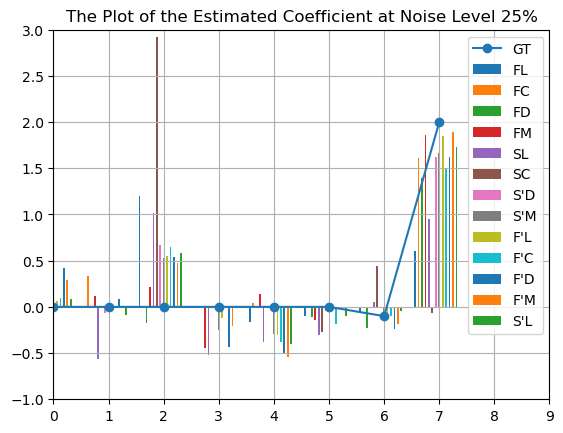

In [17]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_025_nl_1,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_025_nl_1,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_025_nl_1)*np.array(fd_BR_DSS_025_nl_1_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_025_nl_1)*np.array(fd_BR_MDSS_025_nl_1_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_025_nl_1),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_025_nl_1,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_deBR_DSS_025_nl_1)*np.array(spline_deBR_DSS_025_nl_1_Z),label= "S'D",width=1/32)
plt.bar(x,np.array(spline_deBR_MDSS_025_nl_1)*np.array(spline_deBR_MDSS_025_nl_1_Z),label= "S'M",width=1/32)
plt.bar(x+1/16,fd_dels_025_nl_1,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_025_nl_1,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_025_nl_1)*np.array(fd_deBR_DSS_025_nl_1_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_025_nl_1)*np.array(fd_deBR_MDSS_025_nl_1_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_025_nl_1,label= "S'L",width=1/32)
# plt.bar(x+6/16,spline_BR_CSS_025_nl_1,label= "SC",width=1/32)
plt.plot(nonlinear_1, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 25%')
plt.xlim(0,9)
plt.ylim(-1,3)
plt.legend()
plt.grid()

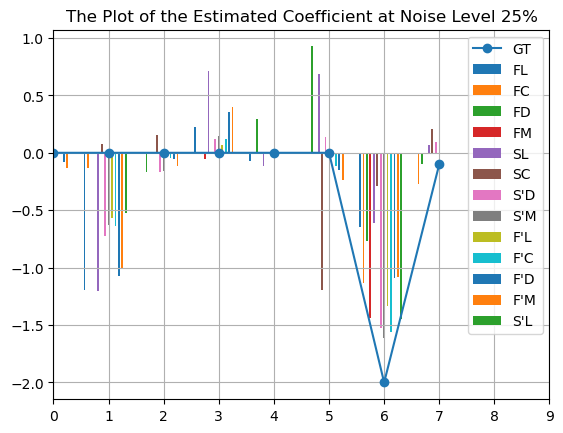

In [21]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_025_nl_2,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_025_nl_2,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_025_nl_2)*np.array(fd_BR_DSS_025_nl_2_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_025_nl_2)*np.array(fd_BR_MDSS_025_nl_2_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_025_nl_2),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_025_nl_2,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_deBR_DSS_025_nl_2)*np.array(spline_deBR_DSS_025_nl_2_Z),label= "S'D",width=1/32)
plt.bar(x,np.array(spline_deBR_MDSS_025_nl_2)*np.array(spline_deBR_MDSS_025_nl_2_Z),label= "S'M",width=1/32)
plt.bar(x+1/16,fd_dels_025_nl_2,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_025_nl_2,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_025_nl_2)*np.array(fd_deBR_DSS_025_nl_2_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_025_nl_2)*np.array(fd_deBR_MDSS_025_nl_2_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_025_nl_2,label= "S'L",width=1/32)
# plt.bar(x+6/16,spline_deBR_CSS_001_nl_2,label= "S'C",width=1/32)
plt.plot(nonlinear_2, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 25%')
plt.xlim(0,9)
# plt.ylim()
plt.legend()
plt.grid()

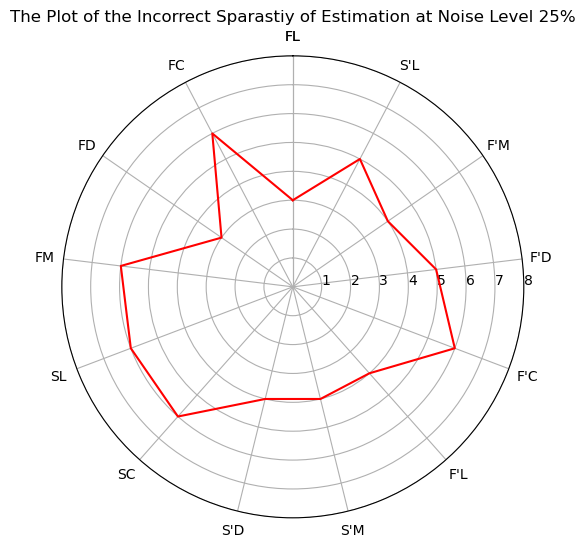

In [30]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_025_nl_1) != nonlinear_1_true), "FC": np.sum(cz(fd_BR_CSS_025_nl_1)!= nonlinear_1_true)
        , "FD": np.sum(cz(fd_BR_DSS_025_nl_1_Z)!= nonlinear_1_true)
        , "FM": np.sum(cz(fd_BR_MDSS_025_nl_1_Z)!= nonlinear_1_true), "SL": np.sum(cz(spline_ls_025_nl_1)!= nonlinear_1_true)
        , "SC": np.sum(cz(fd_BR_CSS_025_nl_1)!= nonlinear_1_true), "S'D": np.sum(cz(spline_deBR_DSS_025_nl_1_Z)!= nonlinear_1_true)
        , "S'M": np.sum(cz(spline_deBR_MDSS_025_nl_1_Z)!= nonlinear_1_true)
        ,"F'L": np.sum(cz(fd_dels_025_nl_1)!= nonlinear_1_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_025_nl_1)!= nonlinear_1_true), "F'D": np.sum(cz(fd_deBR_DSS_025_nl_1_Z)!= nonlinear_1_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_025_nl_1_Z)!= nonlinear_1_true)
        , "S'L": np.sum(cz(spline_dels_025_nl_1)!= nonlinear_1_true)}#, "S'C": np.sum(cz(spline_deBR_CSS_025_nl_1)!= nonlinear_1_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 25%')
ax.set_rlim(0, 8)
ax.set_rlabel_position(270)



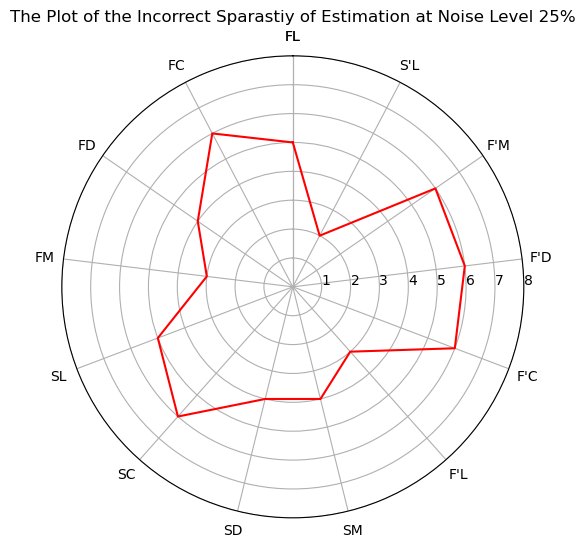

In [31]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_025_nl_2) != nonlinear_2_true), "FC": np.sum(cz(fd_BR_CSS_025_nl_2)!= nonlinear_2_true)
        , "FD": np.sum(cz(fd_BR_DSS_025_nl_2_Z)!= nonlinear_2_true)
        , "FM": np.sum(cz(fd_BR_MDSS_025_nl_2_Z)!= nonlinear_2_true), "SL": np.sum(cz(spline_ls_025_nl_2)!= nonlinear_2_true)
        , "SC": np.sum(cz(fd_BR_CSS_025_nl_2)!= nonlinear_2_true), "SD": np.sum(cz(spline_deBR_DSS_025_nl_2_Z)!= nonlinear_2_true)
        , "SM": np.sum(cz(spline_deBR_MDSS_025_nl_2_Z)!= nonlinear_2_true)
        ,"F'L": np.sum(cz(fd_dels_025_nl_2)!= nonlinear_2_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_025_nl_2)!= nonlinear_2_true), "F'D": np.sum(cz(fd_deBR_DSS_025_nl_2_Z)!= nonlinear_2_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_025_nl_2_Z)!= nonlinear_2_true)
        , "S'L": np.sum(cz(spline_dels_025_nl_2)!= nonlinear_2_true)}#, "S'C": np.sum(cz(spline_deBR_CSS_025_nl_2)!= nonlinear_2_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 25%')
ax.set_rlim(0, 8)
ax.set_rlabel_position(270)


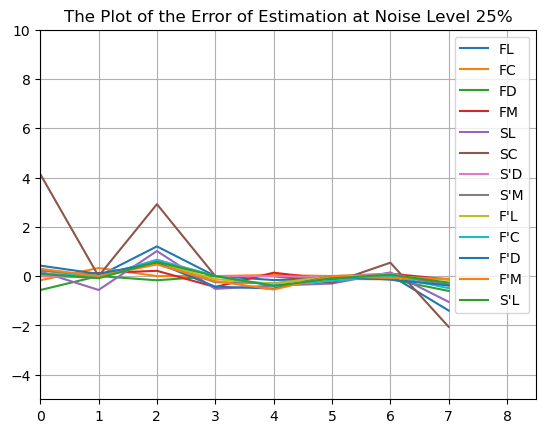

In [40]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(nonlinear_1)
#noise000 two_compartment_1
plt.plot(fd_ls_025_nl_1-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_025_nl_1)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_025_nl_1)*np.array(fd_BR_DSS_025_nl_1_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_025_nl_1)*np.array(fd_BR_MDSS_025_nl_1_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_025_nl_1-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_025_nl_1)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_deBR_DSS_025_nl_1)*np.array(spline_deBR_DSS_025_nl_1_Z)-nonlinear_1,label= "S'D")
plt.plot(np.array(spline_deBR_MDSS_025_nl_1)*np.array(spline_deBR_MDSS_025_nl_1_Z)-nonlinear_1,label= "S'M")
plt.plot(fd_dels_025_nl_1-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_025_nl_1)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_025_nl_1)*np.array(fd_deBR_DSS_025_nl_1_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_025_nl_1)*np.array(fd_deBR_MDSS_025_nl_1_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_025_nl_1-nonlinear_1,label= "S'L")
# plt.plot(spline_deBR_CSS_025_nl_1-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 25%')
plt.xlabel('')
plt.ylim(-5,10)
plt.xlim(0,8.5)
plt.legend()
plt.grid()

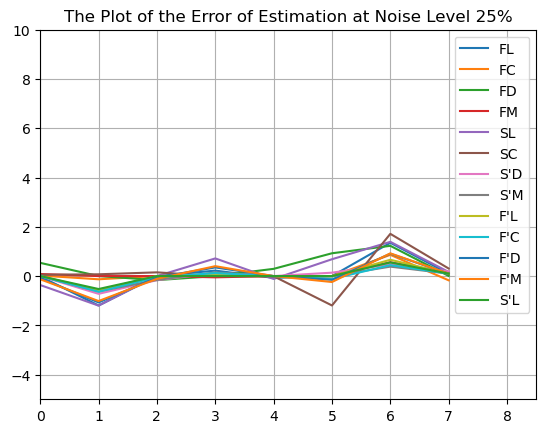

In [41]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_2 = np.array(nonlinear_2)
#noise000 two_compartment_1
plt.plot(fd_ls_025_nl_2-nonlinear_2,label= "FL")
plt.plot(np.array(fd_BR_CSS_025_nl_2)-nonlinear_2,label= "FC")
plt.plot(np.array(fd_BR_DSS_025_nl_2)*np.array(fd_BR_DSS_025_nl_2_Z)-nonlinear_2,label= "FD")
plt.plot(np.array(fd_BR_MDSS_025_nl_2)*np.array(fd_BR_MDSS_025_nl_2_Z)-nonlinear_2,label= "FM")
plt.plot(spline_ls_025_nl_2-nonlinear_2,label= "SL")
plt.plot(np.array(spline_BR_CSS_025_nl_2)-nonlinear_2,label= "SC")
plt.plot(np.array(spline_deBR_DSS_025_nl_2)*np.array(spline_deBR_DSS_025_nl_2_Z)-nonlinear_2,label= "S'D")
plt.plot(np.array(spline_deBR_MDSS_025_nl_2)*np.array(spline_deBR_MDSS_025_nl_2_Z)-nonlinear_2,label= "S'M")
plt.plot(fd_dels_025_nl_2-nonlinear_2,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_025_nl_2)-nonlinear_2,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_025_nl_2)*np.array(fd_deBR_DSS_025_nl_2_Z)-nonlinear_2,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_025_nl_2)*np.array(fd_deBR_MDSS_025_nl_2_Z)-nonlinear_2,label= "F'M")
plt.plot(spline_dels_025_nl_2-nonlinear_2,label= "S'L")
# plt.plot(spline_deBR_CSS_025_nl_2-nonlinear_2,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 25%')
plt.xlabel('')
plt.ylim(-5,10)
plt.xlim(0,8.5)
plt.legend()
plt.grid()

In [10]:
import numpy as np

# we want to get all np.array objects with name 'arr_name'
name = '000_lr_1'

# first, get all variables in the global scope
global_vars = globals()

# then, filter the variables by name
p = '000_lr_1_Z'
target_dict = {var_name: var for var_name, var in global_vars.items() 
               if var_name.endswith(name) and (isinstance(var, np.ndarray) or isinstance(var, list))}
# now, target_vars contains all np.array objects with the specified name
dict = {}
# &FL&FC&FD&FM&SL&SC&SD&SM&F'L&F'C&F'D&F'M&S'L&S'C&S'D&S'M
p_dict = {}
for var_name, var in global_vars.items():
    if var_name.startswith("fd_BR_DSS"):
        if var_name.endswith(p):
            p_dict[var_name] =np.array(var)
    elif var_name.startswith("fd_BR_MDSS"):
        if var_name.endswith(p):
            p_dict[var_name] = np.array(var)

    elif var_name.startswith("spline_BR_DSS"):
        if var_name.endswith(p):
            p_dict[var_name] = np.array(var)
    elif var_name.startswith("spline_BR_MDSS"):
        if var_name.endswith(p):
            p_dict[var_name] = np.array(var)

for var_name, var in global_vars.items():
    if var_name.startswith("fd_ls"):
        if var_name.endswith(name):
            dict[var_name] = var
    elif var_name.startswith("fd_BR_CSS"):
        if var_name.endswith(name):
            dict[var_name] = np.array(var)
    elif var_name.startswith("fd_BR_DSS"):
        if var_name.endswith(name):
            for i in p_dict.keys():
                if  "fd_BR_DSS" in i:
                    p = p_dict[i]
            dict[var_name] = np.array(var)*p
    elif var_name.startswith("fd_BR_MDSS"):
        if var_name.endswith(name):
            for i in p_dict.keys():
                if  "fd_BR_MDSS" in i:
                    p = p_dict[i]
            dict[var_name] = np.array(var)*p
    elif var_name.startswith("spline_ls"):
        if var_name.endswith(name):
            dict[var_name] = var
    elif var_name.startswith("spline_BR_CSS"):
        if var_name.endswith(name):
            dict[var_name] = var
    elif var_name.startswith("spline_BR_DSS"):
        if var_name.endswith(name):
            for i in p_dict.keys():
                if  "spline_BR_DSS" in i:
                    p = p_dict[i]
            dict[var_name] = np.array(var)*p
    elif var_name.startswith("spline_BR_MDSS"):
        if var_name.endswith(name):
            for i in p_dict.keys():
                if  "spline_BR_MDSS" in i:
                    p = p_dict[i]
            dict[var_name] = np.array(var)*p


print(dict.keys())
# Get the length of the lists
list_length = len(next(iter(dict.values())))

# Loop over the length of the lists
for i in range(list_length):
    # For each key, get the i-th element of the list and add it to a list
    elements = [float('%.2g'%values[i]) for values in dict.values()]
    elements = list(map(str, elements))
    
    # Join the elements with "&" and print
    print(" & ".join(elements))

    

dict_keys(['spline_BR_CSS_000_lr_1', 'spline_BR_DSS_000_lr_1', 'spline_BR_MDSS_000_lr_1', 'fd_BR_CSS_000_lr_1', 'fd_BR_DSS_000_lr_1', 'fd_BR_MDSS_000_lr_1', 'fd_ls_000_lr_1', 'spline_ls_000_lr_1'])
-3e-10 & -0.0 & 0.0 & -4.8e-05 & 0.0 & -0.0 & 0.0 & -1.1
-10.0 & -10.0 & -10.0 & -10.0 & -9.9 & -9.9 & -9.9 & -9.1
10.0 & 10.0 & 10.0 & 10.0 & 10.0 & 10.0 & 10.0 & 9.6
-1e-05 & 0.0 & 0.0 & 0.018 & -0.0 & 0.0 & 0.013 & 0.16
-2.8e-05 & 0.0 & -0.0 & -0.025 & -0.0019 & -0.0 & -0.023 & 0.045
1.1e-06 & 0.0 & -0.0 & -0.0011 & -0.002 & -0.0 & 0.00052 & 0.029
2.8e-06 & -0.0 & -0.0 & -0.00013 & -0.0 & -0.0 & 0.00044 & -0.0076
7.4e-06 & -0.0 & -0.0 & 0.0032 & 0.0042 & 0.0 & 0.0 & -0.083
-1.7e-07 & 0.0 & -0.0 & -1.2e-06 & -0.0021 & -0.0027 & -0.0035 & -0.03
6.4e-06 & 0.0 & -0.0 & -1.4e-08 & 0.0 & -0.0 & 0.00085 & 0.005
-3.3e-07 & 0.0 & -0.0 & -2.2e-06 & 0.00012 & 0.0002 & 0.00019 & 0.0019
-1.2e-10 & -0.0 & 0.0 & -1.3e-06 & -0.0 & 0.0 & -3.4e-05 & -0.00031
4.7e-09 & -0.0 & -0.0 & -0.00015 & -0.0 & 0.0 & 

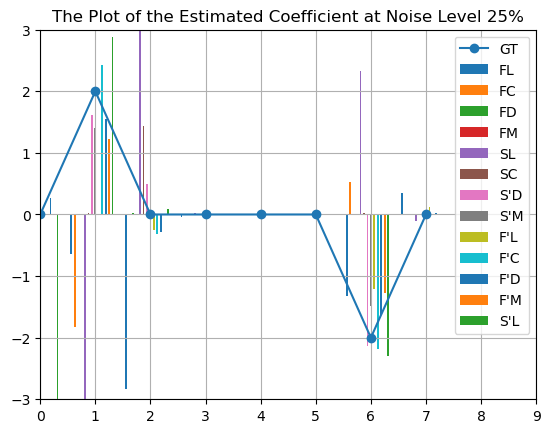

In [60]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_025_tc_1,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_025_tc_1,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_025_tc_1)*np.array(fd_BR_DSS_025_tc_1_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_025_tc_1)*np.array(fd_BR_MDSS_025_tc_1_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_025_tc_1),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_025_tc_1,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_deBR_DSS_025_tc_1)*np.array(spline_deBR_DSS_025_tc_1_Z),label= "S'D",width=1/32)
plt.bar(x,np.array(spline_deBR_MDSS_025_tc_1)*np.array(spline_deBR_MDSS_025_tc_1_Z),label= "S'M",width=1/32)
plt.bar(x+1/16,fd_dels_025_tc_1,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_025_tc_1,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_025_tc_1)*np.array(fd_deBR_DSS_025_tc_1_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_025_tc_1)*np.array(fd_deBR_MDSS_025_tc_1_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_025_tc_1,label= "S'L",width=1/32)
# plt.bar(x+6/16,spline_deBR_CSS_025_tc_1,label= "S'C",width=1/32)
plt.plot(two_compartment_1, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 25%')
plt.xlim(0,9)
plt.ylim(-3,3)
plt.legend()
plt.grid()

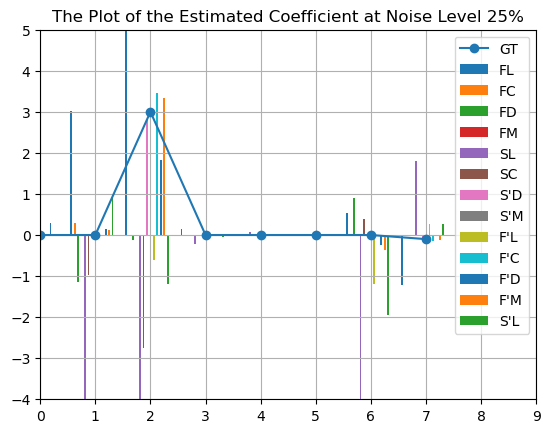

In [64]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_025_tc_2,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_025_tc_2,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_025_tc_2)*np.array(fd_BR_DSS_025_tc_2_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_025_tc_2)*np.array(fd_BR_MDSS_025_tc_2_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_025_tc_2),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_025_tc_2,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_deBR_DSS_025_tc_2)*np.array(spline_deBR_DSS_025_tc_2_Z),label= "S'D",width=1/32)
plt.bar(x,np.array(spline_deBR_MDSS_025_tc_2)*np.array(spline_deBR_MDSS_025_tc_2_Z),label= "S'M",width=1/32)
plt.bar(x+1/16,fd_dels_025_tc_2,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_025_tc_2,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_025_tc_2)*np.array(fd_deBR_DSS_025_tc_2_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_025_tc_2)*np.array(fd_deBR_MDSS_025_tc_2_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_025_tc_2,label= "S'L",width=1/32)
# plt.bar(x+6/16,spline_deBR_CSS_025_tc_2,label= "S'C",width=1/32)
plt.plot(two_compartment_2, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 25%')
plt.xlim(0,9)
plt.ylim(-4,5)
plt.legend()
plt.grid()

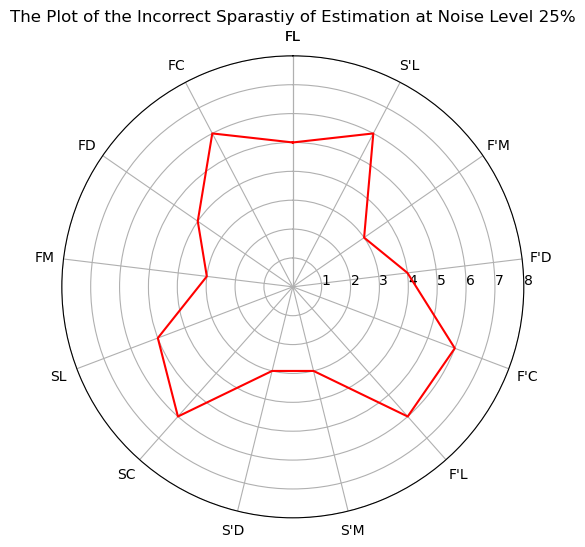

In [68]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_025_tc_1) != twocompart_1_true), "FC": np.sum(cz(fd_BR_CSS_025_tc_1)!= twocompart_1_true)
        , "FD": np.sum(cz(fd_BR_DSS_025_tc_1_Z)!= twocompart_1_true)
        , "FM": np.sum(cz(fd_BR_MDSS_025_tc_1_Z)!= twocompart_1_true), "SL": np.sum(cz(spline_ls_025_tc_1)!= twocompart_1_true)
        , "SC": np.sum(cz(fd_BR_CSS_025_tc_1)!= twocompart_1_true), "S'D": np.sum(cz(spline_deBR_DSS_025_tc_1_Z)!= twocompart_1_true)
        , "S'M": np.sum(cz(spline_deBR_MDSS_025_tc_1_Z)!= twocompart_1_true)
        ,"F'L": np.sum(cz(fd_dels_025_tc_1)!= twocompart_1_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_025_tc_1)!= twocompart_1_true), "F'D": np.sum(cz(fd_deBR_DSS_025_tc_1_Z)!= twocompart_1_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_025_tc_1_Z)!= twocompart_1_true)
        , "S'L": np.sum(cz(spline_dels_025_tc_1)!= twocompart_1_true)}#, "S'C": np.sum(cz(spline_deBR_CSS_001_tc_1)!= twocompart_1_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 25%')
ax.set_rlim(0, 8)
ax.set_rlabel_position(270)



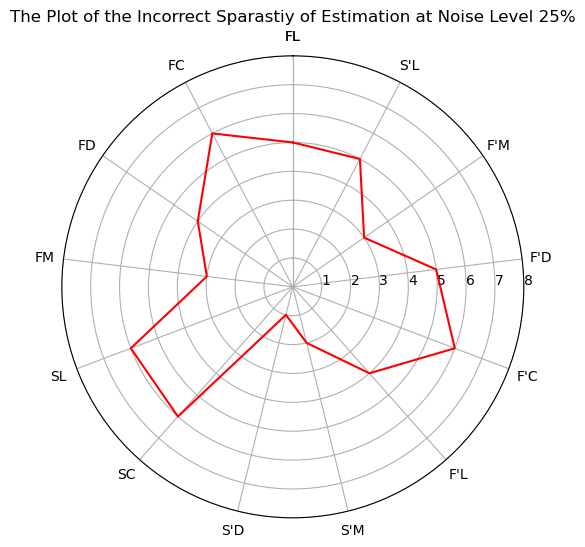

In [71]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_025_tc_2) != twocompart_2_true), "FC": np.sum(cz(fd_BR_CSS_025_tc_2)!= twocompart_2_true)
        , "FD": np.sum(cz(fd_BR_DSS_025_tc_2_Z)!= twocompart_2_true)
        , "FM": np.sum(cz(fd_BR_MDSS_025_tc_2_Z)!= twocompart_2_true), "SL": np.sum(cz(spline_ls_025_tc_2)!= twocompart_2_true)
        , "SC": np.sum(cz(spline_BR_CSS_025_tc_2)!= twocompart_2_true), "S'D": np.sum(cz(spline_deBR_DSS_025_tc_2_Z)!= twocompart_2_true)
        , "S'M": np.sum(cz(spline_deBR_MDSS_025_tc_2_Z)!= twocompart_2_true)
        ,"F'L": np.sum(cz(fd_dels_025_tc_2)!= twocompart_2_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_025_tc_2)!= twocompart_2_true), "F'D": np.sum(cz(fd_deBR_DSS_025_tc_2_Z)!= twocompart_2_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_025_tc_2_Z)!= twocompart_2_true)
        , "S'L": np.sum(cz(spline_dels_025_tc_2)!= twocompart_2_true)}#, "S'C": np.sum(cz(spline_deBR_CSS_001_tc_2)!=twocompart_2_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 25%')
ax.set_rlim(0, 8)
ax.set_rlabel_position(270)



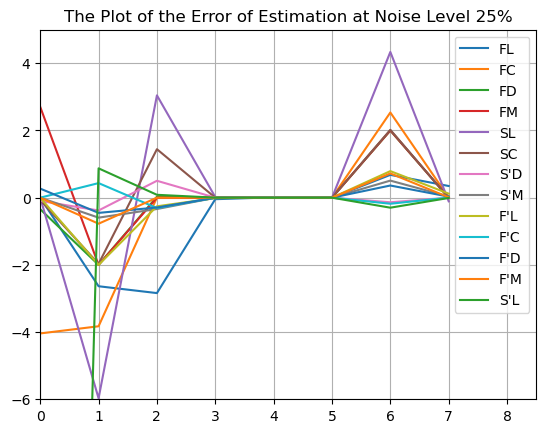

In [81]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(two_compartment_1)
#noise000 two_compartment_1
plt.plot(fd_ls_025_tc_1-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_025_tc_1)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_025_tc_1)*np.array(fd_BR_DSS_025_tc_1_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_025_tc_1)*np.array(fd_BR_MDSS_025_tc_1_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_025_tc_1-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_025_tc_1)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_deBR_DSS_025_tc_1)*np.array(spline_deBR_DSS_025_tc_1_Z)-nonlinear_1,label= "S'D")
plt.plot(np.array(spline_deBR_MDSS_025_tc_1)*np.array(spline_deBR_MDSS_025_tc_1_Z)-nonlinear_1,label= "S'M")
plt.plot(fd_dels_025_tc_1-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_025_tc_1)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_025_tc_1)*np.array(fd_deBR_DSS_025_tc_1_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_025_tc_1)*np.array(fd_deBR_MDSS_025_tc_1_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_025_tc_1-nonlinear_1,label= "S'L")
# plt.plot(spline_deBR_CSS_025_tc_1-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 25%')
plt.xlabel('')
plt.ylim(-6,5)
plt.xlim(0,8.5)
plt.legend()
plt.grid()

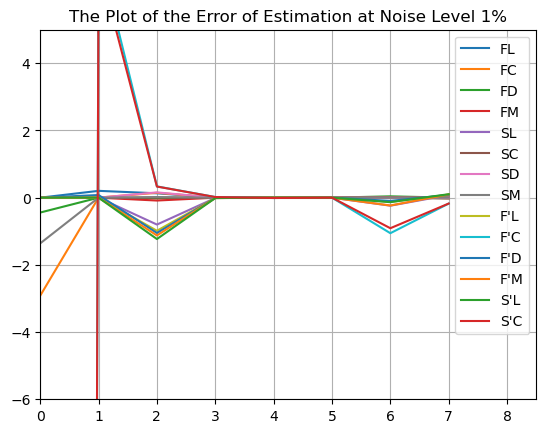

In [88]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(two_compartment_2)
#noise000 two_compartment_1
plt.plot(fd_ls_001_tc_2-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_001_tc_2)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_001_tc_2)*np.array(fd_BR_DSS_001_tc_2_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_001_tc_2)*np.array(fd_BR_MDSS_001_tc_2_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_001_tc_2-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_001_tc_2)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_BR_DSS_001_tc_2)*np.array(spline_BR_DSS_001_tc_2_Z)-nonlinear_1,label= "SD")
plt.plot(np.array(spline_BR_MDSS_001_tc_2)*np.array(spline_BR_MDSS_001_tc_2_Z)-nonlinear_1,label= "SM")
plt.plot(fd_dels_001_tc_2-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_001_tc_2)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_001_tc_2)*np.array(fd_deBR_DSS_001_tc_2_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_001_tc_2)*np.array(fd_deBR_MDSS_001_tc_2_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_001_tc_2-nonlinear_1,label= "S'L")
plt.plot(spline_deBR_CSS_001_tc_2-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 1%')
plt.xlabel('')
plt.ylim(-6,5)
plt.xlim(0,8.5)
plt.legend()
plt.grid()

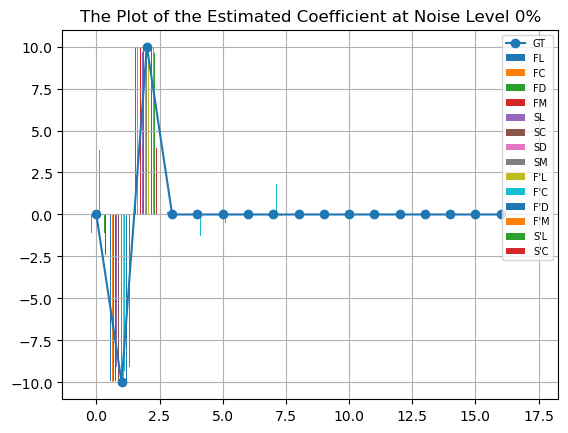

In [110]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7,8,9,10,11,12,14,15,16,17])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_000_lr_1,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_000_lr_1,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_000_lr_1)*np.array(fd_BR_DSS_000_lr_1_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_000_lr_1)*np.array(fd_BR_MDSS_000_lr_1_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_000_lr_1),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_000_lr_1,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_BR_DSS_000_lr_1)*np.array(spline_BR_DSS_000_lr_1_Z),label= "SD",width=1/32)
plt.bar(x,np.array(spline_BR_MDSS_000_lr_1)*np.array(spline_BR_MDSS_000_lr_1_Z),label= "SM",width=1/32)
plt.bar(x+1/16,fd_dels_000_lr_1,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_000_lr_1,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_000_lr_1)*np.array(fd_deBR_DSS_000_lr_1_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_000_lr_1)*np.array(fd_deBR_MDSS_000_lr_1_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_000_lr_1,label= "S'L",width=1/32)
plt.bar(x+6/16,spline_deBR_CSS_000_lr_1,label= "S'C",width=1/32)
plt.plot(lorenz_1, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 0%')
# plt.xlim(0,19)
# plt.ylim(-3,3)
plt.legend(fontsize = 7)
plt.grid()

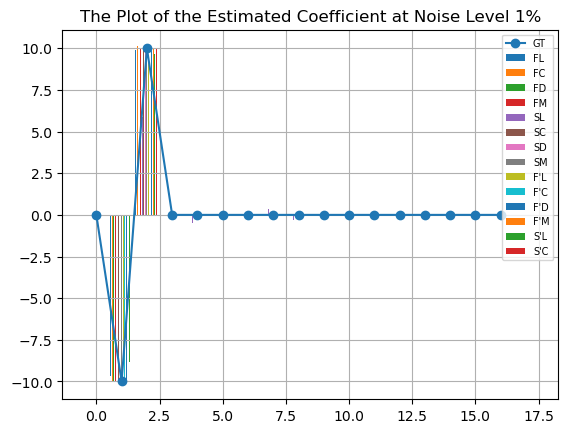

In [111]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7,8,9,10,11,12,14,15,16,17])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_001_lr_1,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_001_lr_1,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_001_lr_1)*np.array(fd_BR_DSS_001_lr_1_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_001_lr_1)*np.array(fd_BR_MDSS_001_lr_1_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_001_lr_1),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_001_lr_1,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_BR_DSS_001_lr_1)*np.array(spline_BR_DSS_001_lr_1_Z),label= "SD",width=1/32)
plt.bar(x,np.array(spline_BR_MDSS_001_lr_1)*np.array(spline_BR_MDSS_001_lr_1_Z),label= "SM",width=1/32)
plt.bar(x+1/16,fd_dels_001_lr_1,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_001_lr_1,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_001_lr_1)*np.array(fd_deBR_DSS_001_lr_1_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_001_lr_1)*np.array(fd_deBR_MDSS_001_lr_1_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_001_lr_1,label= "S'L",width=1/32)
plt.bar(x+6/16,spline_deBR_CSS_001_lr_1,label= "S'C",width=1/32)
plt.plot(lorenz_1, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 1%')
# plt.xlim(0,18)
# plt.ylim(-3,3)
plt.legend(fontsize = 7)
plt.grid()

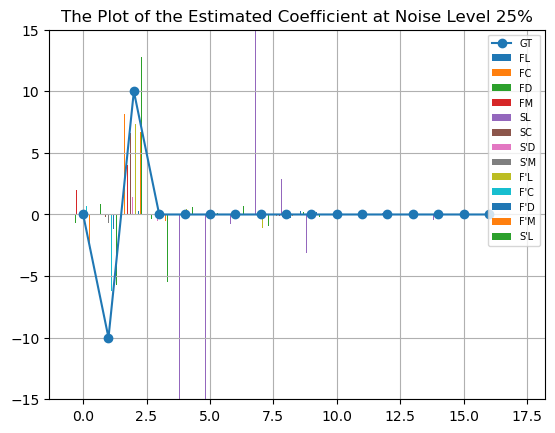

In [126]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7,8,9,10,11,12,14,15,16,17])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_025_lr_1,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_025_lr_1,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_025_lr_1)*np.array(fd_BR_DSS_025_lr_1_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_025_lr_1)*np.array(fd_BR_MDSS_025_lr_1_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_025_lr_1),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_025_lr_1,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_deBR_DSS_025_lr_1)*np.array(spline_deBR_DSS_025_lr_1_Z),label= "S'D",width=1/32)
plt.bar(x,np.array(spline_deBR_MDSS_025_lr_1)*np.array(spline_deBR_MDSS_025_lr_1_Z),label= "S'M",width=1/32)
plt.bar(x+1/16,fd_dels_025_lr_1,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_025_lr_1,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_025_lr_1)*np.array(fd_deBR_DSS_025_lr_1_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_025_lr_1)*np.array(fd_deBR_MDSS_025_lr_1_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_025_lr_1,label= "S'L",width=1/32)
# plt.bar(x+6/16,spline_deBR_CSS_025_lr_1,label= "S'C",width=1/32)
plt.plot(lorenz_1, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 25%')
# plt.xlim(0,9)
plt.ylim(-15,15)
plt.legend(fontsize=7)
plt.grid()

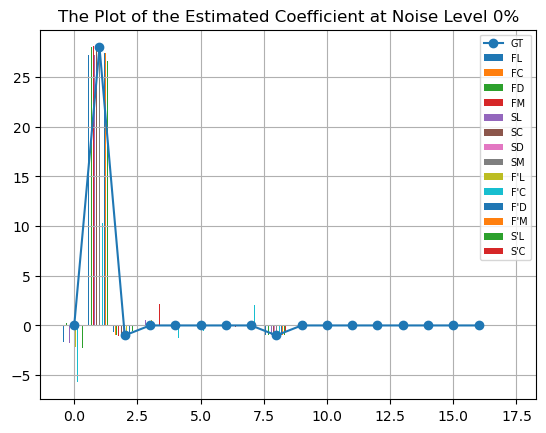

In [115]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7,8,9,10,11,12,14,15,16,17])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_000_lr_2,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_000_lr_2,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_000_lr_2)*np.array(fd_BR_DSS_000_lr_2_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_000_lr_2)*np.array(fd_BR_MDSS_000_lr_2_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_000_lr_2),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_000_lr_2,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_BR_DSS_000_lr_2)*np.array(spline_BR_DSS_000_lr_2_Z),label= "SD",width=1/32)
plt.bar(x,np.array(spline_BR_MDSS_000_lr_2)*np.array(spline_BR_MDSS_000_lr_2_Z),label= "SM",width=1/32)
plt.bar(x+1/16,fd_dels_000_lr_2,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_000_lr_2,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_000_lr_2)*np.array(fd_deBR_DSS_000_lr_2_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_000_lr_2)*np.array(fd_deBR_MDSS_000_lr_2_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_000_lr_2,label= "S'L",width=1/32)
plt.bar(x+6/16,spline_deBR_CSS_000_lr_2,label= "S'C",width=1/32)
plt.plot(lorenz_2, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 0%')
# plt.xlim(0,19)
# plt.ylim(-3,3)
plt.legend(fontsize = 7)
plt.grid()

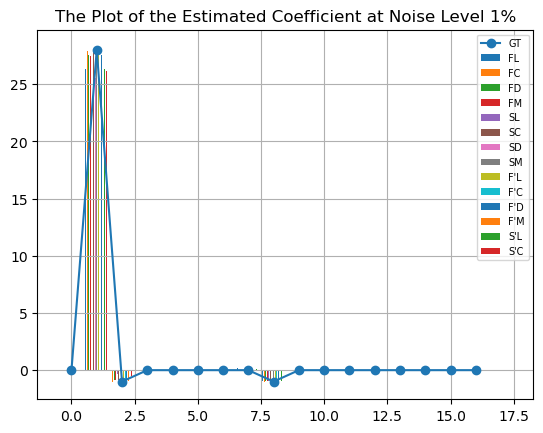

In [116]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7,8,9,10,11,12,14,15,16,17])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_001_lr_2,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_001_lr_2,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_001_lr_2)*np.array(fd_BR_DSS_001_lr_2_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_001_lr_2)*np.array(fd_BR_MDSS_001_lr_2_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_001_lr_2),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_001_lr_2,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_BR_DSS_001_lr_2)*np.array(spline_BR_DSS_001_lr_2_Z),label= "SD",width=1/32)
plt.bar(x,np.array(spline_BR_MDSS_001_lr_2)*np.array(spline_BR_MDSS_001_lr_2_Z),label= "SM",width=1/32)
plt.bar(x+1/16,fd_dels_001_lr_2,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_001_lr_2,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_001_lr_2)*np.array(fd_deBR_DSS_001_lr_2_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_001_lr_2)*np.array(fd_deBR_MDSS_001_lr_2_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_001_lr_2,label= "S'L",width=1/32)
plt.bar(x+6/16,spline_deBR_CSS_001_lr_2,label= "S'C",width=1/32)
plt.plot(lorenz_2, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 1%')
# plt.xlim(0,18)
# plt.ylim(-3,3)
plt.legend(fontsize = 7)
plt.grid()

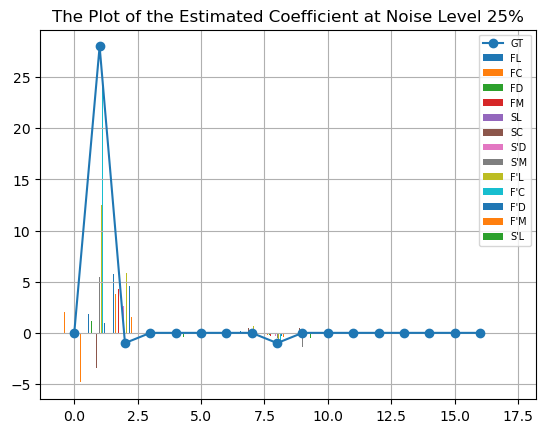

In [118]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7,8,9,10,11,12,14,15,16,17])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_025_lr_2,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_025_lr_2,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_025_lr_2)*np.array(fd_BR_DSS_025_lr_2_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_025_lr_2)*np.array(fd_BR_MDSS_025_lr_2_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_025_lr_2),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_025_lr_2,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_deBR_DSS_025_lr_2)*np.array(spline_deBR_DSS_025_lr_2_Z),label= "S'D",width=1/32)
plt.bar(x,np.array(spline_deBR_MDSS_025_lr_2)*np.array(spline_deBR_MDSS_025_lr_2_Z),label= "S'M",width=1/32)
plt.bar(x+1/16,fd_dels_025_lr_2,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_025_lr_2,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_025_lr_2)*np.array(fd_deBR_DSS_025_lr_2_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_025_lr_2)*np.array(fd_deBR_MDSS_025_lr_2_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_025_lr_2,label= "S'L",width=1/32)
# plt.bar(x+6/16,spline_deBR_CSS_025_lr_1,label= "S'C",width=1/32)
plt.plot(lorenz_2, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 25%')
# plt.xlim(0,9)
# plt.ylim(-3,3)
plt.legend(fontsize=7)
plt.grid()

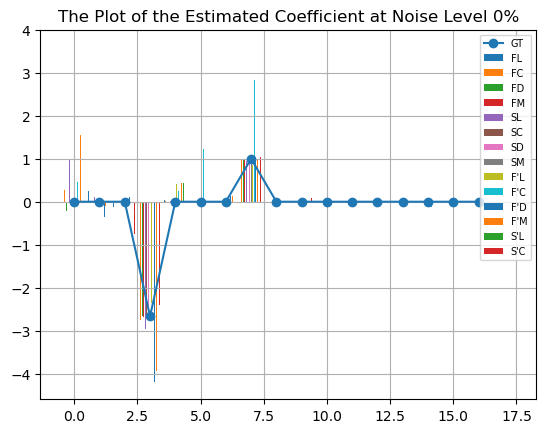

In [121]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7,8,9,10,11,12,14,15,16,17])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_000_lr_3,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_000_lr_3,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_000_lr_3)*np.array(fd_BR_DSS_000_lr_3_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_000_lr_3)*np.array(fd_BR_MDSS_000_lr_3_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_000_lr_3),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_000_lr_3,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_BR_DSS_000_lr_3)*np.array(spline_BR_DSS_000_lr_3_Z),label= "SD",width=1/32)
plt.bar(x,np.array(spline_BR_MDSS_000_lr_3)*np.array(spline_BR_MDSS_000_lr_3_Z),label= "SM",width=1/32)
plt.bar(x+1/16,fd_dels_000_lr_3,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_000_lr_3,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_000_lr_3)*np.array(fd_deBR_DSS_000_lr_3_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_000_lr_3)*np.array(fd_deBR_MDSS_000_lr_3_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_000_lr_3,label= "S'L",width=1/32)
plt.bar(x+6/16,spline_deBR_CSS_000_lr_3,label= "S'C",width=1/32)
plt.plot(lorenz_3, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 0%')
# plt.xlim(0,19)
# plt.ylim(-3,3)
plt.legend(fontsize = 7)
plt.grid()

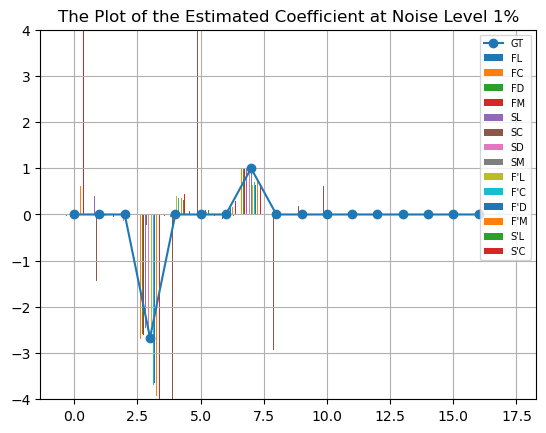

In [123]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7,8,9,10,11,12,14,15,16,17])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_001_lr_3,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_001_lr_3,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_001_lr_3)*np.array(fd_BR_DSS_001_lr_3_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_001_lr_3)*np.array(fd_BR_MDSS_001_lr_3_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_001_lr_3),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_001_lr_3,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_BR_DSS_001_lr_3)*np.array(spline_BR_DSS_001_lr_3_Z),label= "SD",width=1/32)
plt.bar(x,np.array(spline_BR_MDSS_001_lr_3)*np.array(spline_BR_MDSS_001_lr_3_Z),label= "SM",width=1/32)
plt.bar(x+1/16,fd_dels_001_lr_3,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_001_lr_3,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_001_lr_3)*np.array(fd_deBR_DSS_001_lr_3_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_001_lr_3)*np.array(fd_deBR_MDSS_001_lr_3_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_001_lr_3,label= "S'L",width=1/32)
plt.bar(x+6/16,spline_deBR_CSS_001_lr_3,label= "S'C",width=1/32)
plt.plot(lorenz_3, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 1%')
# plt.xlim(0,18)
plt.ylim(-4,4)
plt.legend(fontsize = 7)
plt.grid()

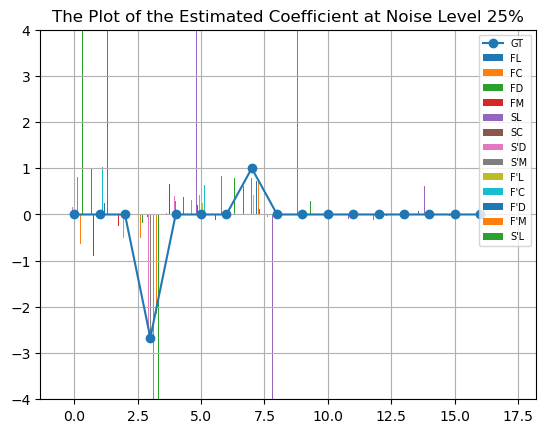

In [125]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array([0, 1, 2 , 3, 4, 5, 6, 7,8,9,10,11,12,14,15,16,17])

#noise000 two_compartment_1
plt.bar(x-7/16,fd_ls_025_lr_3,label= "FL",width=1/32)
plt.bar(x-6/16,fd_BR_CSS_025_lr_3,label= "FC",width=1/32)
plt.bar(x-5/16,np.array(fd_BR_DSS_025_lr_3)*np.array(fd_BR_DSS_025_lr_3_Z),label= "FD",width=1/32)
plt.bar(x-4/16,np.array(fd_BR_MDSS_025_lr_3)*np.array(fd_BR_MDSS_025_lr_3_Z),label= "FM",width=1/32)
plt.bar(x-3/16,np.array(spline_ls_025_lr_3),label= "SL",width=1/32)
plt.bar(x-2/16,spline_BR_CSS_025_lr_3,label= "SC",width=1/32)
plt.bar(x-1/16,np.array(spline_deBR_DSS_025_lr_3)*np.array(spline_deBR_DSS_025_lr_3_Z),label= "S'D",width=1/32)
plt.bar(x,np.array(spline_deBR_MDSS_025_lr_3)*np.array(spline_deBR_MDSS_025_lr_3_Z),label= "S'M",width=1/32)
plt.bar(x+1/16,fd_dels_025_lr_3,label= "F'L",width=1/32)
plt.bar(x+2/16,fd_deBR_CSS_025_lr_3,label= "F'C",width=1/32)
plt.bar(x+3/16,np.array(fd_deBR_DSS_025_lr_3)*np.array(fd_deBR_DSS_025_lr_3_Z),label= "F'D",width=1/32)
plt.bar(x+4/16,np.array(fd_deBR_MDSS_025_lr_3)*np.array(fd_deBR_MDSS_025_lr_3_Z),label= "F'M",width=1/32)
plt.bar(x+5/16,spline_dels_025_lr_3,label= "S'L",width=1/32)
# plt.bar(x+6/16,spline_deBR_CSS_025_lr_1,label= "S'C",width=1/32)
plt.plot(lorenz_3, label = "GT", marker =  "o")
# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Estimated Coefficient at Noise Level 25%')
# plt.xlim(0,9)
plt.ylim(-4,4)
plt.legend(fontsize=7)
plt.grid()

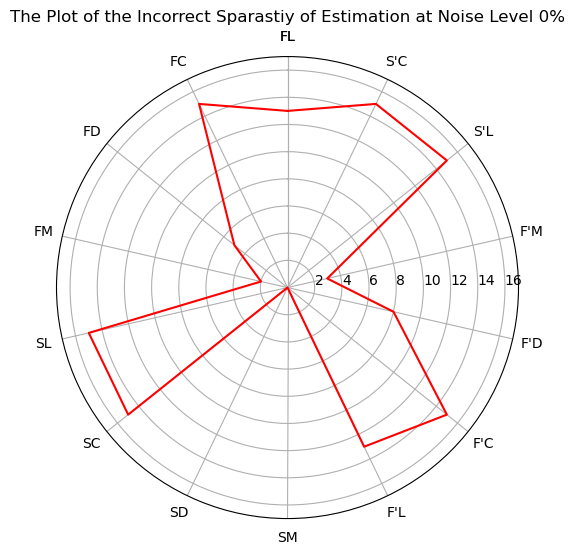

In [130]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_000_lr_1) != lorenz_1_true), "FC": np.sum(cz(fd_BR_CSS_000_lr_1)!= lorenz_1_true)
        , "FD": np.sum(cz(fd_BR_DSS_000_lr_1_Z)!= lorenz_1_true)
        , "FM": np.sum(cz(fd_BR_MDSS_000_lr_1_Z)!= lorenz_1_true), "SL": np.sum(cz(spline_ls_000_lr_1)!= lorenz_1_true)
        , "SC": np.sum(cz(fd_BR_CSS_000_lr_1)!= lorenz_1_true), "SD": np.sum(cz(spline_BR_DSS_000_lr_1_Z)!= lorenz_1_true)
        , "SM": np.sum(cz(spline_BR_MDSS_000_lr_1_Z)!= lorenz_1_true)
        ,"F'L": np.sum(cz(fd_dels_000_lr_1)!= lorenz_1_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_000_lr_1)!= lorenz_1_true), "F'D": np.sum(cz(fd_deBR_DSS_000_lr_1_Z)!= lorenz_1_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_000_lr_1_Z)!= lorenz_1_true)
        , "S'L": np.sum(cz(spline_dels_000_lr_1)!= lorenz_1_true), "S'C": np.sum(cz(spline_deBR_CSS_000_lr_1)!= lorenz_1_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 0%')
ax.set_rlim(0, 17)
ax.set_rlabel_position(270)

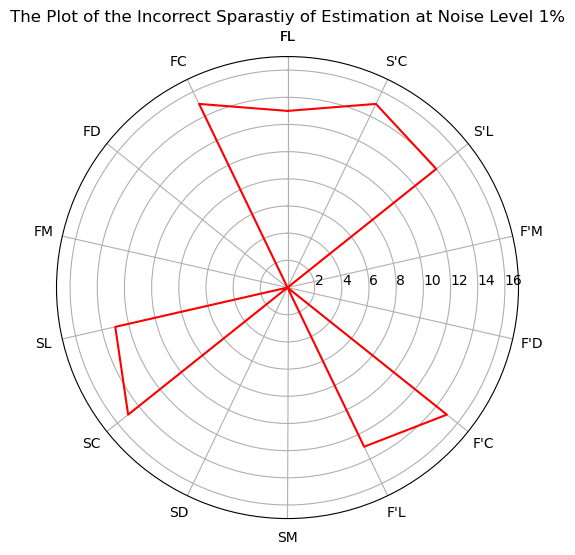

In [135]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_001_lr_1) != lorenz_1_true), "FC": np.sum(cz(fd_BR_CSS_001_lr_1)!= lorenz_1_true)
        , "FD": np.sum(cz(fd_BR_DSS_001_lr_1_Z)!= lorenz_1_true)
        , "FM": np.sum(cz(fd_BR_MDSS_001_lr_1_Z)!= lorenz_1_true), "SL": np.sum(cz(spline_ls_001_lr_1)!= lorenz_1_true)
        , "SC": np.sum(cz(fd_BR_CSS_001_lr_1)!= lorenz_1_true), "SD": np.sum(cz(spline_BR_DSS_001_lr_1_Z)!= lorenz_1_true)
        , "SM": np.sum(cz(spline_BR_MDSS_001_lr_1_Z)!= lorenz_1_true)
        ,"F'L": np.sum(cz(fd_dels_001_lr_1)!= lorenz_1_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_001_lr_1)!= lorenz_1_true), "F'D": np.sum(cz(fd_deBR_DSS_001_lr_1_Z)!= lorenz_1_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_001_lr_1_Z)!= lorenz_1_true)
        , "S'L": np.sum(cz(spline_dels_001_lr_1)!= lorenz_1_true), "S'C": np.sum(cz(spline_deBR_CSS_001_lr_1)!= lorenz_1_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 1%')
ax.set_rlim(0, 17)
ax.set_rlabel_position(270)

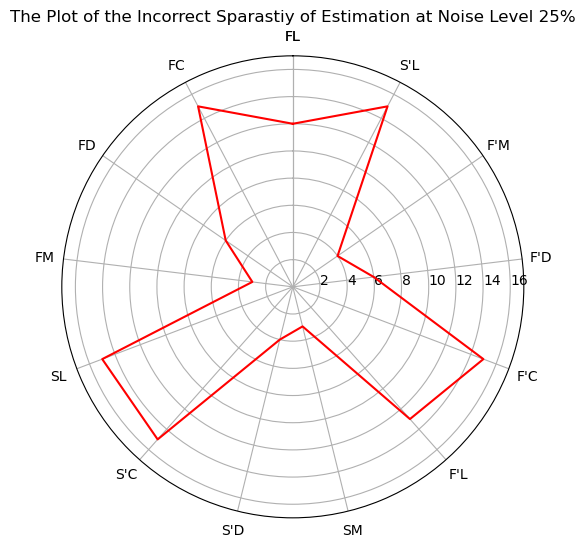

In [138]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_025_lr_1) != lorenz_1_true), "FC": np.sum(cz(fd_BR_CSS_025_lr_1)!= lorenz_1_true)
        , "FD": np.sum(cz(fd_BR_DSS_025_lr_1_Z)!= lorenz_1_true)
        , "FM": np.sum(cz(fd_BR_MDSS_025_lr_1_Z)!= lorenz_1_true), "SL": np.sum(cz(spline_ls_025_lr_1)!= lorenz_1_true)
        , "S'C": np.sum(cz(fd_BR_CSS_025_lr_1)!= lorenz_1_true), "S'D": np.sum(cz(spline_deBR_DSS_025_lr_1_Z)!= lorenz_1_true)
        , "SM": np.sum(cz(spline_deBR_MDSS_025_lr_1_Z)!= lorenz_1_true)
        ,"F'L": np.sum(cz(fd_dels_025_lr_1)!= lorenz_1_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_025_lr_1)!= lorenz_1_true), "F'D": np.sum(cz(fd_deBR_DSS_025_lr_1_Z)!= lorenz_1_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_025_lr_1_Z)!= lorenz_1_true)
        , "S'L": np.sum(cz(spline_dels_025_lr_1)!= lorenz_1_true)}#, "S'C": np.sum(cz(spline_deBR_CSS_025_lr_1)!= lorenz_1_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 25%')
ax.set_rlim(0, 17)
ax.set_rlabel_position(270)

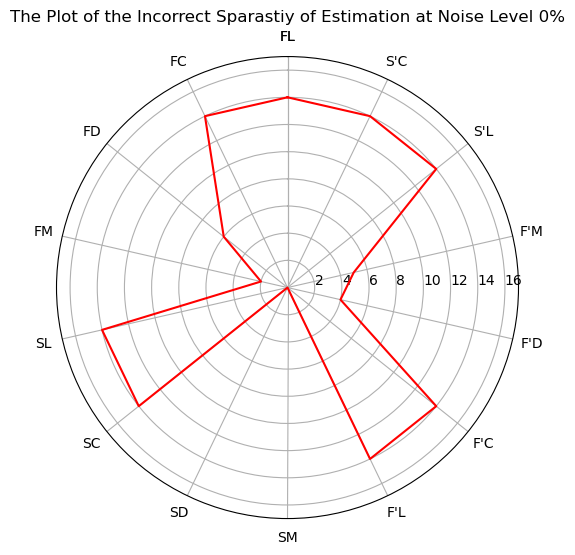

In [133]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_000_lr_2) != lorenz_2_true), "FC": np.sum(cz(fd_BR_CSS_000_lr_2)!= lorenz_2_true)
        , "FD": np.sum(cz(fd_BR_DSS_000_lr_2_Z)!= lorenz_2_true)
        , "FM": np.sum(cz(fd_BR_MDSS_000_lr_2_Z)!= lorenz_2_true), "SL": np.sum(cz(spline_ls_000_lr_2)!= lorenz_2_true)
        , "SC": np.sum(cz(fd_BR_CSS_000_lr_2)!= lorenz_2_true), "SD": np.sum(cz(spline_BR_DSS_000_lr_2_Z)!= lorenz_2_true)
        , "SM": np.sum(cz(spline_BR_MDSS_000_lr_2_Z)!= lorenz_2_true)
        ,"F'L": np.sum(cz(fd_dels_000_lr_2)!= lorenz_2_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_000_lr_2)!= lorenz_2_true), "F'D": np.sum(cz(fd_deBR_DSS_000_lr_2_Z)!= lorenz_2_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_000_lr_2_Z)!= lorenz_2_true)
        , "S'L": np.sum(cz(spline_dels_000_lr_2)!= lorenz_2_true), "S'C": np.sum(cz(spline_deBR_CSS_000_lr_2)!= lorenz_2_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 0%')
ax.set_rlim(0, 17)
ax.set_rlabel_position(270)

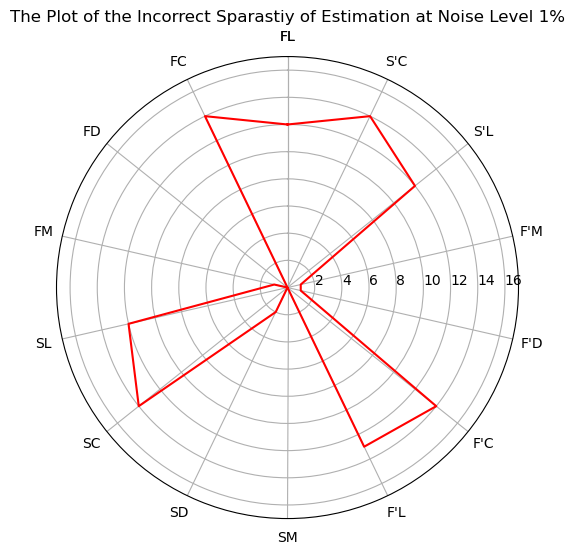

In [139]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_001_lr_2) != lorenz_2_true), "FC": np.sum(cz(fd_BR_CSS_001_lr_2)!= lorenz_2_true)
        , "FD": np.sum(cz(fd_BR_DSS_001_lr_2_Z)!= lorenz_2_true)
        , "FM": np.sum(cz(fd_BR_MDSS_001_lr_2_Z)!= lorenz_2_true), "SL": np.sum(cz(spline_ls_001_lr_2)!= lorenz_2_true)
        , "SC": np.sum(cz(fd_BR_CSS_001_lr_2)!= lorenz_2_true), "SD": np.sum(cz(spline_BR_DSS_001_lr_2_Z)!= lorenz_2_true)
        , "SM": np.sum(cz(spline_BR_MDSS_001_lr_2_Z)!= lorenz_2_true)
        ,"F'L": np.sum(cz(fd_dels_001_lr_2)!= lorenz_2_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_001_lr_2)!= lorenz_2_true), "F'D": np.sum(cz(fd_deBR_DSS_001_lr_2_Z)!= lorenz_2_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_001_lr_2_Z)!= lorenz_2_true)
        , "S'L": np.sum(cz(spline_dels_001_lr_2)!= lorenz_2_true), "S'C": np.sum(cz(spline_deBR_CSS_001_lr_2)!= lorenz_2_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 1%')
ax.set_rlim(0, 17)
ax.set_rlabel_position(270)

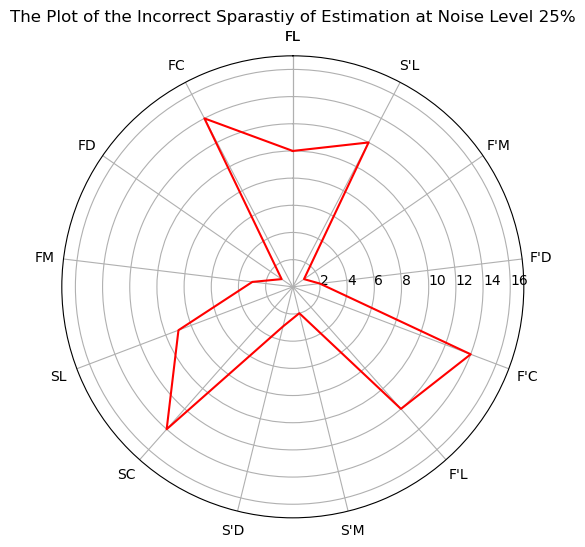

In [167]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_025_lr_2) != lorenz_2_true), "FC": np.sum(cz(fd_BR_CSS_025_lr_2)!= lorenz_2_true)
        , "FD": np.sum(cz(fd_BR_DSS_025_lr_2_Z)!= lorenz_2_true)
        , "FM": np.sum(cz(fd_BR_MDSS_025_lr_2_Z)!= lorenz_2_true), "SL": np.sum(cz(spline_ls_025_lr_2)!= lorenz_2_true)
        , "SC": np.sum(cz(fd_BR_CSS_025_lr_2)!= lorenz_2_true), "S'D": np.sum(cz(spline_deBR_DSS_025_lr_2_Z)!= lorenz_2_true)
        , "S'M": np.sum(cz(spline_deBR_MDSS_025_lr_2_Z)!= lorenz_2_true)
        ,"F'L": np.sum(cz(fd_dels_025_lr_2)!= lorenz_2_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_025_lr_2)!= lorenz_2_true), "F'D": np.sum(cz(fd_deBR_DSS_025_lr_2_Z)!= lorenz_2_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_025_lr_2_Z)!= lorenz_2_true)
        , "S'L": np.sum(cz(spline_dels_025_lr_2)!= lorenz_2_true)}#, "S'C": np.sum(cz(spline_deBR_CSS_025_lr_2)!= lorenz_2_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 25%')
ax.set_rlim(0, 17)
ax.set_rlabel_position(270)

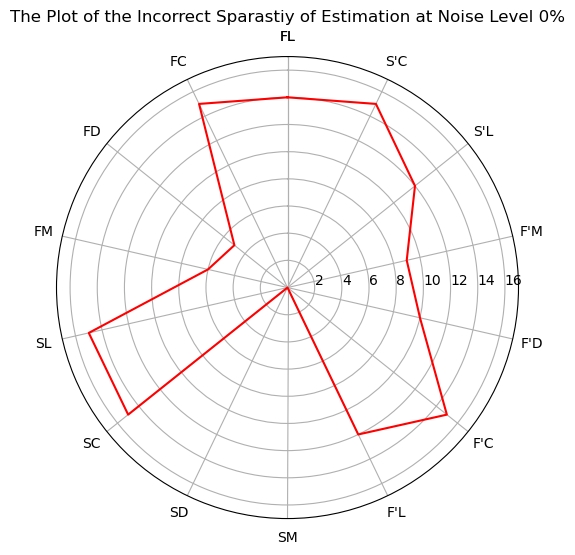

In [134]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_000_lr_3) != lorenz_3_true), "FC": np.sum(cz(fd_BR_CSS_000_lr_3)!= lorenz_3_true)
        , "FD": np.sum(cz(fd_BR_DSS_000_lr_3_Z)!= lorenz_3_true)
        , "FM": np.sum(cz(fd_BR_MDSS_000_lr_3_Z)!= lorenz_3_true), "SL": np.sum(cz(spline_ls_000_lr_3)!= lorenz_3_true)
        , "SC": np.sum(cz(fd_BR_CSS_000_lr_3)!= lorenz_3_true), "SD": np.sum(cz(spline_BR_DSS_000_lr_3_Z)!= lorenz_3_true)
        , "SM": np.sum(cz(spline_BR_MDSS_000_lr_3_Z)!= lorenz_3_true)
        ,"F'L": np.sum(cz(fd_dels_000_lr_3)!= lorenz_3_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_000_lr_3)!= lorenz_3_true), "F'D": np.sum(cz(fd_deBR_DSS_000_lr_3_Z)!= lorenz_3_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_000_lr_3_Z)!= lorenz_3_true)
        , "S'L": np.sum(cz(spline_dels_000_lr_3)!= lorenz_3_true), "S'C": np.sum(cz(spline_deBR_CSS_000_lr_3)!= lorenz_3_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 0%')
ax.set_rlim(0, 17)
ax.set_rlabel_position(270)

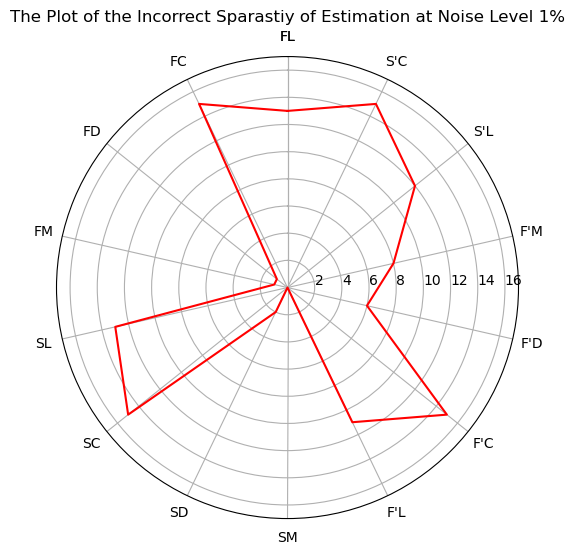

In [142]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_001_lr_3) != lorenz_3_true), "FC": np.sum(cz(fd_BR_CSS_001_lr_3)!= lorenz_3_true)
        , "FD": np.sum(cz(fd_BR_DSS_001_lr_3_Z)!= lorenz_3_true)
        , "FM": np.sum(cz(fd_BR_MDSS_001_lr_3_Z)!= lorenz_3_true), "SL": np.sum(cz(spline_ls_001_lr_3)!= lorenz_3_true)
        , "SC": np.sum(cz(fd_BR_CSS_001_lr_3)!= lorenz_3_true), "SD": np.sum(cz(spline_BR_DSS_001_lr_3_Z)!= lorenz_3_true)
        , "SM": np.sum(cz(spline_BR_MDSS_001_lr_3_Z)!= lorenz_3_true)
        ,"F'L": np.sum(cz(fd_dels_001_lr_3)!= lorenz_3_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_001_lr_3)!= lorenz_3_true), "F'D": np.sum(cz(fd_deBR_DSS_001_lr_3_Z)!= lorenz_3_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_001_lr_3_Z)!= lorenz_3_true)
        , "S'L": np.sum(cz(spline_dels_001_lr_3)!= lorenz_3_true), "S'C": np.sum(cz(spline_deBR_CSS_001_lr_3)!= lorenz_3_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 1%')
ax.set_rlim(0, 17)
ax.set_rlabel_position(270)

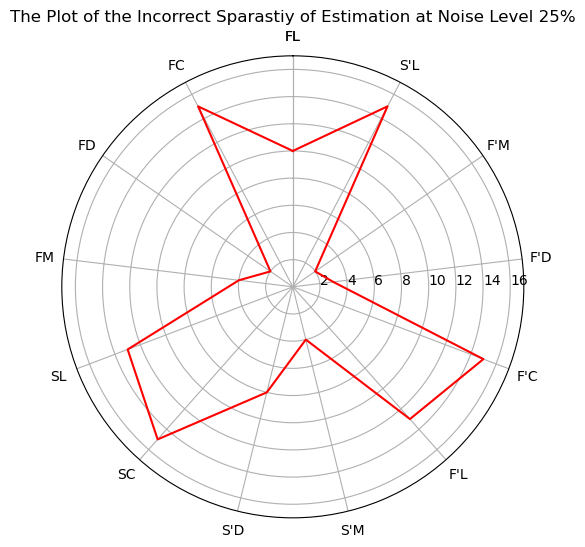

In [168]:
import numpy as np
import matplotlib.pyplot as plt
 
results = {"FL": np.sum(cz(fd_ls_025_lr_3) != lorenz_3_true), "FC": np.sum(cz(fd_BR_CSS_025_lr_3)!= lorenz_3_true)
        , "FD": np.sum(cz(fd_BR_DSS_025_lr_3_Z)!= lorenz_3_true)
        , "FM": np.sum(cz(fd_BR_MDSS_025_lr_3_Z)!= lorenz_3_true), "SL": np.sum(cz(spline_ls_025_lr_3)!= lorenz_3_true)
        , "SC": np.sum(cz(fd_BR_CSS_025_lr_3)!= lorenz_3_true), "S'D": np.sum(cz(spline_deBR_DSS_025_lr_3_Z)!= lorenz_3_true)
        , "S'M": np.sum(cz(spline_deBR_MDSS_025_lr_3_Z)!= lorenz_3_true)
        ,"F'L": np.sum(cz(fd_dels_025_lr_3)!= lorenz_3_true)
        , "F'C": np.sum(cz(fd_deBR_CSS_025_lr_3)!= lorenz_3_true), "F'D": np.sum(cz(fd_deBR_DSS_025_lr_3_Z)!= lorenz_3_true)
        , "F'M": np.sum(cz(fd_deBR_MDSS_025_lr_3_Z)!= lorenz_3_true)
        , "S'L": np.sum(cz(spline_dels_025_lr_3)!= lorenz_3_true)}#, "S'C": np.sum(cz(spline_deBR_CSS_000_lr_3)!= lorenz_3_true)}
data_length = len(results)
# 将极坐标根据数据长度进行等分
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results.keys()]
score = [key for key in results.values()]
# 使雷达图数据封闭
score_a = np.concatenate((score, [score[0]]))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))
# 设置图形的大小
fig = plt.figure(figsize=(8, 6), dpi=100)
# 新建一个子图
ax = plt.subplot(111, polar=True)
# 绘制雷达图
ax.plot(angles, score_a, color='r')

# 设置雷达图中每一项的标签显示
ax.set_thetagrids(angles*180/np.pi, labels)
# 设置雷达图的0度起始位置
ax.set_theta_zero_location('N')
plt.title('The Plot of the Incorrect Sparastiy of Estimation at Noise Level 25%')
ax.set_rlim(0, 17)
ax.set_rlabel_position(270)

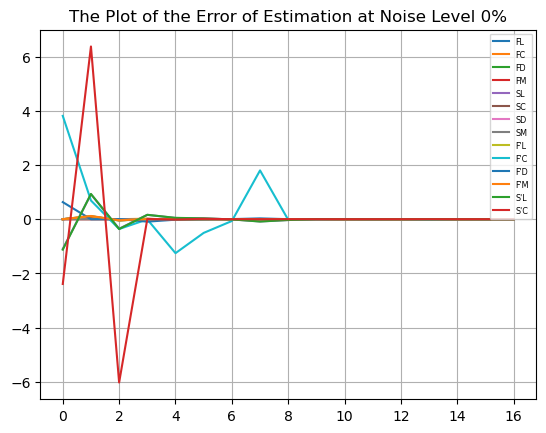

In [150]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(lorenz_1)
#noise000 two_compartment_1
plt.plot(fd_ls_000_lr_1-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_000_lr_1)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_000_lr_1)*np.array(fd_BR_DSS_000_lr_1_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_000_lr_1)*np.array(fd_BR_MDSS_000_lr_1_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_000_lr_1-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_000_lr_1)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_BR_DSS_000_lr_1)*np.array(spline_BR_DSS_000_lr_1_Z)-nonlinear_1,label= "SD")
plt.plot(np.array(spline_BR_MDSS_000_lr_1)*np.array(spline_BR_MDSS_000_lr_1_Z)-nonlinear_1,label= "SM")
plt.plot(fd_dels_000_lr_1-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_000_lr_1)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_000_lr_1)*np.array(fd_deBR_DSS_000_lr_1_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_000_lr_1)*np.array(fd_deBR_MDSS_000_lr_1_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_000_lr_1-nonlinear_1,label= "S'L")
plt.plot(spline_deBR_CSS_000_lr_1-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 0%')
plt.xlabel('')
# plt.ylim(-6,5)
# plt.xlim(0,8.5)
plt.legend(fontsize=5.8)
plt.grid()

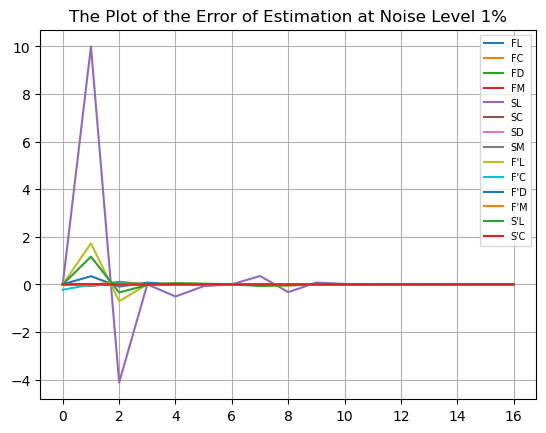

In [157]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(lorenz_1)
#noise000 two_compartment_1
plt.plot(fd_ls_001_lr_1-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_001_lr_1)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_001_lr_1)*np.array(fd_BR_DSS_001_lr_1_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_001_lr_1)*np.array(fd_BR_MDSS_001_lr_1_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_001_lr_1-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_001_lr_1)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_BR_DSS_001_lr_1)*np.array(spline_BR_DSS_001_lr_1_Z)-nonlinear_1,label= "SD")
plt.plot(np.array(spline_BR_MDSS_001_lr_1)*np.array(spline_BR_MDSS_001_lr_1_Z)-nonlinear_1,label= "SM")
plt.plot(fd_dels_001_lr_1-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_001_lr_1)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_001_lr_1)*np.array(fd_deBR_DSS_001_lr_1_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_001_lr_1)*np.array(fd_deBR_MDSS_001_lr_1_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_001_lr_1-nonlinear_1,label= "S'L")
plt.plot(spline_deBR_CSS_001_lr_1-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 1%')
plt.xlabel('')
# plt.ylim(-6,5)
# plt.xlim(0,8.5)
plt.legend(fontsize=7)
plt.grid()

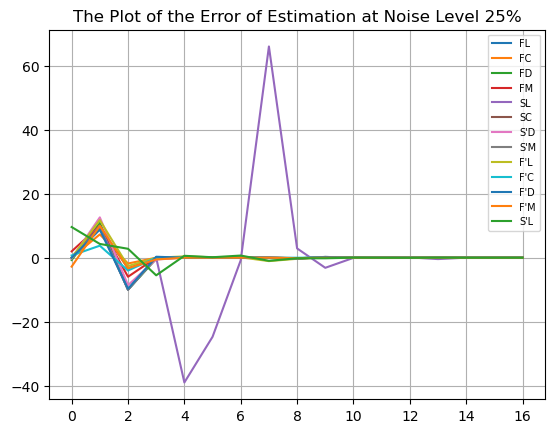

In [160]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(lorenz_1)
#noise000 two_compartment_1
plt.plot(fd_ls_025_lr_1-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_025_lr_1)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_025_lr_1)*np.array(fd_BR_DSS_025_lr_1_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_025_lr_1)*np.array(fd_BR_MDSS_025_lr_1_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_025_lr_1-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_025_lr_1)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_deBR_DSS_025_lr_1)*np.array(spline_deBR_DSS_025_lr_1_Z)-nonlinear_1,label= "S'D")
plt.plot(np.array(spline_deBR_MDSS_025_lr_1)*np.array(spline_deBR_MDSS_025_lr_1_Z)-nonlinear_1,label= "S'M")
plt.plot(fd_dels_025_lr_1-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_025_lr_1)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_025_lr_1)*np.array(fd_deBR_DSS_025_lr_1_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_025_lr_1)*np.array(fd_deBR_MDSS_025_lr_1_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_025_lr_1-nonlinear_1,label= "S'L")
# plt.plot(spline_deBR_CSS_025_lr_1-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 25%')
plt.xlabel('')
# plt.ylim(-6,5)
# plt.xlim(0,8.5)
plt.legend(fontsize=7)
plt.grid()

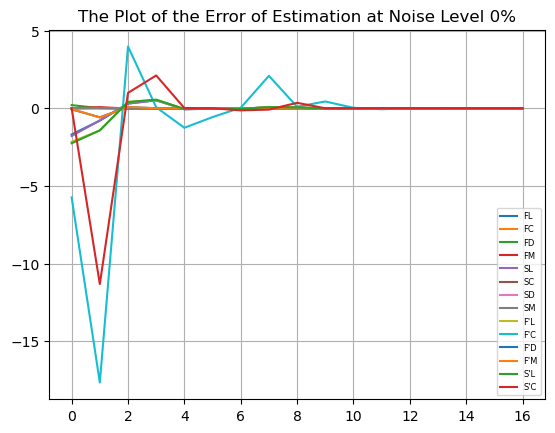

In [152]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(lorenz_2)
#noise000 two_compartment_1
plt.plot(fd_ls_000_lr_2-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_000_lr_2)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_000_lr_2)*np.array(fd_BR_DSS_000_lr_2_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_000_lr_2)*np.array(fd_BR_MDSS_000_lr_2_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_000_lr_2-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_000_lr_2)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_BR_DSS_000_lr_2)*np.array(spline_BR_DSS_000_lr_2_Z)-nonlinear_1,label= "SD")
plt.plot(np.array(spline_BR_MDSS_000_lr_2)*np.array(spline_BR_MDSS_000_lr_2_Z)-nonlinear_1,label= "SM")
plt.plot(fd_dels_000_lr_2-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_000_lr_2)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_000_lr_2)*np.array(fd_deBR_DSS_000_lr_2_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_000_lr_2)*np.array(fd_deBR_MDSS_000_lr_2_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_000_lr_2-nonlinear_1,label= "S'L")
plt.plot(spline_deBR_CSS_000_lr_2-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 0%')
plt.xlabel('')
# plt.ylim(-6,5)
# plt.xlim(0,8.5)
plt.legend(fontsize=6)
plt.grid()

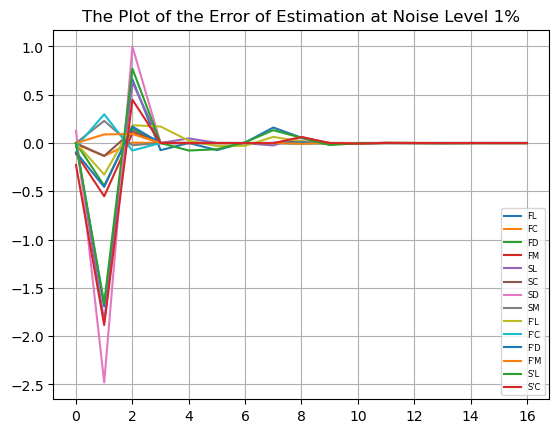

In [161]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(lorenz_2)
#noise000 two_compartment_1
plt.plot(fd_ls_001_lr_2-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_001_lr_2)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_001_lr_2)*np.array(fd_BR_DSS_001_lr_2_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_001_lr_2)*np.array(fd_BR_MDSS_001_lr_2_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_001_lr_2-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_001_lr_2)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_BR_DSS_001_lr_2)*np.array(spline_BR_DSS_001_lr_2_Z)-nonlinear_1,label= "SD")
plt.plot(np.array(spline_BR_MDSS_001_lr_2)*np.array(spline_BR_MDSS_001_lr_2_Z)-nonlinear_1,label= "SM")
plt.plot(fd_dels_001_lr_2-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_001_lr_2)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_001_lr_2)*np.array(fd_deBR_DSS_001_lr_2_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_001_lr_2)*np.array(fd_deBR_MDSS_001_lr_2_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_001_lr_2-nonlinear_1,label= "S'L")
plt.plot(spline_deBR_CSS_001_lr_2-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 1%')
plt.xlabel('')
# plt.ylim(-6,5)
# plt.xlim(0,8.5)
plt.legend(fontsize=6)
plt.grid()

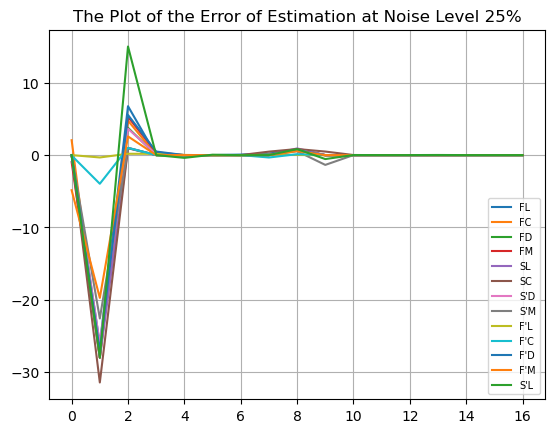

In [163]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(lorenz_2)
#noise000 two_compartment_1
plt.plot(fd_ls_025_lr_2-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_025_lr_2)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_025_lr_2)*np.array(fd_BR_DSS_025_lr_2_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_025_lr_2)*np.array(fd_BR_MDSS_025_lr_2_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_025_lr_2-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_025_lr_2)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_deBR_DSS_025_lr_2)*np.array(spline_deBR_DSS_025_lr_2_Z)-nonlinear_1,label= "S'D")
plt.plot(np.array(spline_deBR_MDSS_025_lr_2)*np.array(spline_deBR_MDSS_025_lr_2_Z)-nonlinear_1,label= "S'M")
plt.plot(fd_dels_001_lr_2-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_025_lr_2)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_025_lr_2)*np.array(fd_deBR_DSS_025_lr_2_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_025_lr_2)*np.array(fd_deBR_MDSS_025_lr_2_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_025_lr_2-nonlinear_1,label= "S'L")
# plt.plot(spline_deBR_CSS_001_lr_2-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 25%')
plt.xlabel('')
# plt.ylim(-6,5)
# plt.xlim(0,8.5)
plt.legend(fontsize=7)
plt.grid()

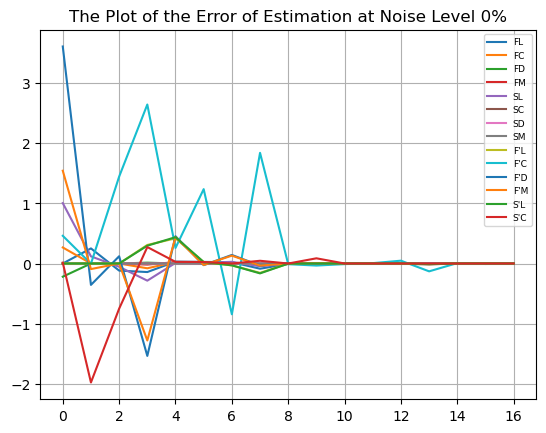

In [154]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(lorenz_3)
#noise000 two_compartment_1
plt.plot(fd_ls_000_lr_3-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_000_lr_3)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_000_lr_3)*np.array(fd_BR_DSS_000_lr_3_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_000_lr_3)*np.array(fd_BR_MDSS_000_lr_3_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_000_lr_3-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_000_lr_3)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_BR_DSS_000_lr_3)*np.array(spline_BR_DSS_000_lr_3_Z)-nonlinear_1,label= "SD")
plt.plot(np.array(spline_BR_MDSS_000_lr_3)*np.array(spline_BR_MDSS_000_lr_3_Z)-nonlinear_1,label= "SM")
plt.plot(fd_dels_000_lr_3-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_000_lr_3)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_000_lr_3)*np.array(fd_deBR_DSS_000_lr_3_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_000_lr_3)*np.array(fd_deBR_MDSS_000_lr_3_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_000_lr_3-nonlinear_1,label= "S'L")
plt.plot(spline_deBR_CSS_000_lr_3-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 0%')
plt.xlabel('')
# plt.ylim(-6,5)
# plt.xlim(0,8.5)
plt.legend(fontsize=6.5)
plt.grid()

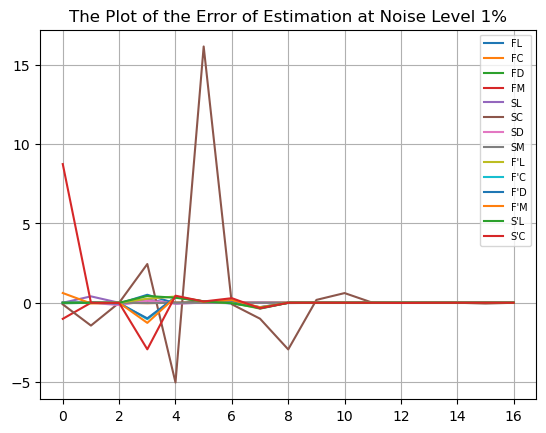

In [165]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(lorenz_3)
#noise000 two_compartment_1
plt.plot(fd_ls_001_lr_3-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_001_lr_3)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_001_lr_3)*np.array(fd_BR_DSS_001_lr_3_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_001_lr_3)*np.array(fd_BR_MDSS_001_lr_3_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_001_lr_3-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_001_lr_3)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_BR_DSS_001_lr_3)*np.array(spline_BR_DSS_001_lr_3_Z)-nonlinear_1,label= "SD")
plt.plot(np.array(spline_BR_MDSS_001_lr_3)*np.array(spline_BR_MDSS_001_lr_3_Z)-nonlinear_1,label= "SM")
plt.plot(fd_dels_001_lr_3-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_001_lr_3)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_001_lr_3)*np.array(fd_deBR_DSS_001_lr_3_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_001_lr_3)*np.array(fd_deBR_MDSS_001_lr_3_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_001_lr_3-nonlinear_1,label= "S'L")
plt.plot(spline_deBR_CSS_001_lr_3-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 1%')
plt.xlabel('')
# plt.ylim(-6,5)
# plt.xlim(0,8.5)
plt.legend(fontsize=7)
plt.grid()

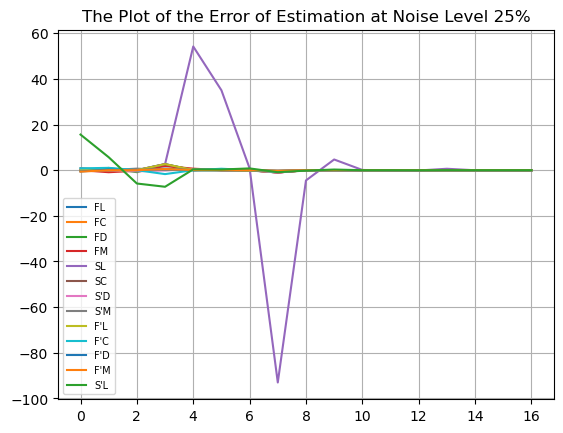

In [166]:
import matplotlib.pyplot as plt
import numpy as np
nonlinear_1 = np.array(lorenz_3)
#noise000 two_compartment_1
plt.plot(fd_ls_025_lr_3-nonlinear_1,label= "FL")
plt.plot(np.array(fd_BR_CSS_025_lr_3)-nonlinear_1,label= "FC")
plt.plot(np.array(fd_BR_DSS_025_lr_3)*np.array(fd_BR_DSS_025_lr_3_Z)-nonlinear_1,label= "FD")
plt.plot(np.array(fd_BR_MDSS_025_lr_3)*np.array(fd_BR_MDSS_025_lr_3_Z)-nonlinear_1,label= "FM")
plt.plot(spline_ls_025_lr_3-nonlinear_1,label= "SL")
plt.plot(np.array(spline_BR_CSS_025_lr_3)-nonlinear_1,label= "SC")
plt.plot(np.array(spline_deBR_DSS_025_lr_3)*np.array(spline_deBR_DSS_025_lr_3_Z)-nonlinear_1,label= "S'D")
plt.plot(np.array(spline_deBR_MDSS_025_lr_3)*np.array(spline_deBR_MDSS_025_lr_3_Z)-nonlinear_1,label= "S'M")
plt.plot(fd_dels_025_lr_3-nonlinear_1,label= "F'L")
plt.plot(np.array(fd_deBR_CSS_025_lr_3)-nonlinear_1,label= "F'C")
plt.plot(np.array(fd_deBR_DSS_025_lr_3)*np.array(fd_deBR_DSS_025_lr_3_Z)-nonlinear_1,label= "F'D")
plt.plot(np.array(fd_deBR_MDSS_025_lr_3)*np.array(fd_deBR_MDSS_025_lr_3_Z)-nonlinear_1,label= "F'M")
plt.plot(spline_dels_025_lr_3-nonlinear_1,label= "S'L")
# plt.plot(spline_deBR_CSS_000_lr_3-nonlinear_1,label= "S'C")

# plt.plot(result_3,label= "derivative of z")
plt.title('The Plot of the Error of Estimation at Noise Level 25%')
plt.xlabel('')
# plt.ylim(-6,5)
# plt.xlim(0,8.5)
plt.legend(fontsize=7)
plt.grid()